# AI Video Summarization

Publishers and broadcasters can leverage short-form video across social media platforms such as Facebook, Instagram, and TikTok to attract new audiences and create additional revenue opportunities.

However, generating video summaries is a manual and time-consuming process due to challenges like understanding complex content, maintaining coherence, diverse video types, and lack of scalability when dealing with a large volume of videos. Introducing automation through the use of artificial intelligence (AI) and machine learning (ML) can make this process more viable and scalable with automatic content analysis, real-time processing, contextual adaptation, customization, and continuous AI/ML system improvement.

### High level workflow

![video summarization diagram](static/images/video-summarization-diagram.png)

In this lab, we'll break down each step and show you in detail how video summarization can be achieved using AWS native services such as [Amazon Transcribe](https://aws.amazon.com/pm/transcribe), [Amazon Bedrock](https://aws.amazon.com/bedrock), [Amazon Polly](https://aws.amazon.com/polly/) and [AWS Elemental MediaConvert](https://aws.amazon.com/mediaconvert/).

## Prerequisites

To run this notebook, you need to have run all the previous foundation notebooks, where you set up the notebook environment and segmented the video using audio, visual and semantic information:
1. [00-prerequisites.ipynb](00-prerequisites.ipyn)
2. [01A-visual-segments-frames-shots-scenes.ipynb](01A-visual-segments-frames-shots-scenes.ipynb) 
3. [01B-audio-segments.ipynb](01B-audio-segments.ipynb) 

<div class="alert alert-block alert-info">
⏳ This notebook has some steps that take more than 5 minutes to run.  We recommend that you select the ⏩ run all cells option from the notebook menu above to run this notebook.  There will be a pop-up that says, "Do you want to restart the kernel of 03-video-summarization.ipynb? All variables will be lost."  Click the "Restart" button to proceed.  You can read through the results as the rest of the notebook is executing.
</div>

### Retrieve saved values from previous notebooks




In [1]:
store -r

### Import python packages

In [2]:
from pathlib import Path
import os
import json
import time
import boto3
from botocore.exceptions import ClientError
import json_repair
from termcolor import colored
from IPython.display import JSON
from IPython.display import Video
from IPython.display import Pretty
from IPython.display import Image as DisplayImage
from lib.frames import VideoFrames
from lib.shots import Shots
from lib.scenes import Scenes
from lib.transcript import Transcript
import base64
from opensearchpy import OpenSearch, RequestsHttpConnection, AWSV4SignerAuth
import subprocess
import numpy as np
import re

## Summarize video content from transcript

We use **Large Language Model (LLM)** with [Amazon Bedrock](https://aws.amazon.com/bedrock/) to summarize the content of the video.

In [3]:
bedrock_client = boto3.client(service_name="bedrock-runtime")
accept = "application/json"
content_type = "application/json"

In [4]:
with open(video['transcript'].transcript_file, 'r') as file:
    transcript_file = json.load(file)
transcript = transcript_file['results']['transcripts'][0]['transcript']

model_id = "anthropic.claude-3-sonnet-20240229-v1:0"

prompt = f"""Summarize the key points from the following video content in chronological order:

{transcript} 

\n\nThe summary should only contain information present in the video content. Do not include any new or unrelated information.

Important: Start the summary immediately without any introductory phrases. Begin directly with the first key point."""

body = json.dumps(
    {
        "messages": [
            {
                "role": "user",
                "content": [
                    {"type": "text", "text": prompt},
                ],
            }
        ],
        "anthropic_version": "bedrock-2023-05-31",
        "max_tokens": 1024,
        "temperature": 0.25,
        "top_p": 0.9,

    }
)
response = bedrock_client.invoke_model(
    body=body, modelId=model_id, accept=accept, contentType=content_type
)
response_body = json.loads(response["body"].read())
summarized_text = response_body["content"][0]["text"]

You can invoke the endpoint with different parameters defined in the payload to impact the text summarization. Two important parameters are `top_p` and `temperature`. While `top_p` is used to control the range of tokens considered by the model based on their cumulative probability, `temperature` controls the level of randomness in the output.

Although there isn’t a one-size-fits-all combination of `top_p` and `temperature` for all use cases, in the previous example, we demonstrate sample values with high `top_p` and low `temperature` that leads to summaries focused on key information and avoid deviating from the original text but still introduce some creative variations to keep the output interesting.

Let's check the summarized video content:

In [5]:
summarized_text

'A group of men disappeared on the road above El Matador beach near a large rock formation. Mickey Cohen, a mobster, used to take associates to that area. The missing men were a school teacher, an insurance salesman, and a retiree with no apparent criminal connections except one had a prior drunk driving arrest and they were all divorced. A witness claimed to have seen one of the missing men acting strangely on the rock formation before a sudden storm arose and the man disappeared, replaced by a woman in a white dress staring at the witness. The police captain investigating the disappearances also went missing in that area.'

## Generate metadata for voice narration

The next step starts with [Amazon Polly](https://aws.amazon.com/polly/) to generate speech from the summarized text. The output of the Polly task is both MP3 files and documents marked up with [Speech Synthesis Markup Language (SSML)](https://docs.aws.amazon.com/polly/latest/dg/ssml.html). Within this SSML file, essential metadata is encapsulated, describing the duration of individual sentences vocalized by a specific Polly voice. With this audio duration information, we will be able to define the length of the video segments; in this case, a direct 1:1 correspondence is employed.

In [6]:
polly_client = boto3.client("polly")
voice_id = "Matthew"

In [7]:
response = polly_client.synthesize_speech(
    Engine="neural",
    OutputFormat="json",
    Text=summarized_text + " This video is generated by Video Summarization Hub.",
    TextType="text",
    SpeechMarkTypes=["sentence"],
    VoiceId=voice_id,
)

stream_data = response['AudioStream'].read()
polly_ssml = stream_data.decode('utf-8')

The following is the Amazon Polly synthesis speech output in SSML format:

In [8]:
polly_ssml = polly_ssml.split("\n")
polly_ssml

['{"time":0,"type":"sentence","start":0,"end":90,"value":"A group of men disappeared on the road above El Matador beach near a large rock formation."}',
 '{"time":4930,"type":"sentence","start":91,"end":153,"value":"Mickey Cohen, a mobster, used to take associates to that area."}',
 '{"time":9022,"type":"sentence","start":154,"end":339,"value":"The missing men were a school teacher, an insurance salesman, and a retiree with no apparent criminal connections except one had a prior drunk driving arrest and they were all divorced."}',
 '{"time":18177,"type":"sentence","start":340,"end":546,"value":"A witness claimed to have seen one of the missing men acting strangely on the rock formation before a sudden storm arose and the man disappeared, replaced by a woman in a white dress staring at the witness."}',
 '{"time":28082,"type":"sentence","start":547,"end":630,"value":"The police captain investigating the disappearances also went missing in that area."}',
 '{"time":32312,"type":"sentence",

The SSML file provides both the video summary sentences and their speech durations, which represent the time Amazon Polly takes to vocalize each sentence. We will extract these values to align the synthesized speech with the video timeline in the next several steps.

In [9]:
summarized_sentences = []
speech_durations = []

for i in range(len(polly_ssml) - 1):
    curr = polly_ssml[i]
    next = polly_ssml[i + 1]
    if curr.strip() == "" or next.strip() == "":
        continue
    curr = json.loads(curr)
    next = json.loads(next)
    summarized_sentences.append(curr["value"])
    speech_durations.append(int(next["time"]) - int(curr["time"]))

## Select most relevant video shots/scenes

We need to select the most relevant video frame sequence to match with every sentence in the summarized content. Thus, we use text embedding to perform the sentence similarity task, which determines how similar two texts are.

Sentence similarity models transform input texts into vectors (embeddings) that capture semantic information and calculate the proximity or similarity between them.

In this step, we use **Text Embedding Model** with [Amazon Bedrock](https://aws.amazon.com/bedrock/) to create the embeddings for every sentence in the original subtitle and in the video summary.

First, we get the original subtitle file and do some processings to break it down into sentences with start times and end times.

In [10]:
with open(video['transcript'].vtt_file, 'r', encoding='utf-8') as file:
    subtitle = file.read()

if subtitle.startswith("WEBVTT"):
    subtitle = subtitle[len("WEBVTT"):].lstrip()

print(subtitle)

0
00:00:26.860 --> 00:00:28.260
So these guys just

1
00:00:28.569 --> 00:00:29.459
disappeared.

2
00:00:30.940 --> 00:00:34.159
Yeah. All that stretch of road right above El Matador.

3
00:00:35.110 --> 00:00:35.659
You know it

4
00:00:36.500 --> 00:00:37.479
with the big rock.

5
00:00:37.790 --> 00:00:38.360
That's right.

6
00:00:38.490 --> 00:00:38.799
Yeah,

7
00:00:40.729 --> 00:00:42.979
Mickey Cohen used to take his associates out there.

8
00:00:43.389 --> 00:00:44.819
Bid him a bond voyage.

9
00:00:45.330 --> 00:00:46.279
Mob hoods.

10
00:00:46.450 --> 00:00:47.599
Not at this time.

11
00:00:47.900 --> 00:00:49.979
One of these guys was a school teacher.

12
00:00:50.680 --> 00:00:54.459
Next guy, he sold insurance and the last guy, he was retired.

13
00:00:55.619 --> 00:00:56.319
Any connection.

14
00:00:56.990 --> 00:00:57.599
Mm mm

15
00:00:58.599 --> 00:00:59.900
I mean, I check them all out.

16
00:01:00.529 --> 00:01:04.800
There's no criminal records, no assoc

In [11]:
def srt_to_array(s):
    """
    Converts the given transcription in SRT/WEBVTT format to list of sentences and their corresponding timecodes.
    Args:
       s - transcription in SRT/WEBVTT format.
    Returns:
       A list of dictionaries, where each dictionary represents a sentence and its corresponding start time and end time.
    """
    sentences = [line.strip() for line in re.findall(r"\d+\n.*?\n(.*?)\n", s)]

    def get_time(s):
        return re.findall(r"\d{2}:\d{2}:\d{2}.\d{3}", s)

    def time_to_ms(time_str):
        match = re.match(r"(\d+):(\d+):(\d+)[.,](\d+)", time_str)
        h, m, s, ms = match.groups()
        return int(h) * 3600000 + int(m) * 60000 + int(s) * 1000 + int(ms)

    startTimes = get_time(s)[::2]
    endTimes = get_time(s)[1::2]
    startTimes_ms = [time_to_ms(time) for time in startTimes]
    endTimes_ms = [time_to_ms(time) for time in endTimes]

    complete_sentences = []
    complete_startTimes_ms = []
    complete_endTimes_ms = []

    startTime_ms = -1
    endTime_ms = -1
    sentence = ""
    for i in range(len(sentences)):
        if startTime_ms == -1:
            startTime_ms = startTimes_ms[i]
        sentence += " " + sentences[i]
        if (
            sentences[i].endswith(".")
            or sentences[i].endswith("?")
            or sentences[i].endswith("!")
            or i == len(sentences) - 1
        ):
            endTime_ms = endTimes_ms[i]
            complete_sentences.append(sentence)
            complete_startTimes_ms.append(startTime_ms)
            complete_endTimes_ms.append(endTime_ms)
            startTime_ms = -1
            endTime_ms = -1
            sentence = ""
    processed_transcript = []
    for i in range(len(complete_sentences)):
        processed_transcript.append(
            {
                "sentence_startTime": complete_startTimes_ms[i],
                "sentence_endTime": complete_endTimes_ms[i],
                "sentence": complete_sentences[i],
            }
        )
    return processed_transcript

In [12]:
processed_transcript = srt_to_array(subtitle)

Let's visualize some sentences from the video's original transcript:

In [13]:
original_sentences = [item['sentence'] for item in processed_transcript]
original_sentences[:10]

[' So these guys just disappeared.',
 ' Yeah. All that stretch of road right above El Matador.',
 ' You know it with the big rock.',
 " That's right.",
 ' Yeah, Mickey Cohen used to take his associates out there.',
 ' Bid him a bond voyage.',
 ' Mob hoods.',
 ' Not at this time.',
 ' One of these guys was a school teacher.',
 ' Next guy, he sold insurance and the last guy, he was retired.']

Next, we create the text embeddings for every sentence in the original subtitle and in the video summary. The following code gives an example of how text embedding using Amazon Bedrock API works

In [14]:
def find_matching_sentences(original_sentences, summarized_sentences):
    """
    Calculates the similarity between the given original sentences and the summarized sentences.
    Args:
       original_sentences - sentences extacted from the original video
       summarized_sentences - sentences extacted from the video summary
    Return:
       best_matching_indices - list of indices indicating which original sentence best matches each summarized sentence
       similarity_matrix - sentences similarity matrix
    
    """
    def np_cosine_similarity(original_embeddings, summarized_embeddings):
        """
        We use `Cosine similarity` to measure similarities between two vectors.
        """
        dot_products = np.dot(summarized_embeddings, original_embeddings.T)
        summarized_norms = np.linalg.norm(summarized_embeddings, axis=1)
        original_norms = np.linalg.norm(original_embeddings, axis=1)
        similarity_matrix = dot_products / summarized_norms[:, None] / original_norms[None, :]
        return similarity_matrix
        
    model_id = "amazon.titan-embed-image-v1"
    accept = "application/json"
    content_type = "application/json"
    original_embeddings = []
    for str in original_sentences:
        body = json.dumps({"inputText": str})
        response = bedrock_client.invoke_model(
            body=body, modelId=model_id, accept=accept, contentType=content_type
        )
        response_body = json.loads(response["body"].read())
        original_embeddings.append(response_body.get("embedding"))
    original_embeddings = np.array(original_embeddings)

    summarized_embeddings = []
    for str in summarized_sentences:
        body = json.dumps({"inputText": str})
        response = bedrock_client.invoke_model(
            body=body, modelId=model_id, accept=accept, contentType=content_type
        )
        response_body = json.loads(response["body"].read())
        summarized_embeddings.append(response_body.get("embedding"))
    summarized_embeddings = np.array(summarized_embeddings)

    similarity_matrix = np_cosine_similarity(original_embeddings, summarized_embeddings)
    best_matching_indices = []
    len_summarized_sentences = len(summarized_sentences)
    len_original_sentences = len(original_sentences)

    # Find the best matching sentences.
    dp = np.zeros([len_summarized_sentences, len_original_sentences], dtype=float)
    for i in range(0, len_summarized_sentences):
        for j in range(0, len_original_sentences):
            if i == 0:
                dp[i][j] = similarity_matrix[i][j]
            else:
                max_score = -1
                for k in range(0, j):
                    if similarity_matrix[i][j] > 0 and dp[i - 1][k] > 0:
                        max_score = max(
                            max_score, similarity_matrix[i][j] + dp[i - 1][k]
                        )
                dp[i][j] = max_score

    j = len_original_sentences

    for i in range(len_summarized_sentences - 1, -1, -1):
        arr = dp[i][:j]
        idx = np.argmax(arr)
        best_matching_indices.append(idx)
        j = idx
    best_matching_indices.reverse()

    return best_matching_indices, similarity_matrix

In [15]:
best_matching_indices, similarity_matrix = find_matching_sentences(original_sentences, summarized_sentences)

This will return the similarity matrix result as follow:

In [16]:
similarity_matrix

array([[0.51098546, 0.74671993, 0.46085647, 0.36347839, 0.35181045,
        0.40191021, 0.34863645, 0.36316611, 0.42441064, 0.41490876,
        0.36000845, 0.39572795, 0.3596561 , 0.45654862, 0.39447121,
        0.38783312, 0.32113652, 0.39520043, 0.39741945, 0.48930274,
        0.42754821, 0.30613381, 0.36711525, 0.49682775, 0.34932606,
        0.38414341, 0.39943927, 0.73752343, 0.54119559, 0.470486  ,
        0.39930252, 0.46964522, 0.45654254, 0.39034804, 0.46381268,
        0.41696821, 0.48384829, 0.38161706, 0.36072125, 0.46984915,
        0.43510955, 0.47695535, 0.43955782, 0.60896395, 0.49048465,
        0.4755955 , 0.4361239 , 0.37679292, 0.41253425, 0.38408463,
        0.61671841, 0.44432315, 0.40959002, 0.40567922, 0.46943176],
       [0.40840235, 0.33551152, 0.40100207, 0.37006206, 0.8986772 ,
        0.36896516, 0.44333084, 0.35422673, 0.41158033, 0.41873863,
        0.37070602, 0.40599571, 0.4416139 , 0.45486591, 0.42387877,
        0.40073358, 0.38009429, 0.4056726 , 0.3

You can interpret the prior result as: the first row of the matrix corresponds to the first sentence in the summarized content and all the columns show its similarity scores to the sentences in the original text. Similarity values typically range between -1 and 1, where 1 indicates that the vectors are identical or very similar; 0 indicates that the vectors are orthogonal (not correlated) and have no similarity; -1 indicates that the vectors are diametrically opposed or very dissimilar.

From the similarity matrix, we identify the top-k highest similarity scores for each sentence in the summarized content, thereby aligning them with the most similar sentences in the original text. Each sentence in the original text also has its corresponding timestamp (i.e. startTime, endTime) stored in the original subtitle.

By incorporating both the duration of Polly audio for each summarized sentence and the timestamps from the original subtitle file, we can then select the timestamp sequence for the most relevant frames corresponding to each summarized sentence. The length of each selected video segment for a summarized sentence will be aligned with the length of its narration audio.

In [17]:
def get_timecodes(best_matching_indices, idx, endTimes, duration, timecodes):
    """
    Calculate the best start and end time for each summarized sentence aligned with the timecode from the original sentences
    Args:
      best_matching_indices - the indices from the original sentence that is most similar with the summarized sentences.
      idx - index from the summarized sentences to process
      endTimes - the endtime from the original sentences
      duration - speech duration for the synthesized sentences from the summarized text
      timecodes - timecode used for calculating the best placement for the summarized text within the video.
    Return:
      
    """
    best_matching_idx = best_matching_indices[idx]
    startTime = int(endTimes[best_matching_idx]) - duration
    carry = max(0, timecodes[len(timecodes) - 1][1] - startTime)
    startTime += carry
    endTime = int(endTimes[best_matching_idx]) + carry
    return startTime, endTime

def ms_to_timecode(ms, drop_frame=False):
    """
    Convert milliseconds to SMPTE timecode
    Args:
        ms: milliseconds
        drop_frame: Boolean, True for drop frame, False for non-drop frame
    Return:
        string in HH:MM:SS:FF or HH:MM:SS;FF format
    """
    total_frames = int(ms * (29.97 if drop_frame else 30) / 1000)
    frames = total_frames % 30
    
    total_seconds = total_frames // 30
    seconds = total_seconds % 60
    
    total_minutes = total_seconds // 60
    minutes = total_minutes % 60
    
    hours = total_minutes // 60
    separator = ';' if drop_frame else ':'    
    return f"{hours:02d}:{minutes:02d}:{seconds:02d}{separator}{frames:02d}"

In [18]:
intro_time = float(transcript_file["results"]["items"][0]["start_time"]) * 1000

timecodes = [[0, intro_time]]
for i in range(len(summarized_sentences)):
    startTime, endTime = get_timecodes(
        best_matching_indices,
        i,
        [item['sentence_endTime'] for item in processed_transcript],
        speech_durations[i],
        timecodes,
    )
    timecodes.append([startTime, endTime])
creditTime = endTime + 3500
timecodes.append([endTime, creditTime])
timecodes_text = ""
for timecode in timecodes:
    timecodes_text += (
        ms_to_timecode(timecode[0], True)
        + ","
        + ms_to_timecode(timecode[1], True)
        + "\n"
    )
to_json = lambda s: [
    {"StartTimecode": t1, "EndTimecode": t2}
    for t1, t2 in (line.split(",") for line in s.split("\n") if line.strip())
]
timecodes = to_json(timecodes_text)

Here are the generated timecodes that will be used for AWS Elemental MediaConvert input clipping:

In [19]:
timecodes

[{'StartTimecode': '00:00:00;00', 'EndTimecode': '00:00:26;24'},
 {'StartTimecode': '00:00:29;05', 'EndTimecode': '00:00:34;03'},
 {'StartTimecode': '00:00:38;25', 'EndTimecode': '00:00:42;28'},
 {'StartTimecode': '00:00:58;16', 'EndTimecode': '00:01:07;21'},
 {'StartTimecode': '00:02:45;17', 'EndTimecode': '00:02:55;14'},
 {'StartTimecode': '00:03:25;06', 'EndTimecode': '00:03:29;13'},
 {'StartTimecode': '00:03:29;13', 'EndTimecode': '00:03:32;28'}]

You can now generate the audio narration from the video summary in MP3 format using Amazon Polly. Keep in mind to escape special characters in the summarized text for SSML compatibility as well as create SSML markup with appropriate breaks for intro timing.

In [20]:
escaped_summarized_text = (
        summarized_text.replace("&", "&amp;")
        .replace('"', "&quot;")
        .replace("'", "&apos;")
        .replace("<", "&lt;")
        .replace(">", "&gt;")
    )
ssml = "<speak>\n"
break_time = intro_time

while break_time > 10000:  # maximum break time in Polly is 10s
    ssml += '<break time = "' + str(break_time) + 'ms"/>'
    break_time -= 10000
ssml += '<break time = "' + str(break_time) + 'ms"/>'
ssml += escaped_summarized_text
ssml += "</speak>"

response = polly_client.synthesize_speech(
    Engine="neural",
    OutputFormat="mp3",
    Text=ssml,
    TextType="ssml",
    VoiceId=voice_id,
)

if "AudioStream" in response:
    with response["AudioStream"] as stream:
        audio_narration = stream.read()

In [21]:
ssml

'<speak>\n<break time = "26860.0ms"/><break time = "16860.0ms"/><break time = "6860.0ms"/>A group of men disappeared on the road above El Matador beach near a large rock formation. Mickey Cohen, a mobster, used to take associates to that area. The missing men were a school teacher, an insurance salesman, and a retiree with no apparent criminal connections except one had a prior drunk driving arrest and they were all divorced. A witness claimed to have seen one of the missing men acting strangely on the rock formation before a sudden storm arose and the man disappeared, replaced by a woman in a white dress staring at the witness. The police captain investigating the disappearances also went missing in that area.</speak>'

We upload the audio narration into Amazon S3 bucket ready for the video transcoding step with AWS Elemental MediaConvert.

In [22]:
s3_client = boto3.client("s3")
s3_bucket = session["bucket"]
audio_narration_filename = os.path.splitext(os.path.basename(video['path']))[0] + ".mp3"
s3_client.put_object(
    Body=audio_narration, Bucket=s3_bucket, Key=audio_narration_filename, ContentType="audio/mpeg"
)

{'ResponseMetadata': {'RequestId': 'RMQEX6VXG72G8XTP',
  'HostId': '+x5Fw5ksJEGL4sFURAflibTtEA+bWInyA4fT+O2j+feOd+wnQ7nZuOoEBsHGT1cnwtAjaPwKNzk=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': '+x5Fw5ksJEGL4sFURAflibTtEA+bWInyA4fT+O2j+feOd+wnQ7nZuOoEBsHGT1cnwtAjaPwKNzk=',
   'x-amz-request-id': 'RMQEX6VXG72G8XTP',
   'date': 'Tue, 26 Nov 2024 02:15:00 GMT',
   'x-amz-server-side-encryption': 'AES256',
   'etag': '"408a0ab3ea613707baa5c98091873c1a"',
   'content-length': '0',
   'server': 'AmazonS3'},
  'RetryAttempts': 0},
 'ETag': '"408a0ab3ea613707baa5c98091873c1a"',
 'ServerSideEncryption': 'AES256'}

## Create MediaConvert assembly workflows

We use the sequence of the timecodes as parameters to create AWS Elemental MediaConvert assembly workflows to performs basic input clipping.

By combining it with the MP3 audio from Amazon Polly and along with the possibility of incorporating background music of your preference, you can ultimately achieve the final video summarization output.

Let's start the assembly workflow from the original video input. An assembly workflow is a MediaConvert job that performs basic input clipping and stitching to assemble output assets from one or different sources without requiring separate editing software.

In [23]:
iam_role = session["MediaConvertRole"]
input_video_path = video["url"]
output_video_path = f"s3://{s3_bucket}/"

In [24]:
video["url"]

'https://ws-assets-prod-iad-r-pdx-f3b3f9f1a7d6a3d0.s3.us-west-2.amazonaws.com/7db2455e-0fa6-4f6d-9973-84daccd6421f/Netflix_Open_Content_Meridian.mp4'

In [25]:
media_convert = boto3.client("mediaconvert")
response = media_convert.create_job(
    Queue="Default",
    UserMetadata={},
    Role=iam_role,
    Settings={
        "TimecodeConfig": {"Source": "ZEROBASED"},
        "OutputGroups": [
            {
                "Name": "File Group",
                "Outputs": [
                    {
                        "ContainerSettings": {
                            "Container": "MP4",
                            "Mp4Settings": {},
                        },
                        "VideoDescription": {
                            "CodecSettings": {
                                "Codec": "H_264",
                                "H264Settings": {
                                    "MaxBitrate": 40000000,
                                    "RateControlMode": "QVBR",
                                    "SceneChangeDetect": "TRANSITION_DETECTION",
                                },
                            }
                        }
                    }
                ],
                "OutputGroupSettings": {
                    "Type": "FILE_GROUP_SETTINGS",
                    "FileGroupSettings": {"Destination": output_video_path},
                },
            }
        ],
        "Inputs": [
            {
                "VideoSelector": {},
                "TimecodeSource": "ZEROBASED",
                "FileInput": input_video_path,
                "InputClippings": timecodes,
            }
        ],
    },
    AccelerationSettings={"Mode": "DISABLED"},
    StatusUpdateInterval="SECONDS_60",
    Priority=0,
)

job_complete = False

while not job_complete:
    job_response = media_convert.get_job(Id=response["Job"]["Id"])
    
    job_status = job_response['Job']['Status']
    print(f"MediaConvert job status: {job_status}")
    
    if job_status == 'COMPLETE':
        print("Job is complete!")
        job_complete = True
    elif job_status == 'ERROR':
        print("Job has failed.")
        job_complete = True
    else:
        time.sleep(10)

MediaConvert job status: SUBMITTED
MediaConvert job status: PROGRESSING
MediaConvert job status: PROGRESSING
MediaConvert job status: COMPLETE
Job is complete!


Finally, you create audio tracks in the output and associate a single audio selector with each output track. In addition, you could also add a subtitle into the final video ouput. You could generate a subtitle for the video summary as follow:

In [26]:
video_summary_subtitle = ""
start = intro_time

def split_long_lines(text, max_line_length):
    words = text.split()
    lines = []
    current_line = []
    current_length = 0

    for word in words:
        if current_length + len(word) + len(current_line) > max_line_length:
            lines.append(" ".join(current_line))
            current_line = []
            current_length = 0
        current_line.append(word)
        current_length += len(word) + 1

    if current_line:
        lines.append(" ".join(current_line))

    return lines

def milliseconds_to_subtitleTimeFormat(ms):
    return "{:02d}:{:02d}:{:02d},{:03d}".format(
        int((ms // 3600000) % 24),  # hours
        int((ms // 60000) % 60),  # minutes
        int((ms // 1000) % 60),  # seconds
        int(ms % 1000),  # milliseconds
    )

for i in range(len(summarized_sentences)):
    end = start + speech_durations[i]
    video_summary_subtitle += f"{i+1}\n"
    video_summary_subtitle += f"{milliseconds_to_subtitleTimeFormat(start)} --> {milliseconds_to_subtitleTimeFormat(end)}\n"
    sentence_lines = split_long_lines(summarized_sentences[i], 90)
    for line in sentence_lines:
        video_summary_subtitle += f"{line}\n"
    video_summary_subtitle += "\n"
    start = end

In [27]:
video_summary_subtitle

'1\n00:00:26,860 --> 00:00:31,790\nA group of men disappeared on the road above El Matador beach near a large\nrock formation.\n\n2\n00:00:31,790 --> 00:00:35,882\nMickey Cohen, a mobster, used to take associates to that area.\n\n3\n00:00:35,882 --> 00:00:45,037\nThe missing men were a school teacher, an insurance salesman, and a retiree\nwith no apparent criminal connections except one had a prior drunk driving\narrest and they were all divorced.\n\n4\n00:00:45,037 --> 00:00:54,942\nA witness claimed to have seen one of the missing men acting strangely on\nthe rock formation before a sudden storm arose and the man disappeared,\nreplaced by a woman in a white dress staring at the witness.\n\n5\n00:00:54,942 --> 00:00:59,172\nThe police captain investigating the disappearances also went missing in that\narea.\n\n'

In [28]:
subtitle_filename = os.path.splitext(os.path.basename(video['path']))[0] + ".srt"
s3_client.put_object(
    Body=video_summary_subtitle, Bucket=s3_bucket, Key=subtitle_filename
)

{'ResponseMetadata': {'RequestId': 'SB01N9BX65DD5B04',
  'HostId': 'hT///k/nCtYOxApFy3UFch9KH7P3vsh6D/qzBoy1wK5RWcRDxR5ks3HI5XPvECbbGrskcIYL07Y=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'hT///k/nCtYOxApFy3UFch9KH7P3vsh6D/qzBoy1wK5RWcRDxR5ks3HI5XPvECbbGrskcIYL07Y=',
   'x-amz-request-id': 'SB01N9BX65DD5B04',
   'date': 'Tue, 26 Nov 2024 02:15:31 GMT',
   'x-amz-server-side-encryption': 'AES256',
   'etag': '"3b61dd241a920cac19bb8ae85c2db8c6"',
   'content-length': '0',
   'server': 'AmazonS3'},
  'RetryAttempts': 0},
 'ETag': '"3b61dd241a920cac19bb8ae85c2db8c6"',
 'ServerSideEncryption': 'AES256'}

Finally, you create a MediaConvert job for the final video ouput.

In [29]:
input_video_path = f"s3://{s3_bucket}/{video['path']}"
audio_file_path = f"s3://{s3_bucket}/{audio_narration_filename}"
subtitle_file_path = f"s3://{s3_bucket}/{subtitle_filename}"
output_video_path = f"s3://{s3_bucket}/"

In the following step, we are using a [AWS Elemental MediaConvert](https://aws.amazon.com/mediaconvert/) job to apply the narrated voice and the subtitles on the original video. The output is written to S3 bucket for downstream consumption. 

In [30]:
response = media_convert.create_job(
    Queue="Default",
    UserMetadata={},
    Role=iam_role,
    Settings={
        "TimecodeConfig": {"Source": "ZEROBASED"},
        "OutputGroups": [
            {
                "Name": "File Group",
                "Outputs": [
                    {
                        "ContainerSettings": {
                            "Container": "MP4",
                            "Mp4Settings": {},
                        },
                        "VideoDescription": {
                            "CodecSettings": {
                                "Codec": "H_264",
                                "H264Settings": {
                                    "MaxBitrate": 40000000,
                                    "RateControlMode": "QVBR",
                                    "SceneChangeDetect": "TRANSITION_DETECTION",
                                },
                            }
                        },
                        "NameModifier": "_summary",
                        "AudioDescriptions": [
                            {
                                "AudioSourceName": "Audio Selector Group 1",
                                "CodecSettings": {
                                    "Codec": "AAC",
                                    "AacSettings": {
                                        "Bitrate": 96000,
                                        "CodingMode": "CODING_MODE_2_0",
                                        "SampleRate": 48000,
                                    },
                                },
                            }
                        ],
                        "CaptionDescriptions": [
                            {
                                "CaptionSelectorName": "Captions Selector 1",
                                "DestinationSettings": {
                                    "DestinationType": "BURN_IN",
                                    "BurninDestinationSettings": {
                                        "BackgroundOpacity": 100,
                                        "FontSize": 18,
                                        "FontColor": "WHITE",
                                        "ApplyFontColor": "ALL_TEXT",
                                        "BackgroundColor": "BLACK",
                                    },
                                },
                            }
                        ],
                    }
                ],
                "OutputGroupSettings": {
                    "Type": "FILE_GROUP_SETTINGS",
                    "FileGroupSettings": {"Destination": output_video_path},
                },
            }
        ],
        "Inputs": [
            {
                "AudioSelectors": {
                    "Audio Selector 1": {
                        "DefaultSelection": "NOT_DEFAULT",
                        "ExternalAudioFileInput": audio_file_path,
                    },
                },
                "AudioSelectorGroups": {
                    "Audio Selector Group 1": {
                        "AudioSelectorNames": ["Audio Selector 1"]
                    }
                },
                "VideoSelector": {},
                "TimecodeSource": "ZEROBASED",
                "CaptionSelectors": {
                    "Captions Selector 1": {
                        "SourceSettings": {
                            "SourceType": "SRT",
                            "FileSourceSettings": {"SourceFile": subtitle_file_path},
                        }
                    }
                },
                "FileInput": input_video_path,
            }
        ],
    },
    AccelerationSettings={"Mode": "DISABLED"},
    StatusUpdateInterval="SECONDS_60",
    Priority=0,
)

job_complete = False

while not job_complete:
    job_response = media_convert.get_job(Id=response["Job"]["Id"])
    
    job_status = job_response['Job']['Status']
    print(f"MediaConvert job status: {job_status}")
    
    if job_status == 'COMPLETE':
        print("Job is complete!")
        job_complete = True
    elif job_status == 'ERROR':
        print("Job has failed.")
        job_complete = True
    else:
        time.sleep(10)

MediaConvert job status: SUBMITTED
MediaConvert job status: PROGRESSING
MediaConvert job status: COMPLETE
Job is complete!


## Short-form video output

Here is the final video output generated from our summarization process. We preserve the original video's intro before starting our generated narration.

In [31]:
video_summary = os.path.splitext(os.path.basename(video['path']))[0] + "_summary.mp4"
s3_client.download_file(s3_bucket, video_summary, video_summary)
display(Video(url=video_summary, width=640, height=360, html_attributes="controls muted autoplay"))

## Video summarization with visual and audio understanding

In the previous section, we created a summarized video based solely on the video's transcription by:
1. Extracting and summarizing the original video transcript
2. Finding the best matching video segments by semantically comparing the summary with the original transcript
3. Generating the final video output

Now, let's enhance our approach by combining both video visual understanding and transcript analysis to create a more comprehensive summarized video.

In [32]:
video_shots = video["shots"].shots

Let's analyze each detected shot in our video. For each shot, we will generate a description of the visual content using Large Language Model in Amazon Bedrock. We will also match the corresponding transcript of what was said during this shot segment.

In [33]:
MAX_RETRIES = 50
INITIAL_BACKOFF = 5
bedrock_client = boto3.client(service_name="bedrock-runtime")

def invoke_model_with_retry(body, modelId, accept, contentType):
    retries = 0
    backoff = INITIAL_BACKOFF

    while retries < MAX_RETRIES:
        try:
            response = bedrock_client.invoke_model(
                body=body, modelId=modelId, accept=accept, contentType=contentType
            )
            return response
        except ClientError as e:
            error_code = e.response['Error']['Code']
            print(f"Error: {error_code}. Retrying in {backoff} seconds...")
            time.sleep(backoff)
            retries += 1
            backoff += 1
    
    raise Exception("Max retries reached. Unable to invoke model.")

In [34]:
def generate_shot_description(shot):
    """
    Generate a natural language description of a video shot using LLM in Amazon Bedrock
    Args:
        shot - Dictionary containing shot information including:
                - id: unique identifier for the shot
                - start_ms: start time of the shot in milliseconds
                - end_ms: end time of the shot in milliseconds
                - composite_images: visual representation that combine multiple frames from a single shot into one image
              
    Returns:
        response_body - String containing the generated description of the visual content in the shot based on the analyzed frames
    """

    model_id = "anthropic.claude-3-sonnet-20240229-v1:0"
    
    
    prompt = f"""Provide a concise description of a video shot based on the given frame images. Focus on creating a cohesive narrative of the entire shot rather than describing each frame individually.
        Skip the preamble; go straight into the description."""
        
    body = {
        "messages": [
            {
                "role": "user",
                "content": [
                    {"type": "text", "text": prompt},
                ],
            }
        ],
        "anthropic_version": "bedrock-2023-05-31",
        "max_tokens": 512,
    }

    with open(f"{shot['composite_images'][0]['file']}", "rb") as image_file:
        file_content = image_file.read()
        base64_image_string = base64.b64encode(file_content).decode()
        body["messages"][0]["content"].append({
            "type": "image",
            "source": {
                "type": "base64",
                "media_type": "image/png",
                "data": base64_image_string,
            },
        })
        
    response = invoke_model_with_retry(
        body=json.dumps(body), modelId=model_id, accept=accept, contentType=content_type
    )
    response_body = json.loads(response["body"].read())
    response_body = response_body["content"][0]["text"]

    return response_body

In [35]:
def add_shot_transcript(shot_startTime, shot_endTime, transcript):
    """
    Extract relevant transcript that corresponds to a specific video shot's time range
    Args:
        shot_startTime - Start time of the shot in milliseconds
        shot_endTime - End time of the shot in milliseconds
        transcript - List of dictionaries containing sentence information including:
                    - sentence_startTime: start time of the sentence
                    - sentence_endTime: end time of the sentence
                    - sentence: the transcript text
                    
    Returns:
        relevant_transcript - String containing concatenated sentences that overlap with the shot's time range by at least 1 second
    """
    relevant_transcript = ""
    for item in transcript:
        if item["sentence_startTime"] >= shot_endTime:
            break
        if item["sentence_endTime"] <= shot_startTime:
            continue
        delta_start = max(item["sentence_startTime"], shot_startTime)
        delta_end = min(item["sentence_endTime"], shot_endTime)
        if delta_end - delta_start >= 1000:
            relevant_transcript += item["sentence"] + "; "
    return relevant_transcript

### Generate shot descriptions

Generate text descriptions of all the shots.

<div class="alert alert-block alert-info">
⏳ Generating shot descriptions for 100 or so shots in our sample video could take 10 minutes due to very low account limits for Amazon Bedrock set for hosted workshops.  To speed things up, we will load precomputed shot descriptions.  You can always turn this off by setting FASTPATH=False in the cell below.
</div>

In [36]:
t0 = time.time()

FASTPATH = True

if FASTPATH:
    video["shots"].load_fastpath_results("shots-descriptions.json")
else:
    for counter, shot in enumerate(video['shots'].shots, start=1):
        shot['shot_description'] = generate_shot_description(shot)
        shot['shot_transcript'] = add_shot_transcript(shot['start_ms'], shot['end_ms'], processed_transcript)

    # store shot descriptions so they can be loaded when the notebook is re-executed with FASTPATH=True.
    video["shots"].store_fastpath_results("shots-descriptions.json")

video_shots = video['shots'].shots
t1 = time.time()
print(f"  Elapsed time: {round(t1 - t0, 2)}s")
print(f"  Shots: {len(video_shots)}")

  load_fastpath_results: loaded shots from ./fastpath/Netflix_Open_Content_Meridian/shots-descriptions.json
  Elapsed time: 0.0s
  Shots: 94


### Visualize the shot descriptions


SHOT 1/94: from 0ms to 967ms =======



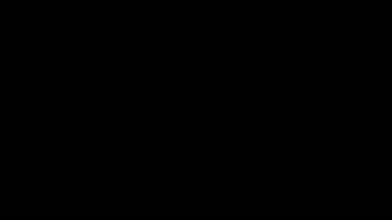

Shot description: The shot opens with a close-up view of a picturesque waterfall cascading down rock formations surrounded by lush greenery. The camera gradually pulls back, revealing the full grandeur of the towering waterfall set against the backdrop of a verdant rainforest. As the shot continues, the perspective shifts, providing a bird's-eye view of the majestic waterfall plunging into a serene pool below, with the crystal-clear waters reflecting the natural beauty of the surrounding landscape. The camera then pans across the tranquil pool, capturing the gentle ripples and the play of sunlight on the water's surface.

Shot transcript: 


SHOT 2/94: from 1001ms to 5171ms =======



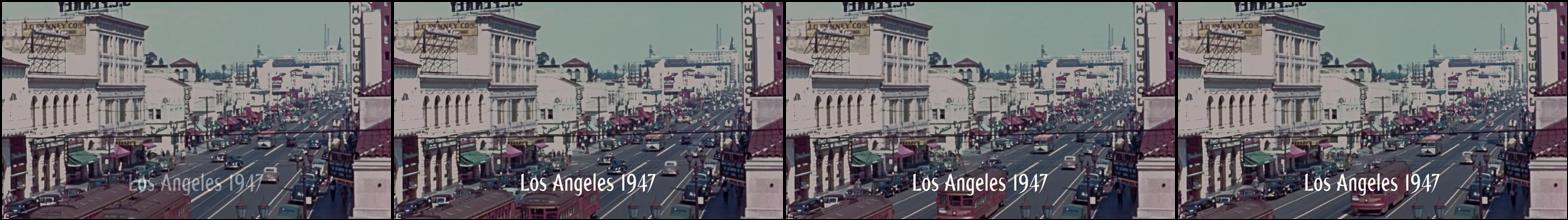

Shot description: The shot depicts a bustling street scene in Los Angeles in 1947. The frame shows a wide avenue lined with grand, ornate buildings and a multitude of vintage cars, trucks, and pedestrians filling the road and sidewalks. Despite being a historical scene captured decades ago, the street exudes a lively, urban atmosphere reminiscent of a major city in its prime. The richly detailed frame provides a vivid glimpse into the vibrant past of Los Angeles, frozen in time through this striking visual record.

Shot transcript: 


SHOT 3/94: from 5205ms to 9175ms =======



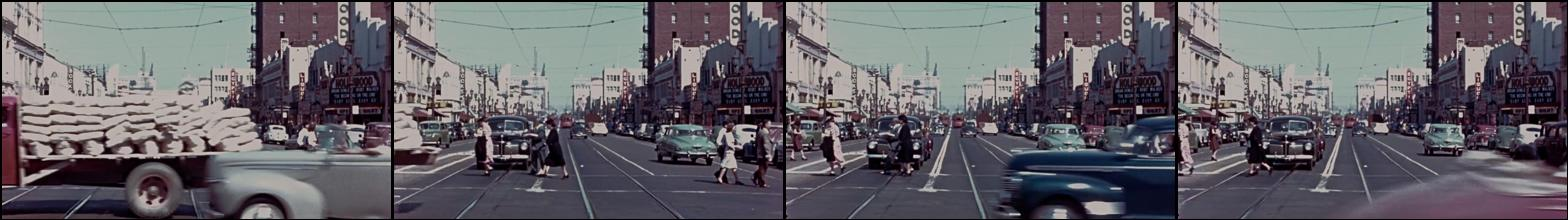

Shot description: The shot opens with a crowded city street lined with storefronts and billboards. Vintage cars from the mid-20th century fill the lanes, while pedestrians cross the road amidst the traffic flow. The camera pans smoothly to the right, capturing the bustling urban scene filled with movement and activity, characteristic of a lively metropolitan area in that era.

Shot transcript: 


SHOT 4/94: from 9209ms to 13079ms =======



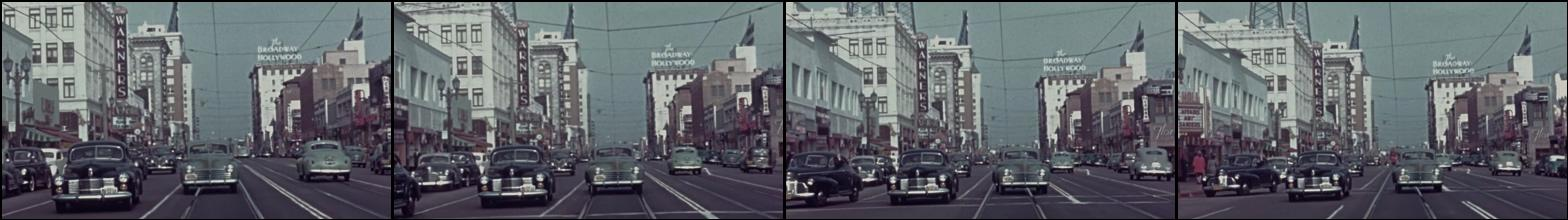

Shot description: The shot opens on a bustling city street lined with grand, historic buildings. Vintage cars from the mid-20th century fill the road, suggesting this is a scene from decades past. As the camera pans slowly to the right, following the flow of traffic, American flags hang from the edifices, hinting at a patriotic celebration or event taking place. The ornate architectural details and densely packed storefronts evoke a lively, urban atmosphere reminiscent of a major metropolitan area in its heyday. Despite the passage of time, the shot captures a vibrant snapshot of Americana from a bygone era.

Shot transcript: 


SHOT 5/94: from 13113ms to 15615ms =======



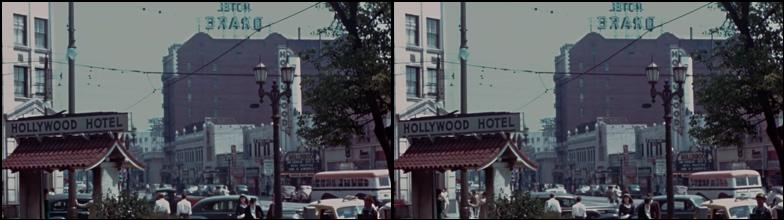

Shot description: The shot opens on a bustling city street in what appears to be a downtown area. Vintage cars and pedestrians line the sidewalks, with storefronts and signs indicating establishments like the "Hollywood Hotel" and "Ship Shap." The prominent marquee for the "Gem Theatre" dominates the center of the frame, suggesting this is likely a scene from a classic film set in an urban environment from a bygone era. As the shot progresses, the camera pans slowly to reveal more of the lively street scene, capturing the hustle and bustle of daily life in this vibrant locale.

Shot transcript: 


SHOT 6/94: from 15648ms to 17550ms =======



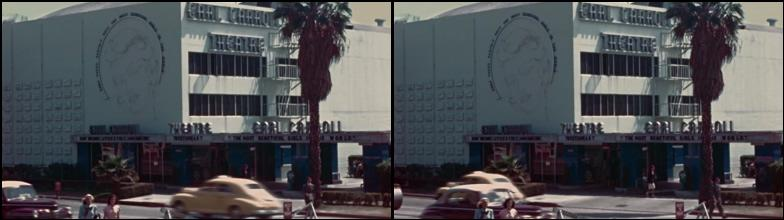

Shot description: The shot opens with an establishing view of a city street lined with palm trees and storefronts. Cars are parked along the curb, and pedestrians can be seen walking on the sidewalk. Suddenly, a large object comes crashing through one of the storefront windows, sending glass shattering onto the pavement. The angle then shifts to reveal it is a vehicle that has plowed straight through the building's facade, kicking up dust and debris in its wake amid the startled onlookers.

Shot transcript: 


SHOT 7/94: from 17584ms to 20120ms =======



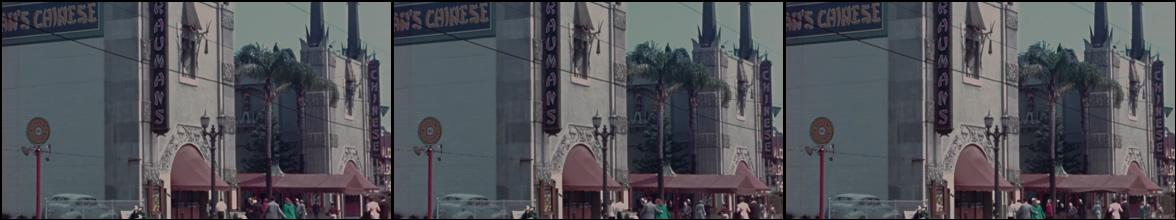

Shot description: The shot opens with a static view of the exterior facade of a Chinese restaurant or establishment, featuring an ornate entrance gate with Chinese architectural elements and signage prominently displaying "Lee's Chinese". Despite the static camera, the scene is enlivened by the presence of pedestrians walking in and out of the establishment, creating a sense of movement and activity. This establishing shot sets the context and locale for the ensuing narrative within this Chinese cultural setting.

Shot transcript: 


SHOT 8/94: from 20153ms to 23056ms =======



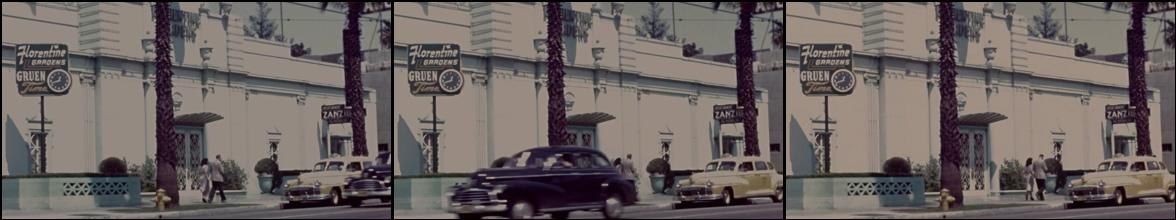

Shot description: The shot opens with a view of a street lined with palm trees in front of a large cream-colored building with an "El Rancho Vegas" sign above the entrance. Vintage cars from the 1950s era are parked in front, setting the scene in that time period. As the camera pans to the right, a black classic car drives into the frame, adding motion and life to the nostalgic streetscape. The shot effectively captures the vibrant atmosphere of an iconic location from mid-20th century Las Vegas through the architectural details, period vehicles, and cinematic camera movement.

Shot transcript: 


SHOT 9/94: from 23089ms to 29696ms =======



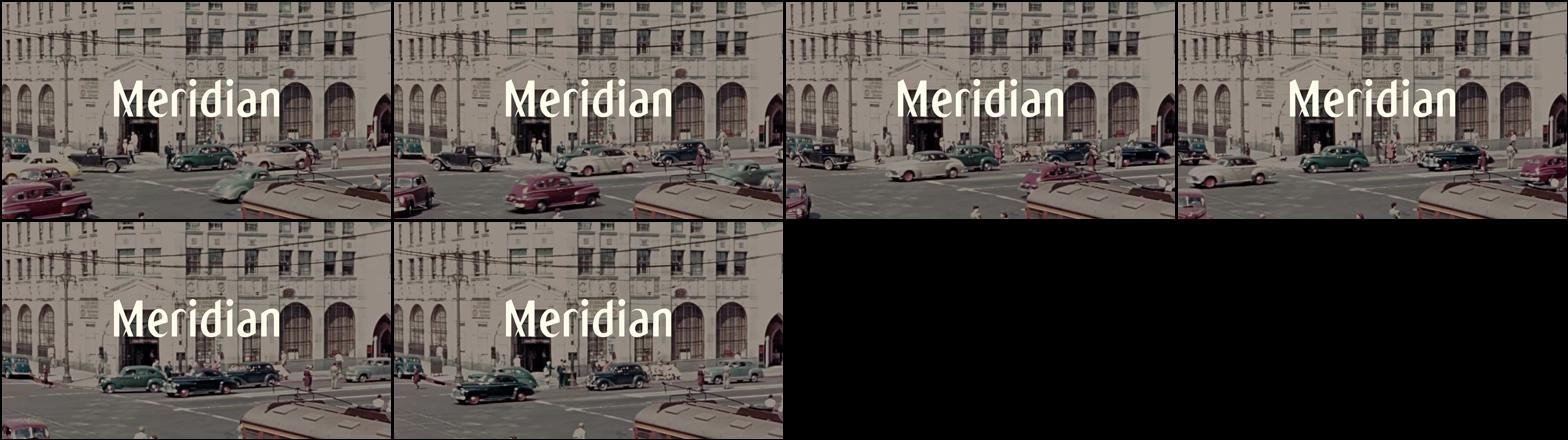

Shot description: The video shot opens with a street view of a busy urban area, featuring an ornate stone building with arched windows and the word "Meridian" prominently displayed above the entrance. The scene is populated with various vehicles, including classic cars from what appears to be the mid-20th century era, parked along the street in front of the building. Pedestrians can be seen walking along the sidewalks, adding to the lively atmosphere. As the shot progresses, the camera appears to pan slightly, causing a subtle shift in perspective, while the overall composition remains relatively static, maintaining a focused view on the historic edifice and the bustling streetscape surrounding it.

Shot transcript:  So these guys just disappeared.; 


SHOT 10/94: from 29729ms to 36069ms =======



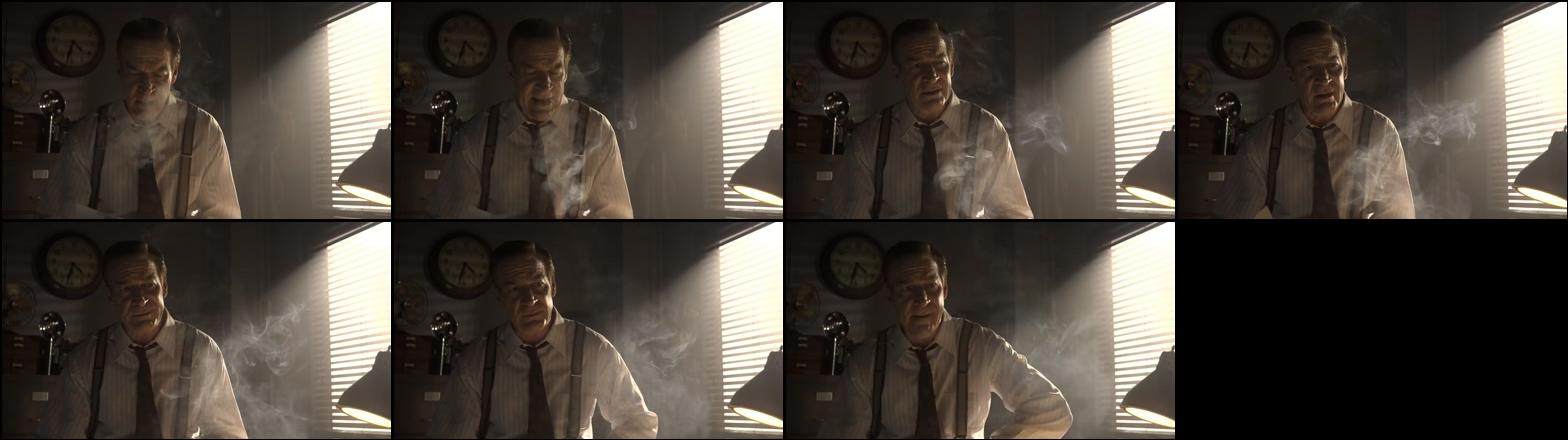

Shot description: The video shot depicts a man wearing a white shirt and tie in a dimly lit room, likely an office or study setting. He is standing behind a desk, smoking a cigarette as plumes of smoke waft around him. The framing and lighting create a tense, film noir-esque atmosphere. The man's stern expression and the lingering smoke suggest a contemplative or uneasy mood, potentially building suspense or setting up a dramatic moment within a larger narrative context.

Shot transcript:  Yeah. All that stretch of road right above El Matador.; 


SHOT 11/94: from 36102ms to 45178ms =======



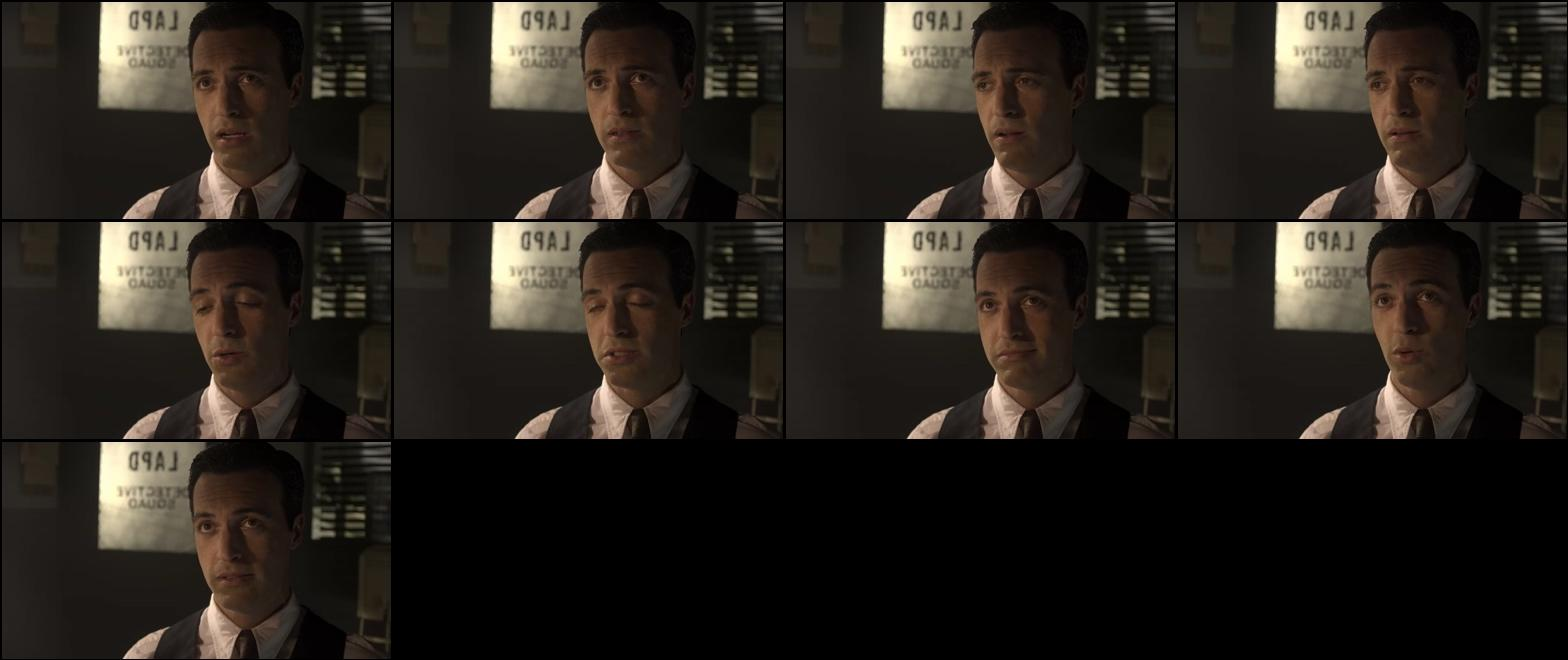

Shot description: The shot depicts a man in a suit staring directly at the camera with a serious, slightly tense expression. The background is dark, with the word "FBI" visible behind him in reverse, suggesting he is being filmed through a two-way mirror during an interrogation or investigation. The sequence of nearly identical frames implies this is a prolonged, unwavering gaze, perhaps meant to convey the intensity or gravity of the situation the man finds himself in. The tight framing and lack of movement create a sense of tension and focus on the man's stern demeanor.

Shot transcript:  You know it with the big rock.;  Yeah, Mickey Cohen used to take his associates out there.;  Bid him a bond voyage.; 


SHOT 12/94: from 45211ms to 48615ms =======



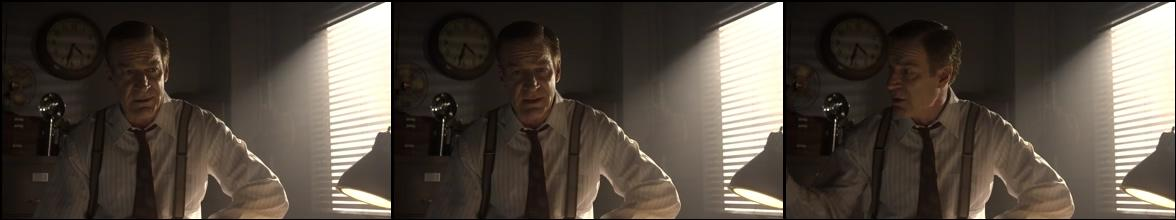

Shot description: A man in a suit and tie is sitting at a desk, speaking into a microphone. The scene is dimly lit, and there are blinds or window shades visible behind him, suggesting an office or workplace setting. His expressions remain fairly neutral as he continues speaking, potentially recording an announcement, interview or dictation of some kind. The framing and staging give the impression of a serious, formal tone to the scene.

Shot transcript:  Not at this time.; 


SHOT 13/94: from 48648ms to 54954ms =======



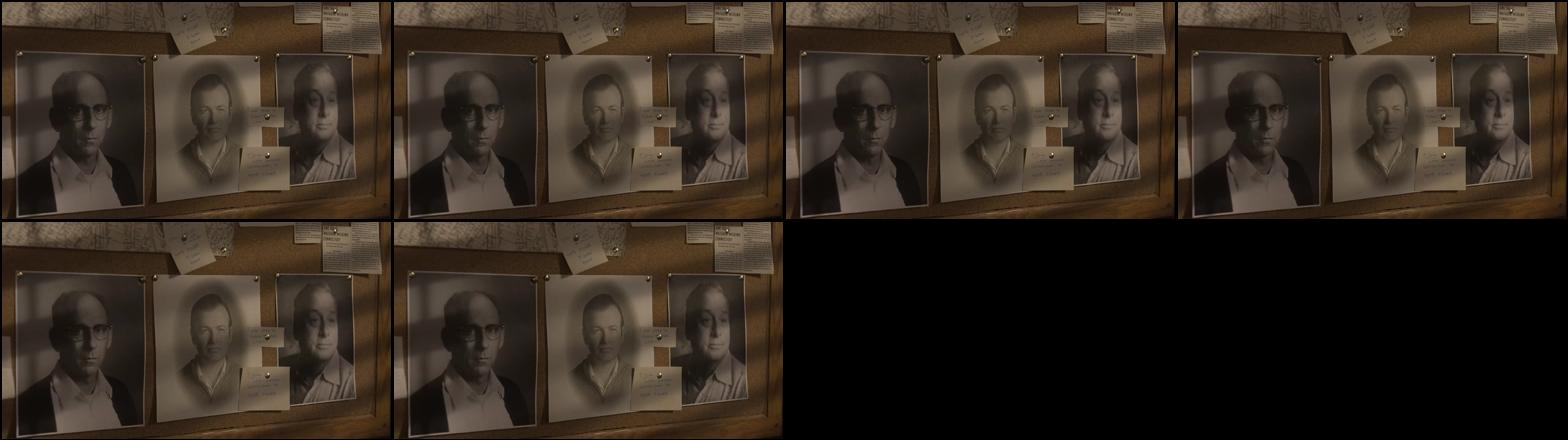

Shot description: The shot begins with rows of old sepia-toned portraits hanging on a wall, depicting somber-looking men and women from a bygone era. The camera slowly pans across these portraits, lingering on each one, as if studying the faces frozen in time. The lighting casts shadows that accentuate the texture and age of the photographs. As the camera reaches the end of the row, the frame gradually fades to black, leaving an eerie and melancholic atmosphere, inviting the viewer to reflect on the fleeting nature of life and the enduring power of memories captured in these timeless portraits.

Shot transcript:  One of these guys was a school teacher.;  Next guy, he sold insurance and the last guy, he was retired.; 


SHOT 14/94: from 54988ms to 58525ms =======



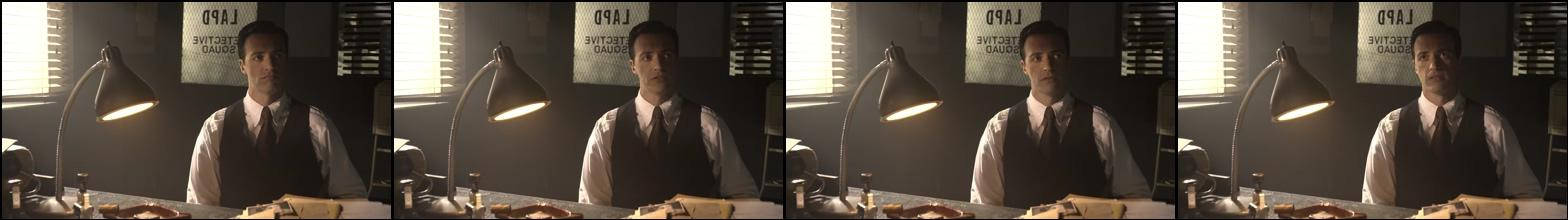

Shot description: The shot opens with a man dressed formally in a suit and tie, sitting at a desk in what appears to be an office or workplace setting. The room is dimly lit, with a distinctive lamp illuminating his workspace. Behind him, a glass panel or window bears the repeated text "744", suggesting this could be related to an office number or floor level. The man has a pensive, focused expression as he seemingly works at his desk, likely reviewing documents or files spread out before him. The static framing and his unchanging demeanor imply this is a brief, establishing shot that sets the scene and introduces this character in their professional environment.

Shot transcript:  Mm mm I mean, I check them all out.; 


SHOT 15/94: from 58558ms to 72005ms =======



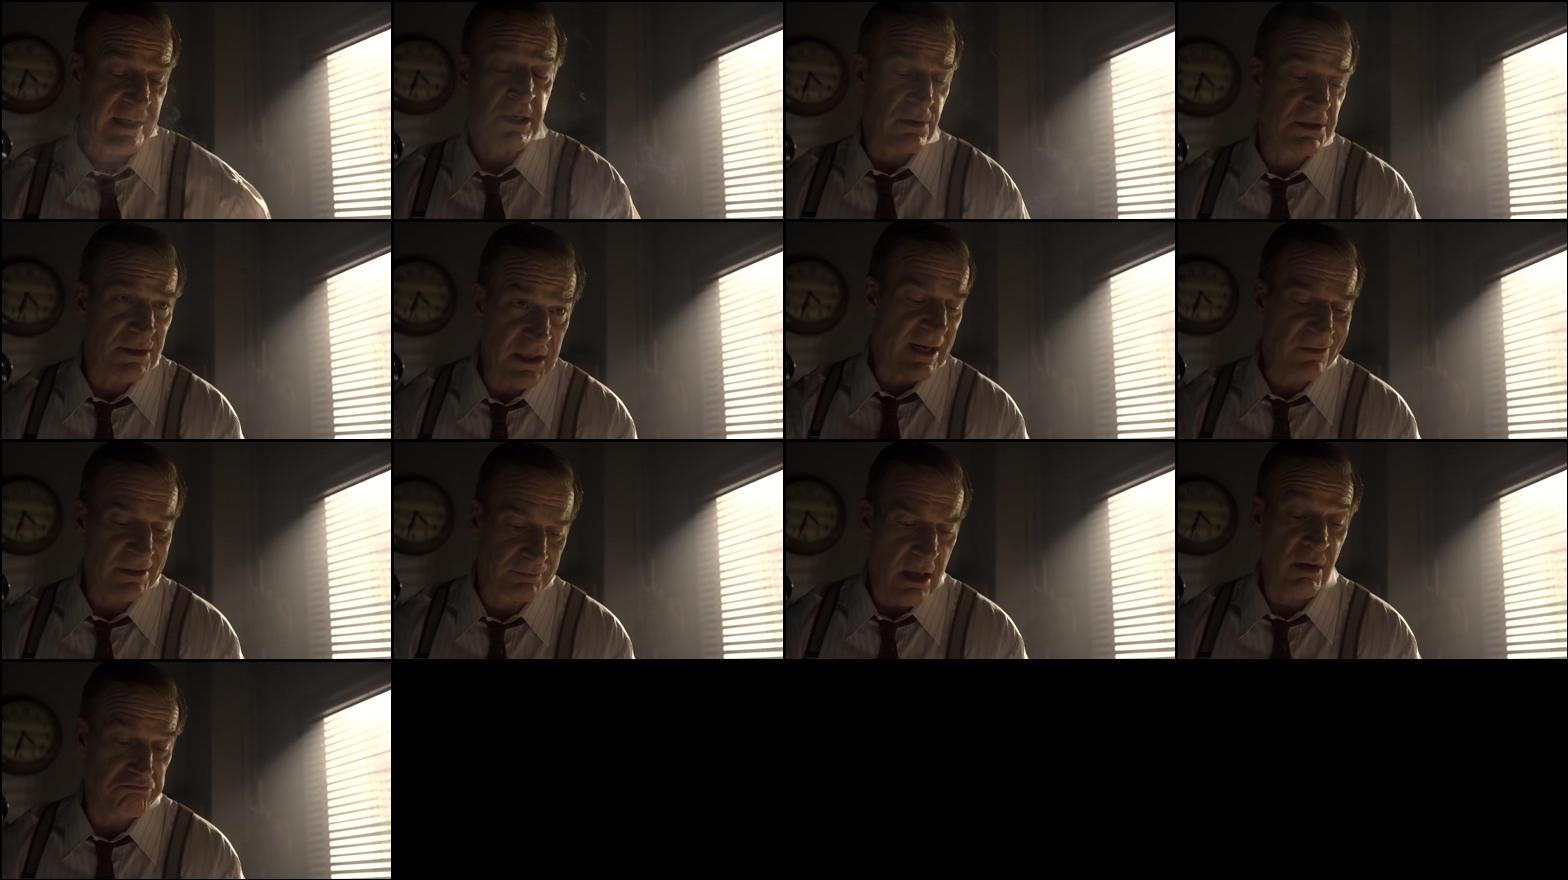

Shot description: The sequence depicts a tight close-up shot of an elderly man wearing a suit and tie. He appears to be in a dimly lit room or office setting, with window blinds visible behind him. The man has a stern, intense expression on his face and remains motionless throughout the frames, suggesting a dramatic or tense moment captured within a larger scene or narrative. The static framing and lack of movement create a sense of suspense or buildup, leaving the viewer to speculate about the character's inner thoughts or the events unfolding around him.

Shot transcript:  Mm mm I mean, I check them all out.;  There's no criminal records, no association, any criminal organizations.;  One of the guys was arrested for drunk driving a long time ago.;  They were all divorced.; 


SHOT 16/94: from 72038ms to 76009ms =======



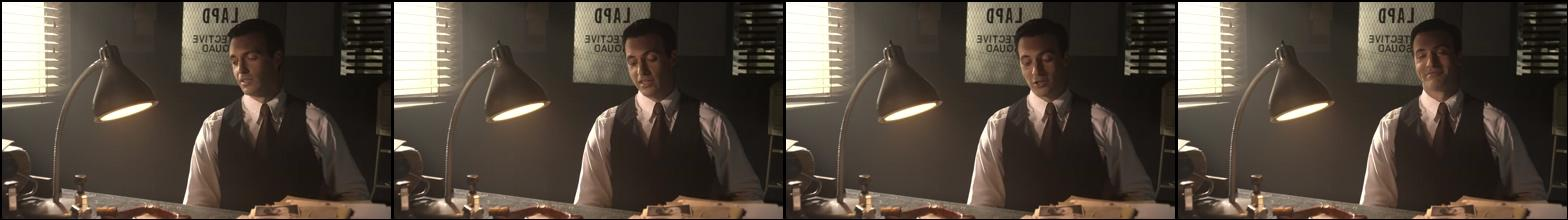

Shot description: In a dimly lit office setting, a man dressed in a suit and tie is seen sitting at a desk, appearing focused and perhaps working late into the night. The frame captures a sense of intensity and dedication, with the singular desk lamp illuminating his workspace, contrasted against the shadows surrounding him. This shot sets the stage for a narrative centered around a driven professional, immersed in their work, possibly grappling with high-stakes challenges or crucial tasks that demand their unwavering attention and commitment.

Shot transcript:  Well, in that case, maybe you don't want to go out there, boss.; 


SHOT 17/94: from 76042ms to 80313ms =======



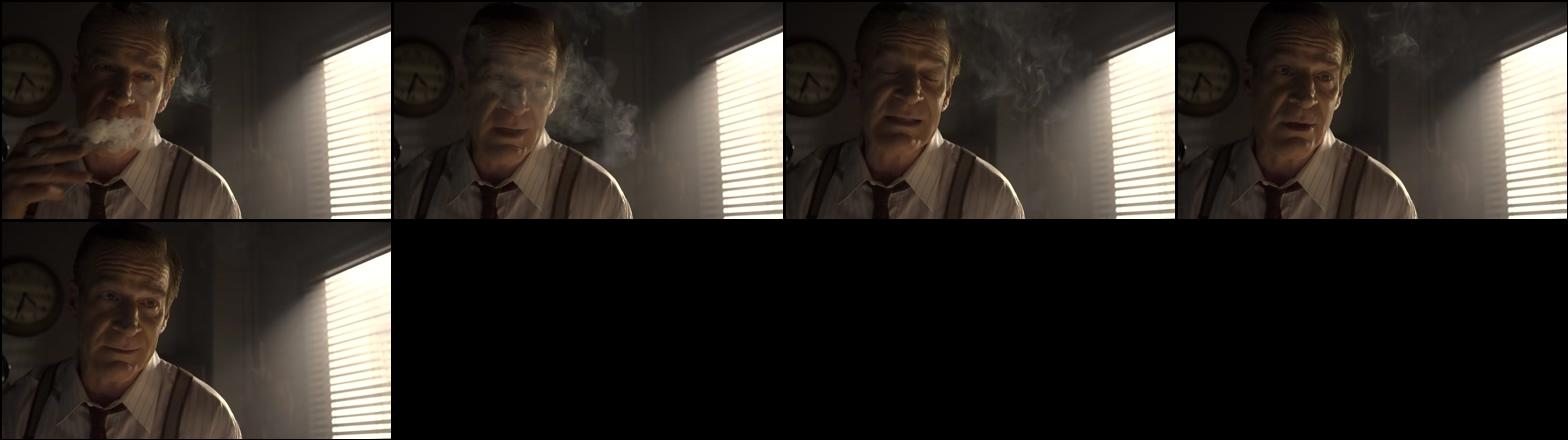

Shot description: The shot opens with a close-up of an elderly man wearing a suit and tie, puffing on a cigarette in a dimly lit room. Blinds are visible in the background, casting shadowy horizontal lines across his face. The man has a pensive, almost forlorn expression as tendrils of smoke drift upwards from the cigarette held in his hand. The camera lingers on this melancholic portrait for several frames, allowing the viewer to study the weathered features and world-weary countenance of the solitary figure.

Shot transcript:  What are you a comedian?;  If that's the case? You sure don't want to go out there?; 


SHOT 18/94: from 80347ms to 86052ms =======



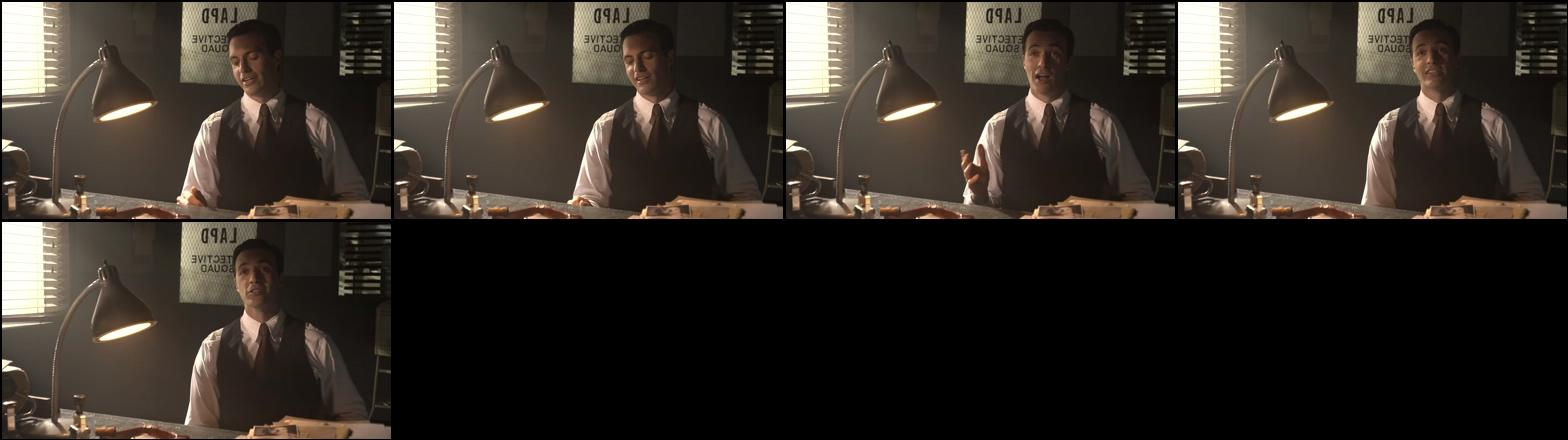

Shot description: A man in a suit and tie sits at a desk in a dimly lit office, illuminated by a lamp. The office has a grated window in the background, suggesting it may be a police station or similar government building. The man appears to be working intently, his gaze fixed on something off-screen. The shot remains static, focusing on the man's serious expression and the mood of the gritty office setting.

Shot transcript:  Yeah. Look, I know what happened. All right.;  They go out to the rock. They take that long cold, slow swim to China suicide.; 


SHOT 19/94: from 86086ms to 87320ms =======



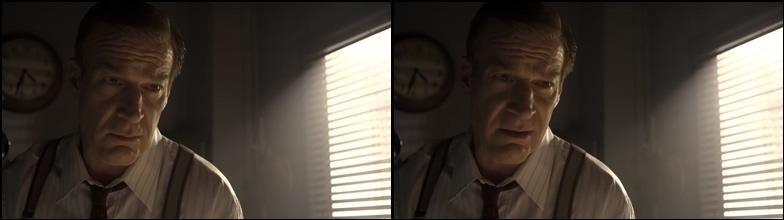

Shot description: The shot opens with a close-up of an older man wearing a suit and tie, his face somber and seemingly troubled as he gazes off-camera. The dimly lit setting and the blinds in the background suggest an office or formal indoor space. As the camera holds steady on his pensive expression, a sense of tension or unease builds, leaving the viewer to ponder what weighs heavily on this man's mind or what difficult situation he might be grappling with.

Shot transcript: 


SHOT 20/94: from 87354ms to 89589ms =======



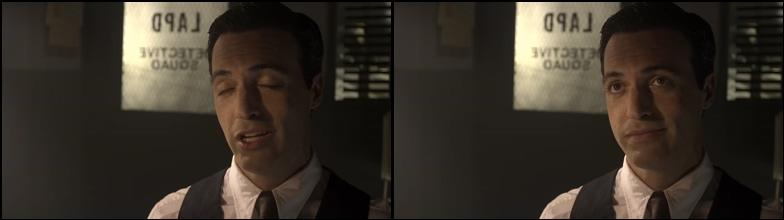

Shot description: A man in a suit stands in what appears to be a dimly lit, industrial setting with metal walls or surfaces behind him. The camera slowly pushes in towards his face, as he maintains a serious, contemplative expression. He seems to be waiting or pondering something of importance in this tense, gritty environment.

Shot transcript:  It's been known to happen out there.; 


SHOT 21/94: from 89622ms to 99866ms =======



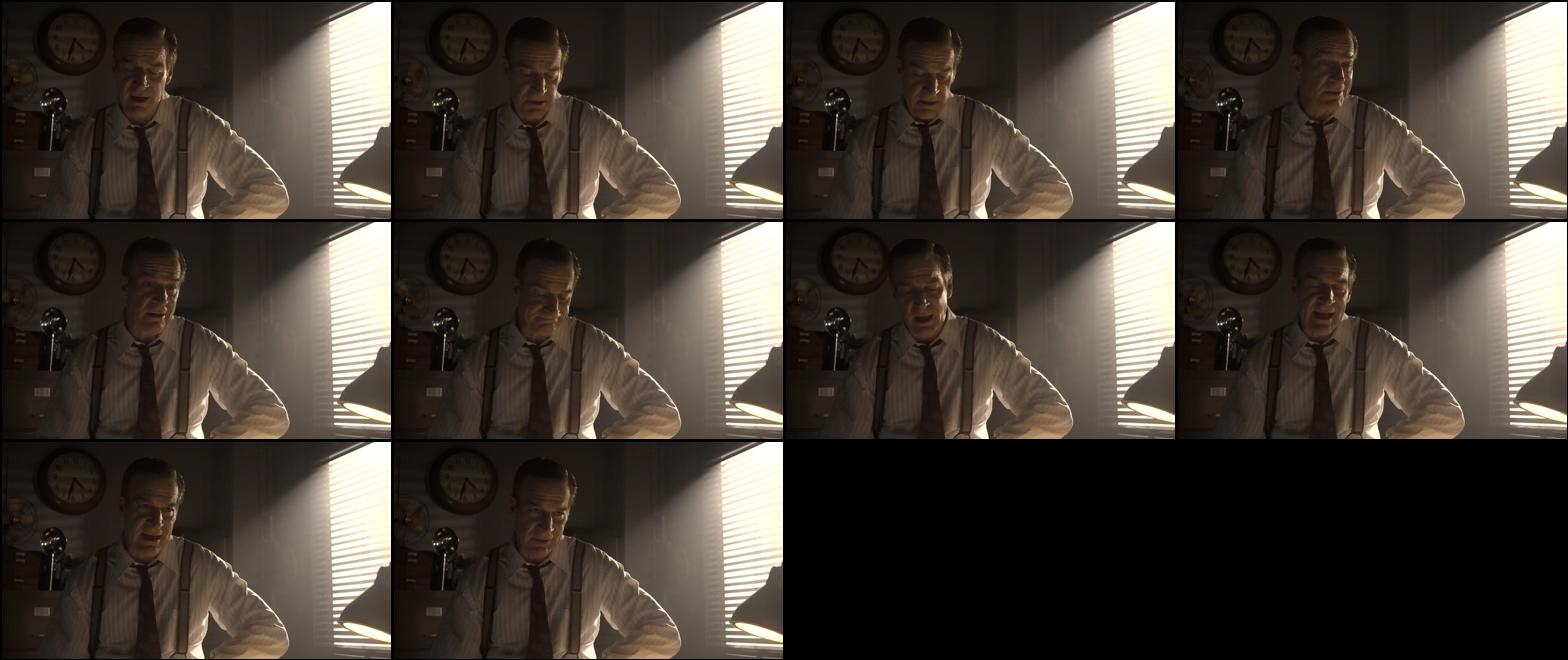

Shot description: The shot opens with a man wearing a suit and tie sitting at a desk in what appears to be an office setting. He has a serious, contemplative expression on his face as he gazes downward, seemingly deep in thought. The framing remains tight on his upper body and face throughout the sequence of images. The lighting casts dramatic shadows, intensifying the solemn mood. As the images progress, the man's facial expression subtly shifts, conveying a range of emotions - from pensive to troubled to resolute - though he maintains an overall somber demeanor. The consistent visual framing and lack of significant movement suggest this is a powerful cinematic moment focused on the man's internalized emotional state and inner conflict.

Shot transcript:  Uh Not this time.;  Well, for one thing, there's no bodies and somebody was out there the day the last guy disappeared.; 


SHOT 22/94: from 99899ms to 105038ms =======



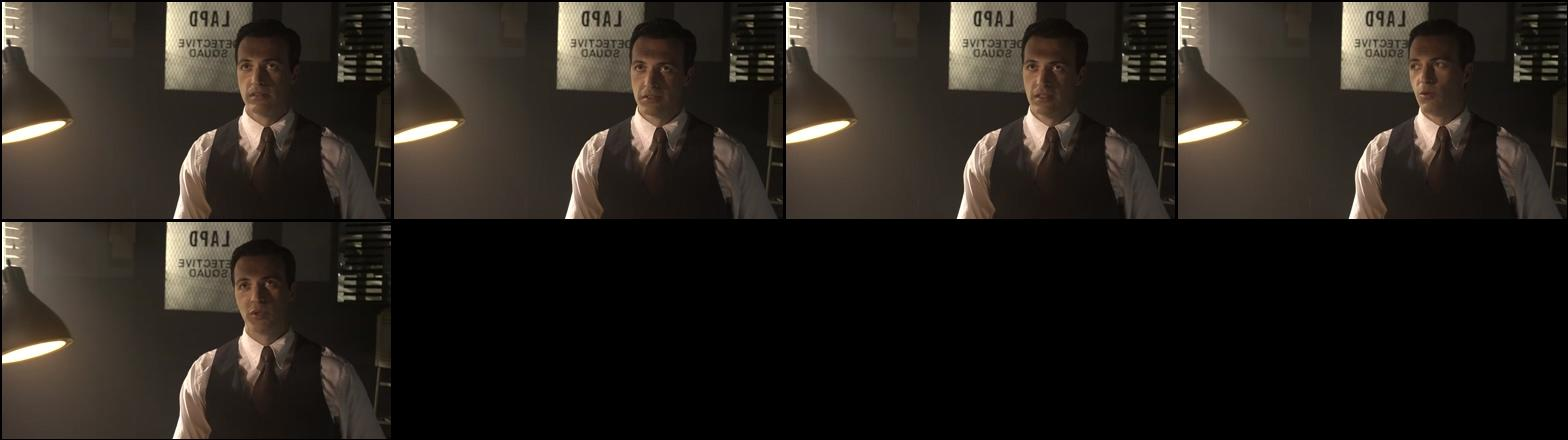

Shot description: In this video shot, we see a man in a formal suit and vest standing motionless in what appears to be a dimly lit office or study. The setting has a vintage or retro aesthetic, with a lamp and signage bearing the word "Pago" visible in the background. The man's expression is neutral, almost stoic, as he gazes ahead unflinchingly. Despite the lack of movement or action, there is a sense of tension or intensity in the man's demeanor, suggesting that something significant or dramatic is about to unfold.

Shot transcript:  A witness, a witness. Why didn't you say that in the first place because I thought the guy was nuts what he said.; 


SHOT 23/94: from 105071ms to 108608ms =======



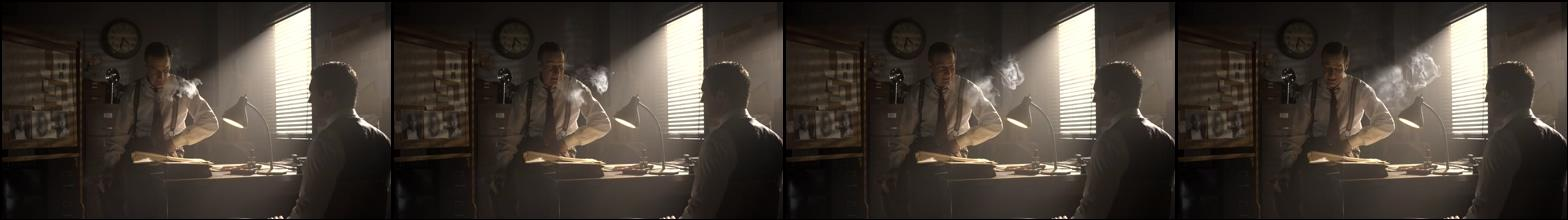

Shot description: The scene opens in a dimly lit office or interrogation room. A man in a suit is seated at a desk, smoking a cigarette, while another man stands facing him, his back to the camera. The walls are adorned with framed posters or documents, and venetian blinds filter the light, casting harsh shadows across the room. The tense atmosphere and staging suggest an intense conversation or interrogation is about to take place between the two men, setting the stage for a dramatic and suspenseful sequence.

Shot transcript:  A witness, a witness. Why didn't you say that in the first place because I thought the guy was nuts what he said.; 


SHOT 24/94: from 108641ms to 110610ms =======



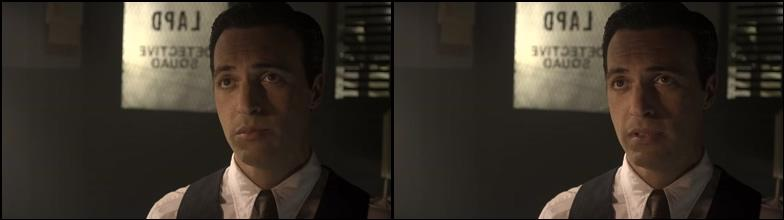

Shot description: This shot captures a close-up view of a man's face in a dimly lit environment. He appears to be wearing a suit and tie, suggesting a formal or professional setting. The man has an intense, serious expression on his face, his eyes fixated straight ahead. In the background, the words "VALA/JSI" can be seen reversed, likely indicating that the scene is reflected in a mirror or glass surface. The shot conveys a sense of tension and focus, potentially leading into an important or dramatic moment within the narrative.

Shot transcript:  But now you believe him, I had him checked out too. Guy's a goddamn eagle scout.; 


SHOT 25/94: from 110643ms to 119052ms =======



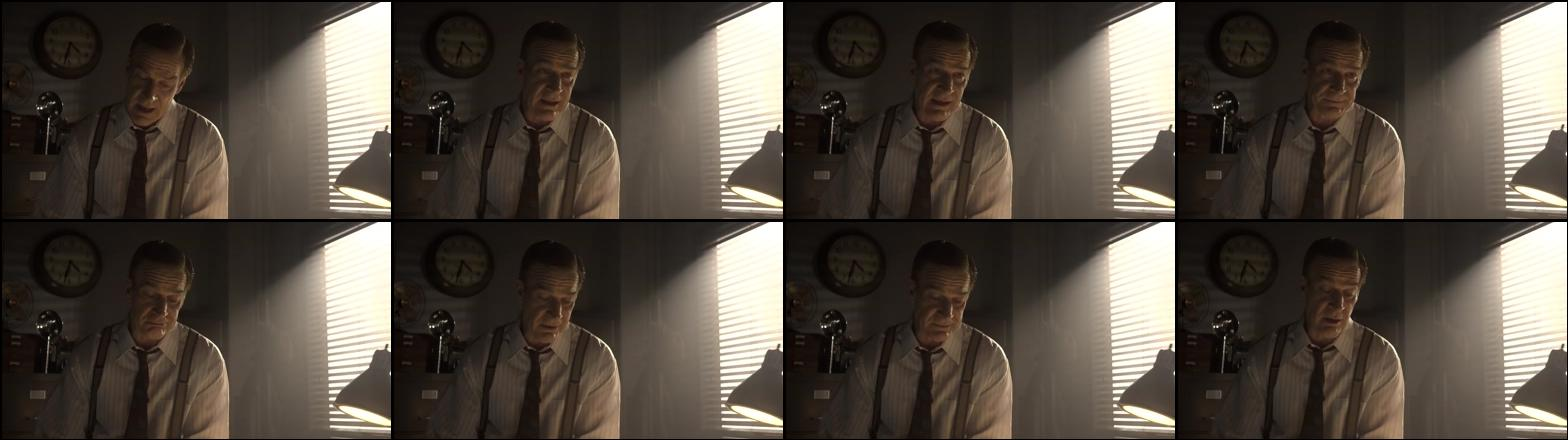

Shot description: The shot opens with a man in a suit and tie sitting at a desk in an office setting, his face partially illuminated by a desk lamp. He appears to be in deep thought or contemplation, with a pensive expression on his face. The blinds behind him are drawn, creating a sense of isolation and privacy within the office space. Throughout the shot, the man remains still, allowing the audience to study his features and body language. The static camera angle and lack of movement contribute to a palpable tension and suspense, leaving the viewer to wonder about the character's inner thoughts and the potential unfolding of events.

Shot transcript:  But now you believe him, I had him checked out too. Guy's a goddamn eagle scout.;  So, now, now I don't know what to believe, but I know, I don't want to believe him.; 


SHOT 26/94: from 119085ms to 121221ms =======



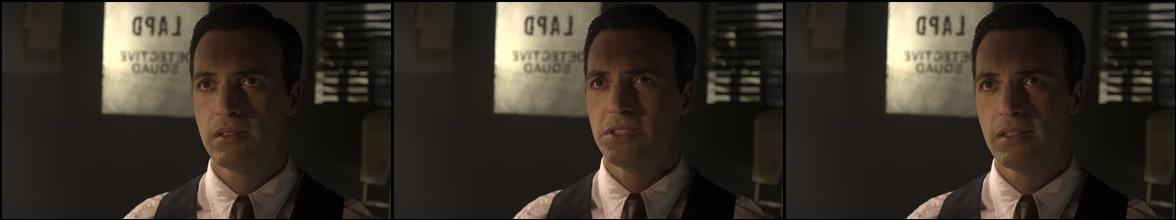

Shot description: The shot opens with a close-up of a man's face, revealing a serious, almost grim expression. He is well-dressed in a suit and tie, seemingly in a professional setting. The background is slightly blurred, but one can make out the word "LAPD" illuminated behind him, indicating he may be a detective or police officer. The framing and man's demeanor suggest a tense, dramatic scene is about to unfold, likely related to a crime or investigation within the context of a police procedural or thriller narrative.

Shot transcript:  What did he say? He said he was out there walking his dog along the bluffs above Matador. Right?; 


SHOT 27/94: from 121254ms to 133366ms =======



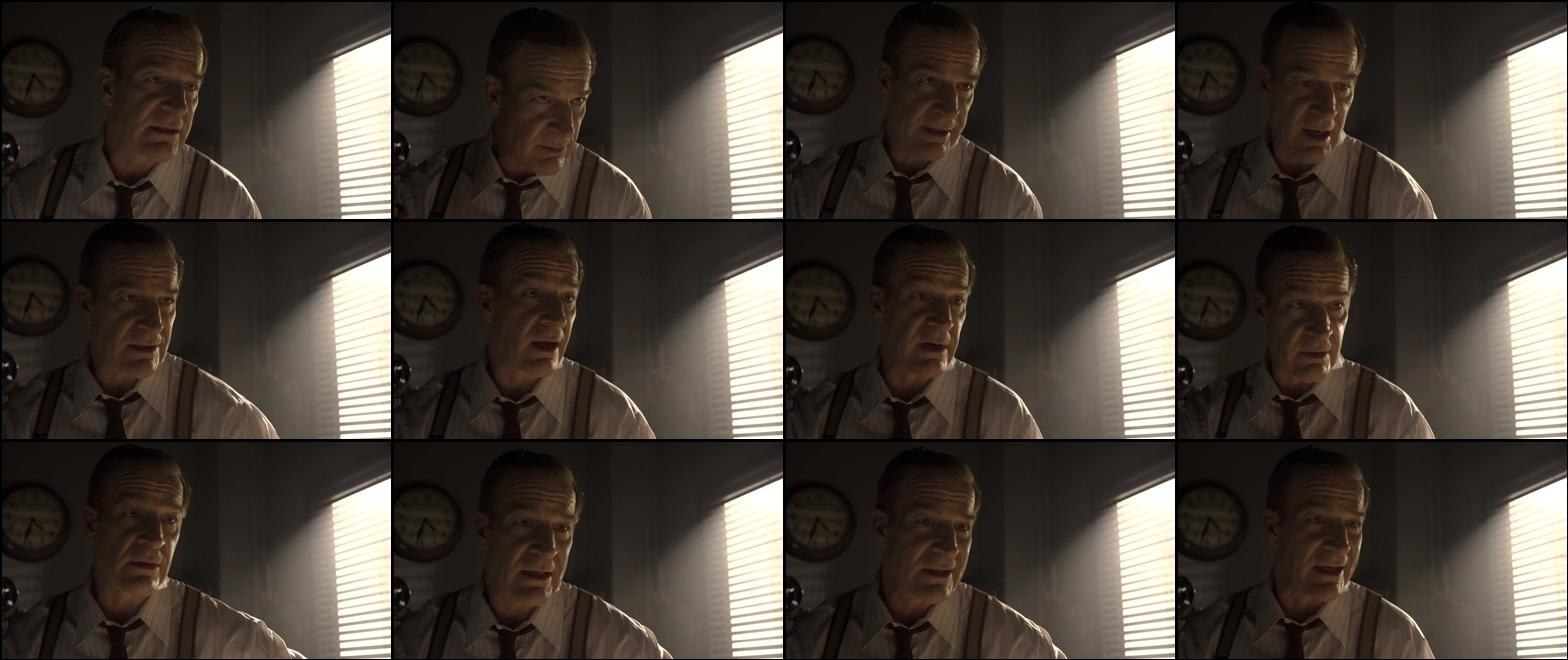

Shot description: In this shot, an older man wearing a suit and tie is shown in a dimly lit room, likely an office or study setting. The camera focuses solely on his stern, intense facial expression as he stares directly into the lens with furrowed brows and a tight-lipped frown. The unchanging framing and his unwavering gaze across multiple frames create a sense of tension and gravitas, suggesting an impactful or pivotal moment within a dramatic narrative context.

Shot transcript:  What did he say? He said he was out there walking his dog along the bluffs above Matador. Right?;  And he looks down at the beach at that huge rock.;  You know, the one that's separated from the mainland, right where the ocean meets the shore.;  His words looks like a, like a mythic sea creature. You know that one.; 


SHOT 28/94: from 133400ms to 137303ms =======



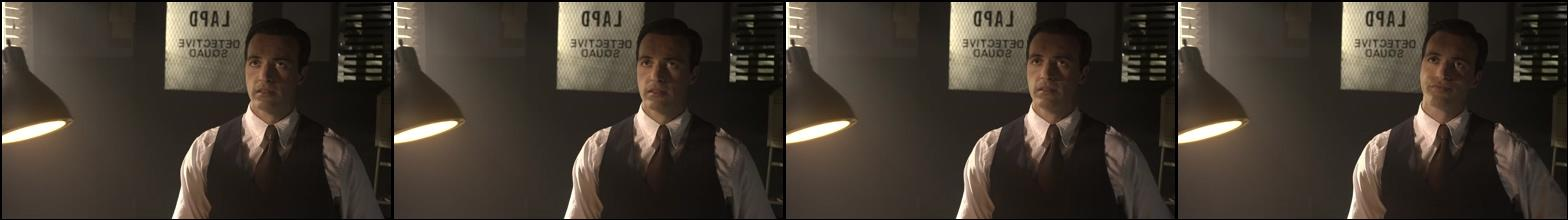

Shot description: The shot opens with a man in a suit and vest standing in a dimly lit room, facing the camera with a serious expression. Behind him, a neon "ACME" sign is prominently displayed on the wall, suggesting a connection to the fictional Acme Corporation. The man's intense gaze and the noir-esque lighting create a tense, mysterious atmosphere, hinting at potential intrigue or conflict to come in this narrative setting.

Shot transcript:  His words looks like a, like a mythic sea creature. You know that one.; 


SHOT 29/94: from 137337ms to 145612ms =======



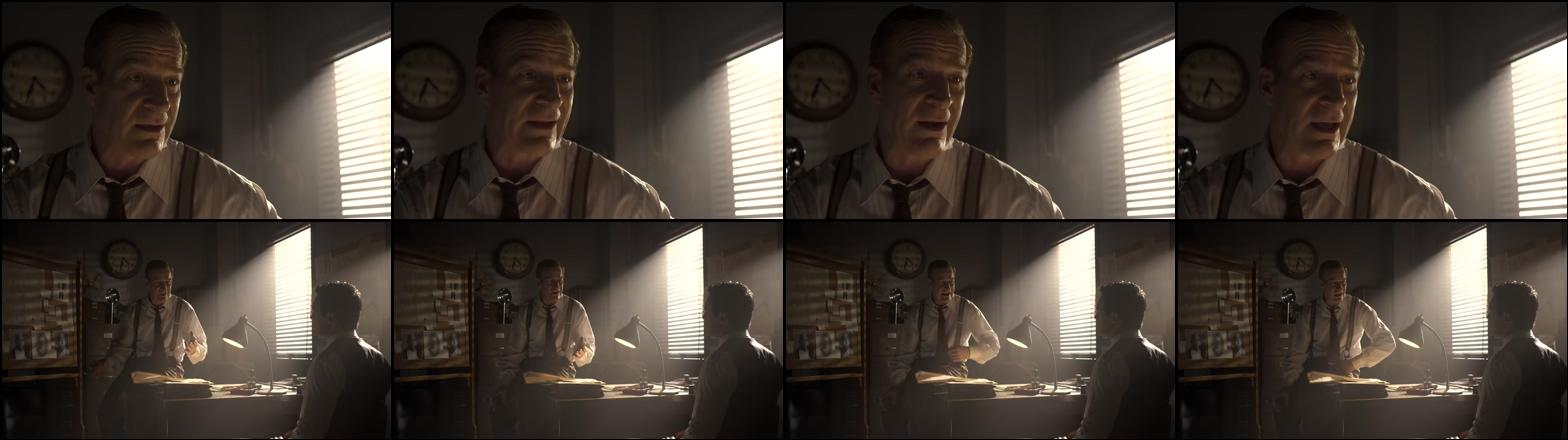

Shot description: In an interrogation room setting, a stern-looking police officer sits across a desk from a suspect being questioned. The dimly lit room has a clock on the wall and evidence boards visible in the background. The officer leans forward, intensely questioning the suspect, who remains still and silent, creating a tense atmosphere as the interrogation unfolds.

Shot transcript:  Anyway, he looks down there and there's a guy who's on top of that rock and he's thinking to himself, how the hell do you get up there?;  You gotta be a goddamn mountain climber.; 


SHOT 30/94: from 145645ms to 165632ms =======



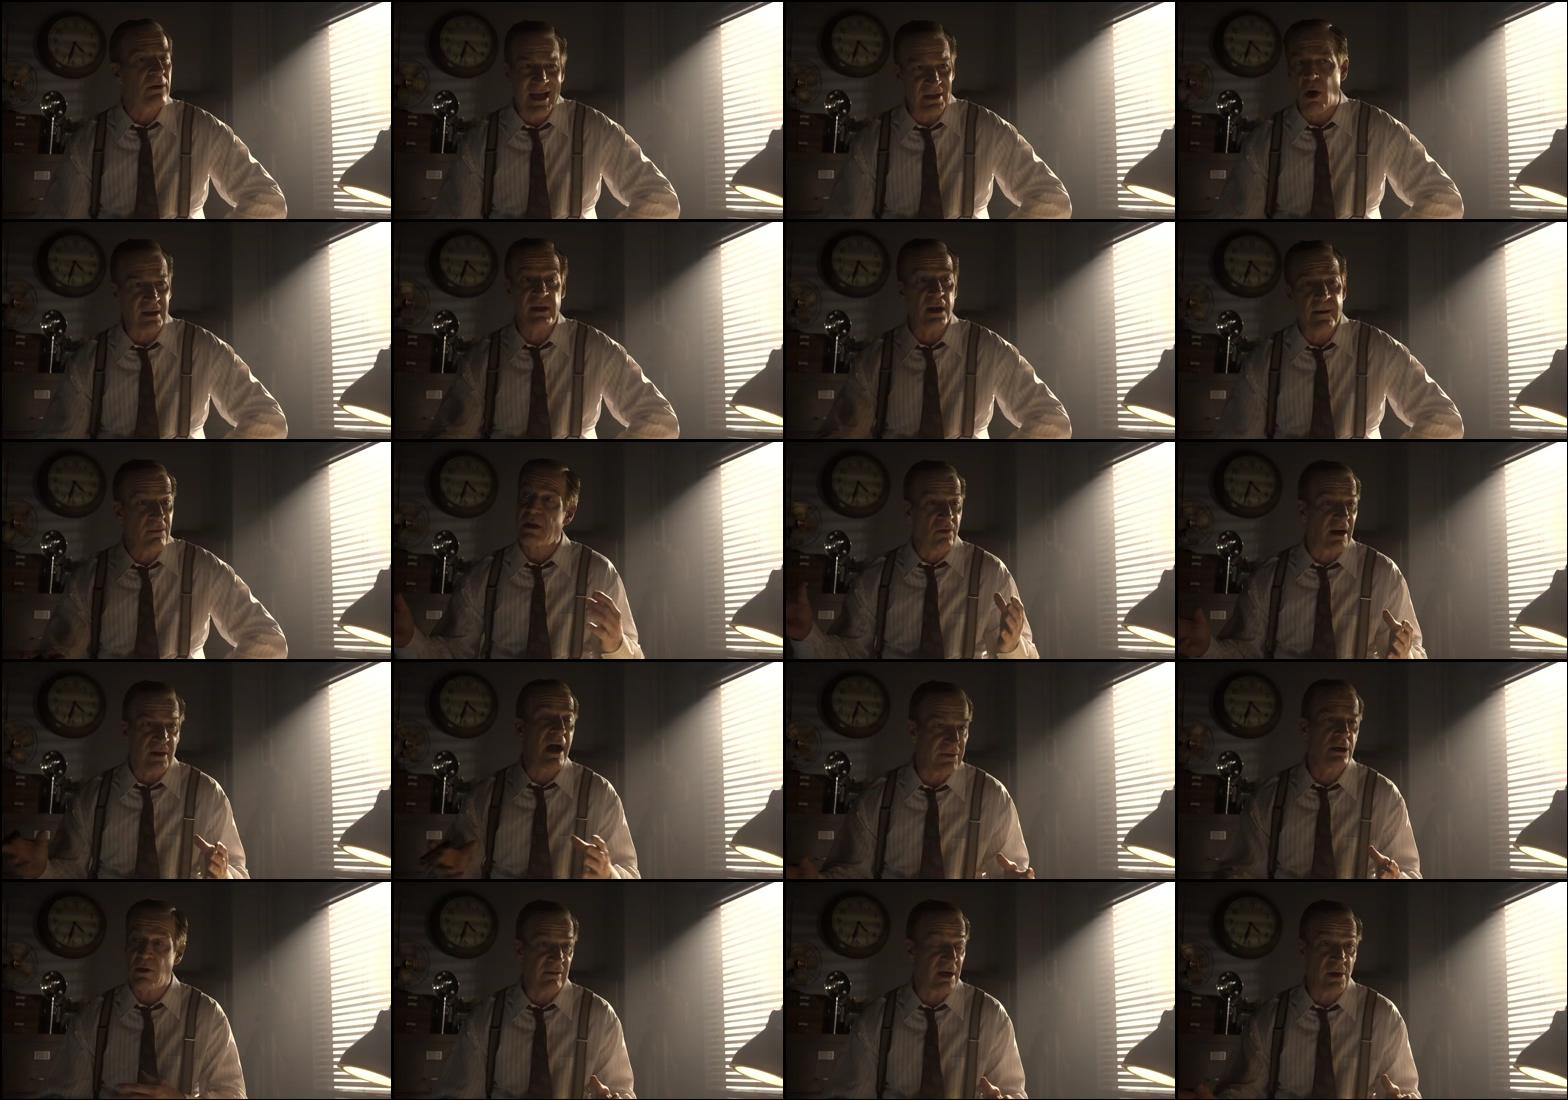

Shot description: The shot opens with a middle-aged man in a crisp white shirt and tie, seated at a desk in what appears to be an office setting. A vintage microphone sits in front of him, suggesting he may be about to give a speech or make an announcement. The man has a serious, almost stern expression on his face as he looks directly into the camera. Behind him, a wall clock and the angled window blinds provide subtle details about the environment. As the shot progresses, the man's stoic demeanor remains unchanged, building a sense of tension and anticipation for whatever message he is about to deliver.

Shot transcript:  But more importantly, he says the guy's acting really funny.;  He's looking all over that rock like he's looking for something or someone at that very moment.;  He says it got really, really dark really fast and bombs start going off in the air, thunder and lightning weather like he'd never seen before coming from.; 


SHOT 31/94: from 165665ms to 168335ms =======



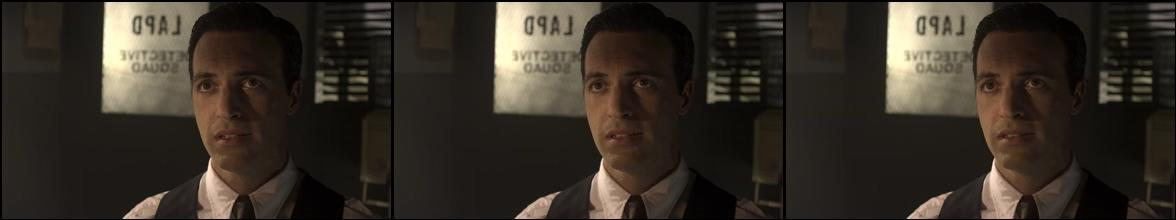

Shot description: A man in a suit looks sternly at the camera against a backdrop of illuminated vertical text reading "LAPD". The shot is framed in a close-up, focusing solely on the man's intense, unwavering gaze, suggesting he is a figure of authority, likely a police officer associated with the Los Angeles Police Department. The dimly lit, dramatic lighting and tight framing create a tense, gritty atmosphere befitting a crime drama or police procedural narrative.

Shot transcript:  He didn't know where when he looks back at the rock, the guy's gone, but there's a woman there, she's in a white dress, alabaster skin, his words.; 


SHOT 32/94: from 168368ms to 175575ms =======



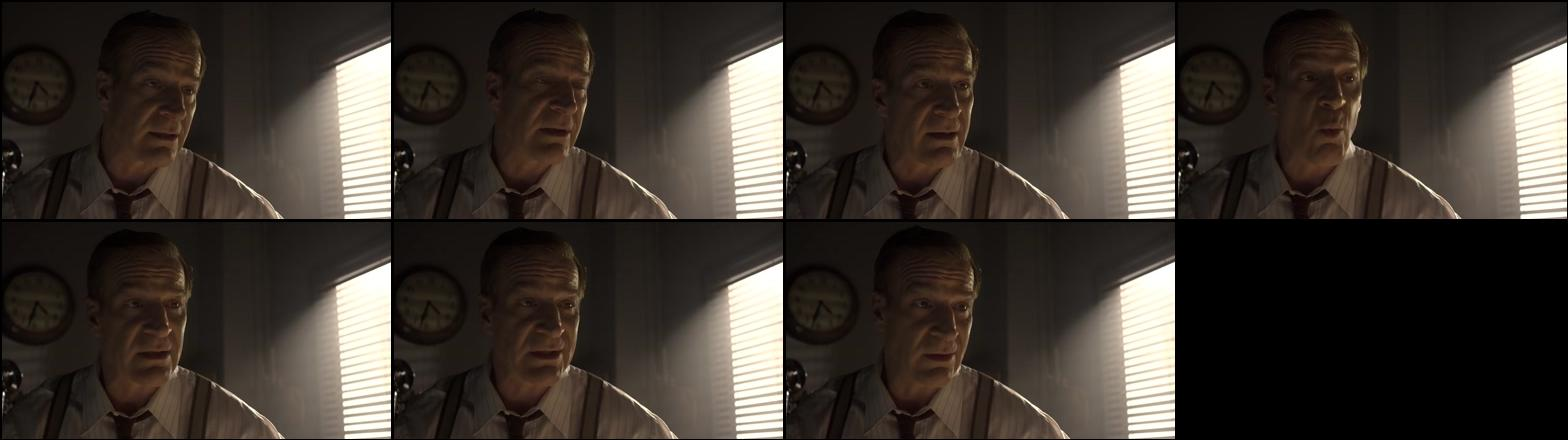

Shot description: An elderly man in a suit and tie is seated in a dimly lit room with venetian blinds behind him. The camera is trained on his stoic, intense facial expression as he stares directly ahead, seemingly lost in thought or grappling with some inner conflict or realization. The tight framing and stillness of the shot suggest a tense, dramatic moment frozen in time, inviting the viewer to ponder the man's unspoken contemplations or the weight of the situation he finds himself in.

Shot transcript:  He didn't know where when he looks back at the rock, the guy's gone, but there's a woman there, she's in a white dress, alabaster skin, his words.; 


SHOT 33/94: from 175608ms to 185885ms =======



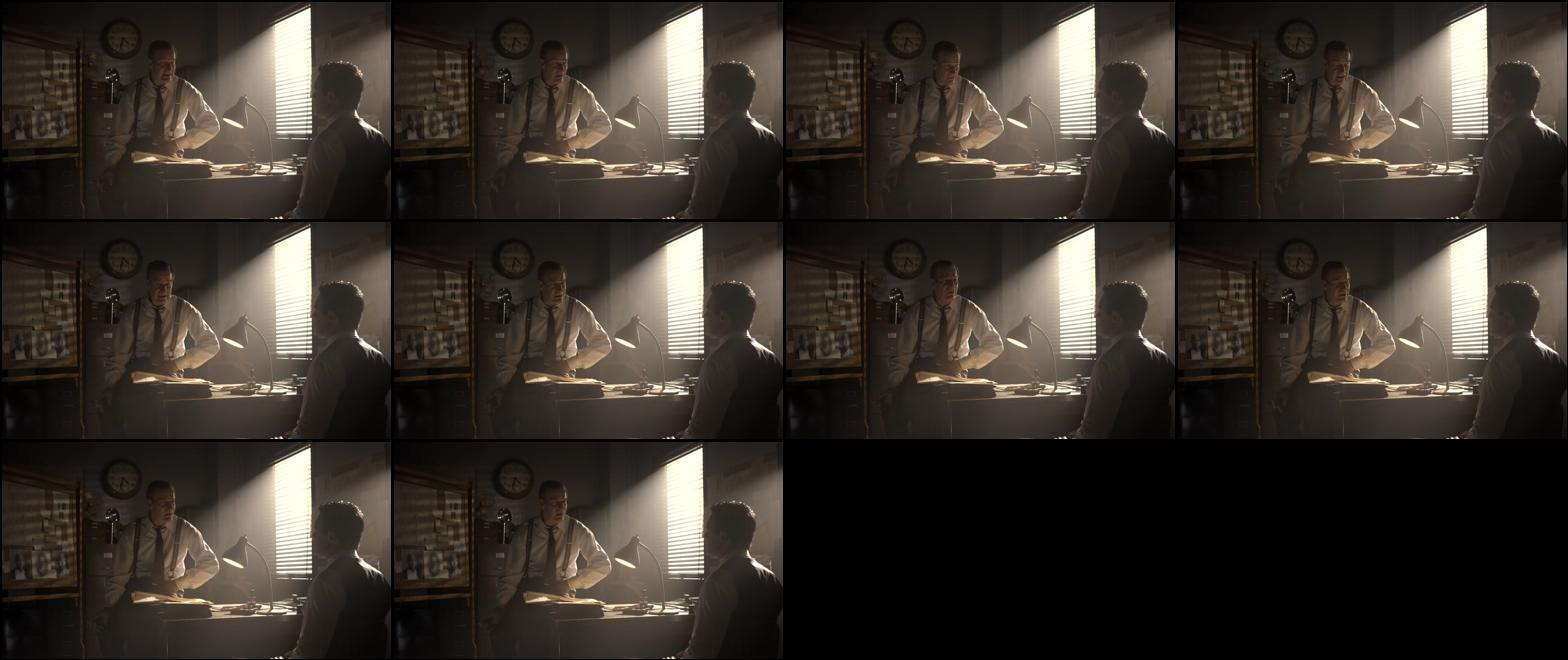

Shot description: The shot depicts an intense interrogation scene in what appears to be a police station. A male suspect, seen from behind, is sitting across a desk from a intimidating detective. The detective leans forward, gesticulating forcefully, while the suspect remains still and silent. The dimly lit room has blinds casting harsh shadows, adding to the tense atmosphere. Wanted posters and files on the wall suggest this is likely an interrogation room for serious crimes. The framing and lack of movement convey a charged, confrontational mood as the detective grills the unresponsive suspect.

Shot transcript:  And he says she's staring right up at him.;  He sees her, she's beautiful, but like she's from some other time, some other place, he looks back at the weather because it's getting worse and worse.; 


SHOT 34/94: from 185919ms to 191091ms =======



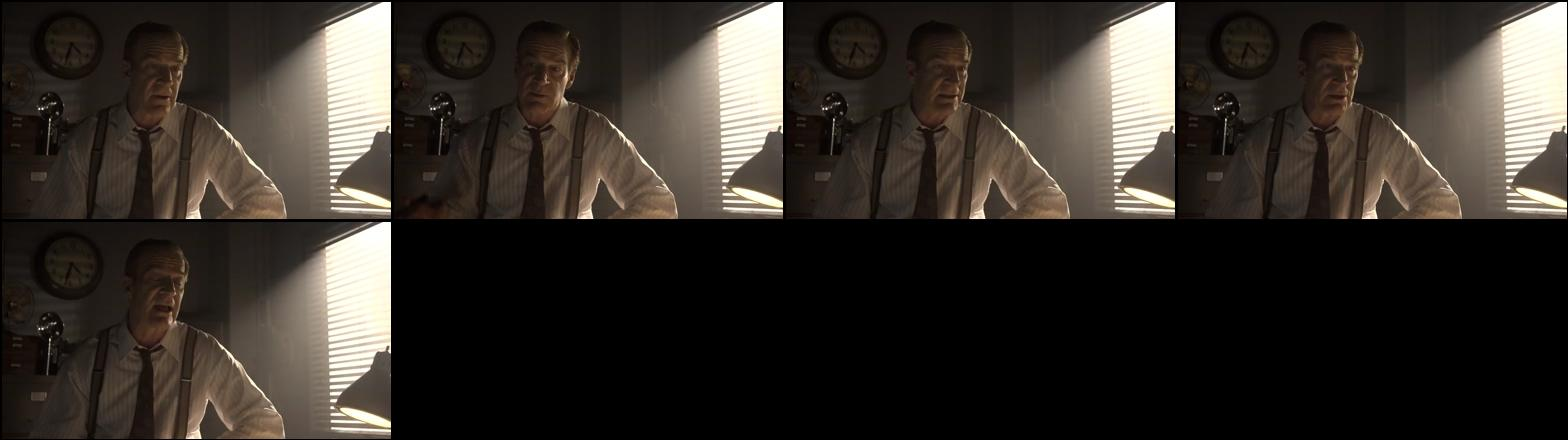

Shot description: The shot opens with an older man wearing a suit and tie seated at a desk in an office setting. The Department of Justice emblem is visible on the wall behind him, suggesting he works for that government agency. He appears pensive or somber as he looks down at documents on his desk, seemingly engrossed in thought or reviewing important materials. The lighting creates a dramatic, shadowed look, adding to the serious tone of the scene. Throughout the sequence of frames, the man maintains this stoic, contemplative stance, potentially grappling with a weighty decision or case related to his official duties.

Shot transcript:  He sees her, she's beautiful, but like she's from some other time, some other place, he looks back at the weather because it's getting worse and worse.;  He decides to hightail it out of there and that was it. That was his story, right?; 


SHOT 35/94: from 191124ms to 198031ms =======



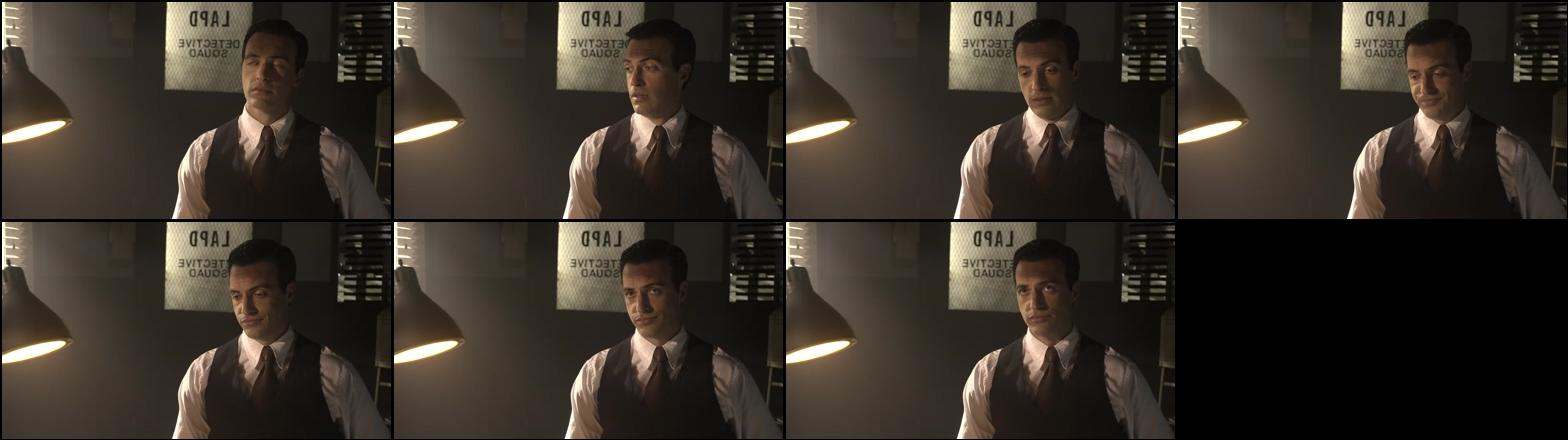

Shot description: The shot opens with a tight close-up of a well-dressed man in a suit and tie, staring directly at the camera with an intense gaze. The stark lighting casts dramatic shadows on his face, highlighting his serious expression. The man remains eerily still throughout the shot, his eyes seemingly piercing through the lens. The reverse-printed "LEGAL" sign in the background provides an ominous context, suggesting a legal or courtroom setting. Despite the lack of movement, the sustained shot on the man's unwavering stare builds a palpable sense of tension and mystery, inviting the viewer to ponder his motivations and the potential drama unfolding.

Shot transcript:  He decides to hightail it out of there and that was it. That was his story, right?; 


SHOT 36/94: from 198064ms to 204571ms =======



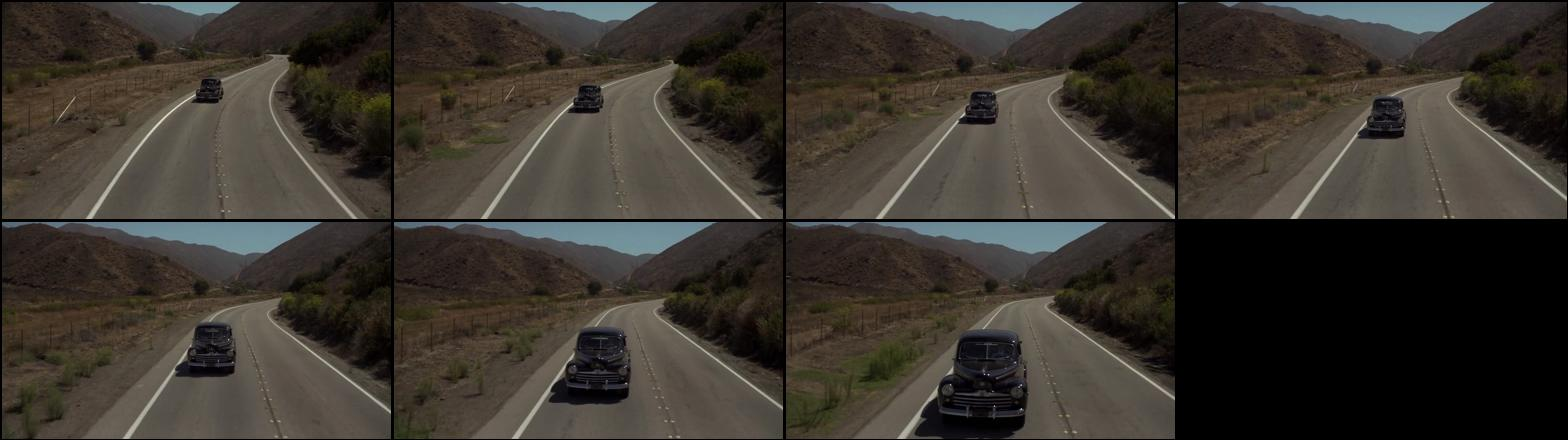

Shot description: The shot opens with a wide, scenic view of a winding road cutting through an arid, mountainous landscape. A black car is seen traveling along the road, slowly approaching the camera. As the car gets closer, the camera holds a steady frame, allowing the vehicle to smoothly move across the screen from a distant point to filling the foreground, creating a sense of momentum and journey through this desolate terrain.

Shot transcript:  So, now, no, I need you to go up there and find that woman.; 


SHOT 37/94: from 204604ms to 236703ms =======



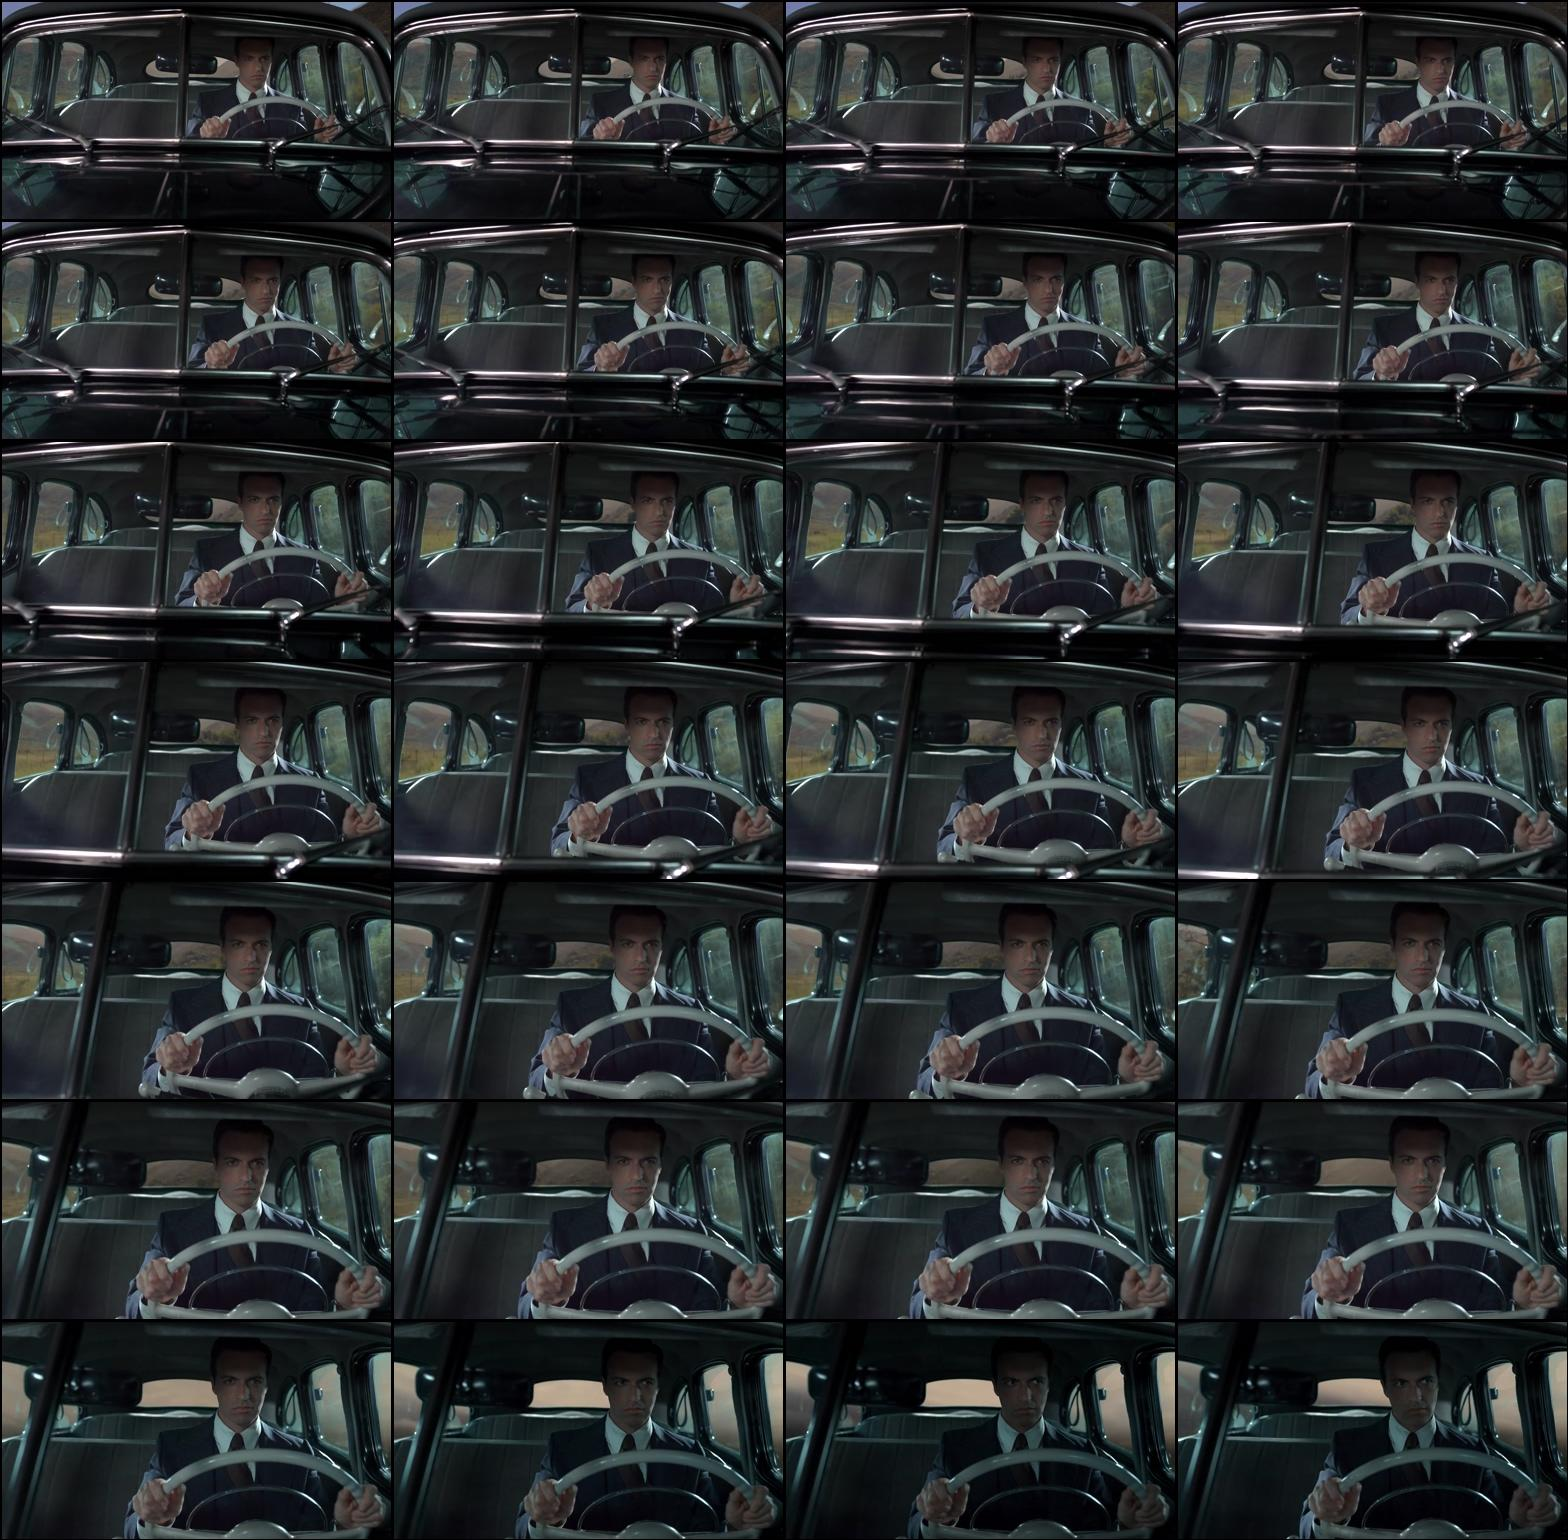

Shot description: A man in a suit and hat is shown driving an old-fashioned luxury car. The shots are tightly framed on him gripping the steering wheel and focused on operating the vehicle. His expression remains neutral and concentrated throughout the sequence of images, suggesting a important or urgent journey taking place. The repetitive framing and lack of context builds an air of mystery and intrigue around this stylish figure behind the wheel.

Shot transcript:  So these guys just disappear.;  Uh, not just, uh, somebody was out there the day. The last guy disappeared. A witness, a witness.;  He said that he was up there walking his dog along those bluffs above El Matra door.;  And there's a guy who's on top of that rock.;  He's just like looking all over the rock as if he's looking for someone or something.;  Then it gets dark all of a sudden really fast, like thunder and lightning from everywhere. All this weather when he looks back at the rock, the guy's gone, but there's a wom

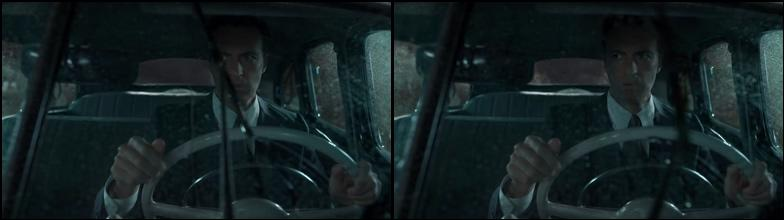

Shot description: A man in a suit grips the steering wheel of a car, his face partially illuminated by the dim interior lights. He has an intense, focused expression, suggesting he is driving in a tense or high-stakes situation. The background is blurred, but appears to be an urban environment at night, adding to the dramatic atmosphere. The sequence of frames captures the man's unwavering determination as he navigates through the city streets, potentially involved in some sort of chase or urgent journey.

Shot transcript:  Then it gets dark all of a sudden really fast, like thunder and lightning from everywhere. All this weather when he looks back at the rock, the guy's gone, but there's a woman there in a long white dress with alabaster skin and she's staring right up at him. Not moving.; 


SHOT 39/94: from 238471ms to 239439ms =======



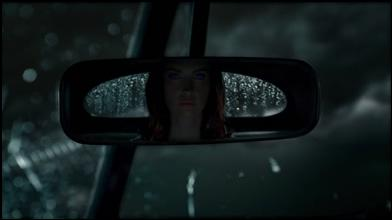

Shot description: The shot opens with a close-up of a rearview mirror inside a car, revealing a rainy and foggy environment outside on a dimly lit road through a forest or wooded area. As the camera gradually pulls back, we see the interior of the vehicle, which appears to be an old truck or van. The windshield wipers are in motion, struggling against the heavy downpour. Suddenly, a large figure emerges from the darkness outside, looming in front of the vehicle. The shot cuts to the terrified expression of the driver as they hit the brakes, tires screeching on the wet pavement. The large, ominous figure is revealed to be a massive grizzly bear standing upright in the middle of the road.

Shot transcript: 


SHOT 40/94: from 239472ms to 240407ms =======



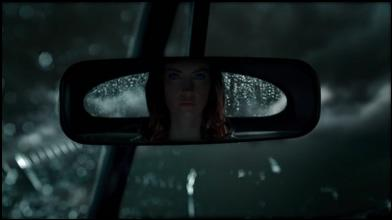

Shot description: The video opens with a view from the rearview mirror of a car, revealing a snowy landscape outside. The camera pans to show the interior of the vehicle, where a person is driving through the winter conditions. Shots from the front windshield depict the car navigating along a winding road surrounded by bare trees covered in snow. As the vehicle continues its journey, the scenes alternate between close-ups of the determined driver and wide shots showcasing the serene yet treacherous winter environment. The video culminates with a final glimpse through the rearview mirror, revealing the car's tracks left behind in the freshly fallen snow.

Shot transcript: 


SHOT 41/94: from 240440ms to 253486ms =======



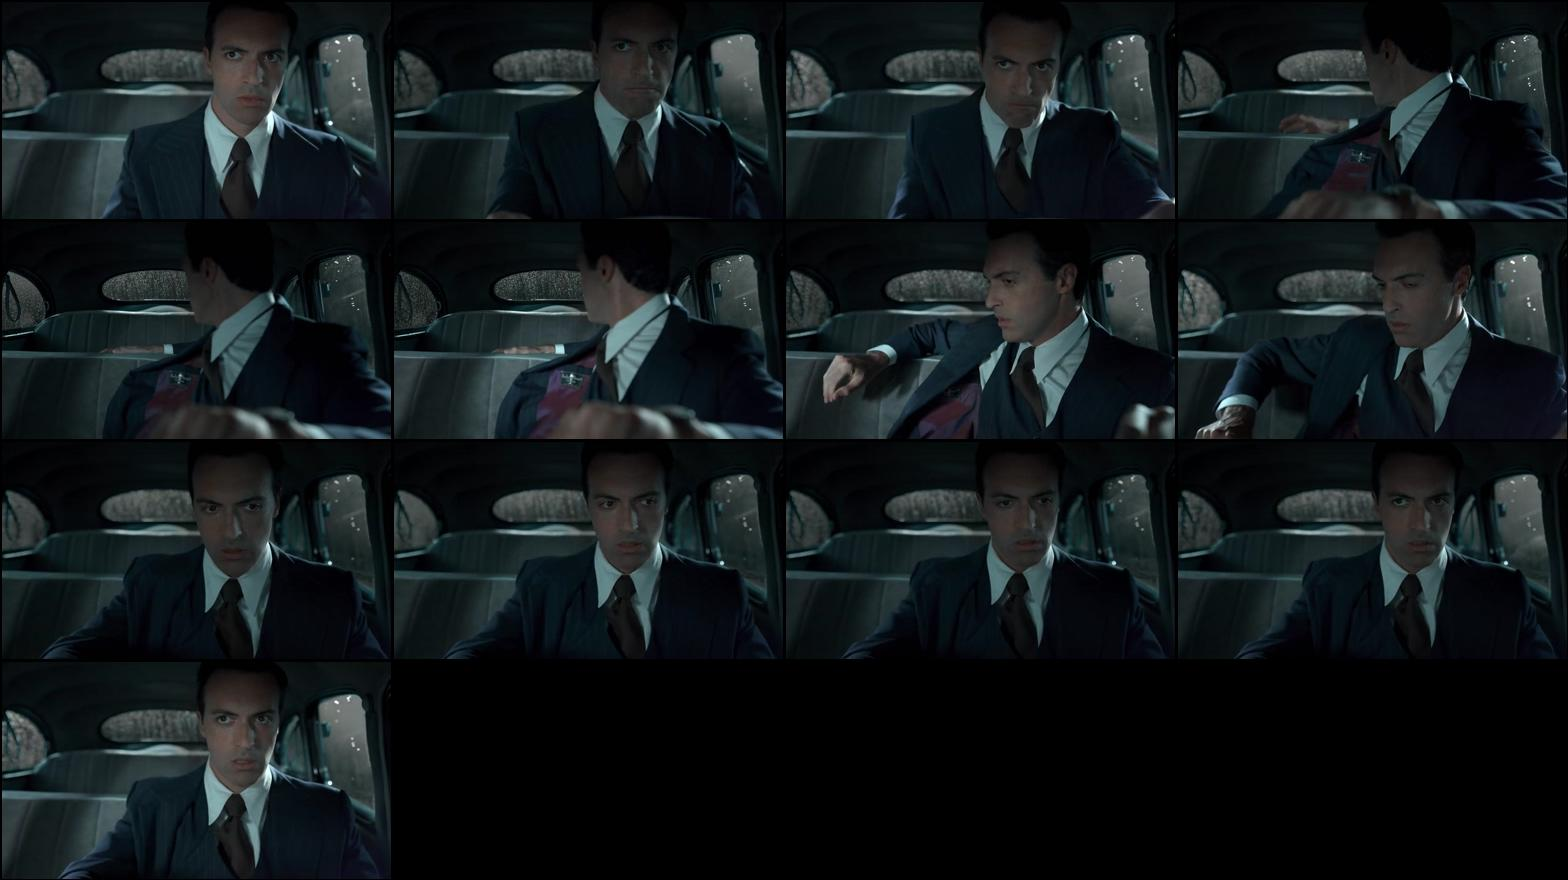

Shot description: The video shot depicts a man wearing a suit sitting inside a car. The scene is dimly lit, with the man's face illuminated from the side, giving it a dramatic, noir-like ambiance. Initially, he has a pensive expression, staring straight ahead. As the shot progresses, the man turns his head, his gaze shifting from the front windshield towards something off-screen. His facial expression intensifies, displaying a mix of determination and tension. The camera angle remains fixed, tightly framing the man's upper body and face, creating a sense of claustrophobia and intensity. The overall tone of the shot suggests a pivotal moment in a tense, suspenseful narrative.

Shot transcript:  Then it gets dark all of a sudden really fast, like thunder and lightning from everywhere. All this weather when he looks back at the rock, the guy's gone, but there's a woman there in a long white dress with alabaster skin and she's staring right up at him. Not moving.; 


SHOT 42/94: from 25388

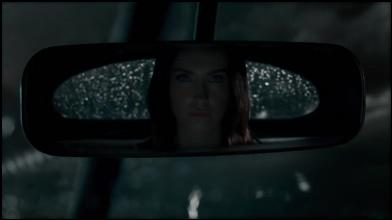

Shot description: The shot opens with a close-up view from the rearview mirror of a car, revealing droplets of rain streaking across the glass. The perspective shifts to the driver's side window, offering a glimpse of the dark, rainy night outside. The camera then pans to capture the silhouette of the driver, a shadowy figure gripping the steering wheel as the windshield wipers rhythmically clear the downpour. The shot maintains an air of tension and mystery, leaving the viewer to wonder about the driver's destination and the unfolding events on this ominous night drive.

Shot transcript: 


SHOT 43/94: from 254788ms to 255422ms =======



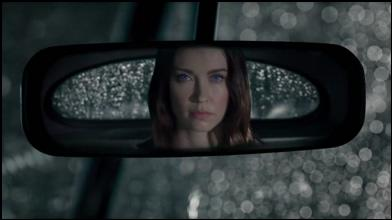

Shot description: The shot opens with a close-up view of a young woman's face reflected in the rearview mirror of a car. Raindrops speckle the windshield, creating a backdrop of glistening lights. The woman's expression is pensive, her gaze fixed ahead as if lost in thought. The camera cuts to a wider interior shot, revealing her seated in the driver's seat while the muted city lights and rain streak past outside the car windows, suggesting forward motion. The dimly lit interior and the solitary woman create an introspective, melancholic atmosphere as the shot captures a quiet, contemplative moment during her nighttime journey through the rainy urban landscape.

Shot transcript: 


SHOT 44/94: from 256122ms to 256990ms =======



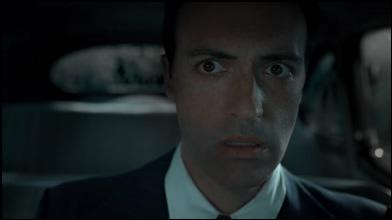

Shot description: The shot opens with a close-up of a man's intense gaze, his eyes wide and focused, setting an ominous tone. As the camera pulls back, he is revealed to be seated in a car at night, the interior illuminated by streetlights outside. With a determined expression, he grips the steering wheel tightly, seemingly preparing for something significant. The tension builds as he takes a deep breath and shifts the gear, the engine revving in anticipation. The shot concludes with the car peeling out, tires screeching on the pavement, hinting at a high-stakes pursuit or urgent mission about to unfold.

Shot transcript: 


SHOT 45/94: from 257157ms to 257424ms =======



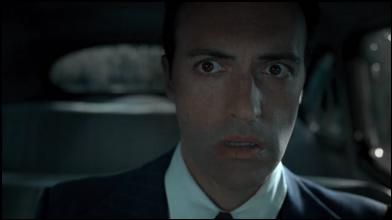

Shot description: The shot opens with a close-up of a man's intense gaze, his eyes wide and mouth slightly open, conveying a sense of urgency or distress. The following frames reveal that he is sitting in the driver's seat of a car, gripping the steering wheel tightly. His head turns from side to side, scanning the environment around him with an expression of heightened alertness. The camera angle shifts, providing glimpses of the dimly lit street outside through the windshield and side windows, suggesting a nighttime setting. The man's movements become more frantic as he appears to be searching for something or someone, his breath visibly condensing in the chilly air. The tension builds as the shot continues to focus on his anxious demeanor, leaving the viewer to wonder about the circumstances that have him in such a state of heightened vigilance.

Shot transcript: 


SHOT 46/94: from 257624ms to 259426ms =======



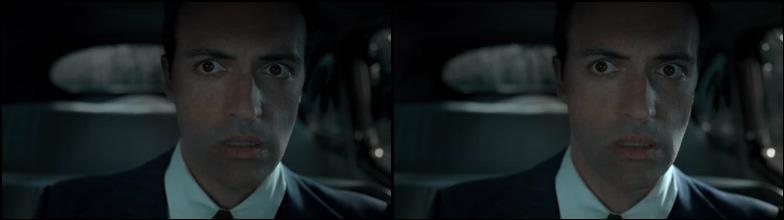

Shot description: The shot opens with a close-up of a man's intense, furrowed expression as he sits in what appears to be the driver's seat of a vehicle. The dim lighting and shadows cast across his face create a sense of tension and unease. As the frames progress, his eyes dart back and forth, suggesting he is either scanning his surroundings vigilantly or experiencing an internal struggle or conflict. The tight framing and shallow depth of field keep the focus squarely on the man's facial features, heightening the dramatic effect of the shot.

Shot transcript:  I know. I sure don't want to believe him.; 


SHOT 47/94: from 260060ms to 261795ms =======



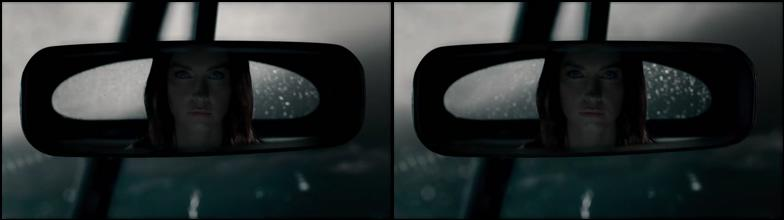

Shot description: The shot opens with a view from the rearview mirror of a car, revealing a woman's face reflected in it. She appears to be the driver, focused on the road ahead as rain droplets streak across the windshield. The gloomy, rainy atmosphere outside the vehicle creates a somber, contemplative mood. As the shot progresses, the woman's expression remains stoic, suggesting an inner turmoil or a weighty matter occupying her thoughts during this solitary drive through the inclement weather.

Shot transcript: 


SHOT 48/94: from 261828ms to 263697ms =======



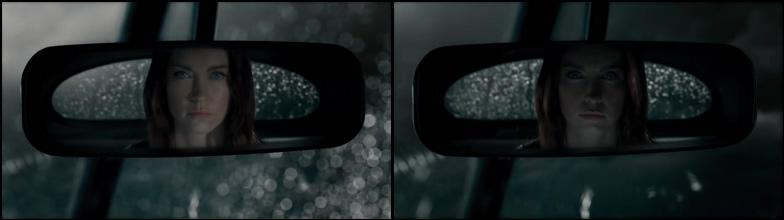

Shot description: The shot opens with a close-up of a rearview mirror inside a car, revealing the reflection of a young woman's face through the raindrops on the windshield. She has a pensive, somber expression as she gazes ahead, framed by the blurred lights of the night outside. The camera holds her reflection for a few moments, setting a melancholic and introspective tone as the scene transitions to the next part of the narrative.

Shot transcript: 


SHOT 49/94: from 263730ms to 264798ms =======



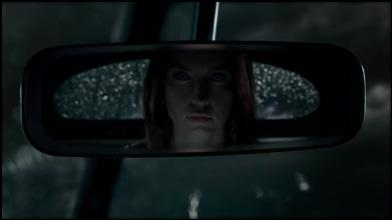

Shot description: The shot opens with a close-up view through the rear-view mirror of a car, revealing a woman's face. She has an intense, focused expression as she grips the steering wheel. The camera then cuts to an exterior shot, with the car driving at night on a deserted road surrounded by darkness. The vehicle's headlights pierce through the rain-soaked night, illuminating the path ahead. The camera lingers on the car as it navigates the treacherous conditions, building a sense of tension and mystery about the woman's destination and purpose for this late-night journey.

Shot transcript: 


SHOT 50/94: from 264831ms to 265532ms =======



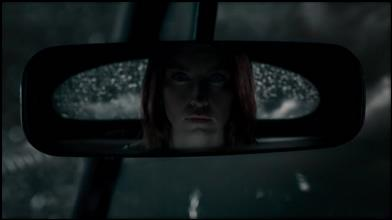

Shot description: The shot opens with a close-up view from the rearview mirror of a car, revealing a person's face reflected in it. The frame is dark, suggesting a nighttime setting. As the shot progresses, the car appears to be moving through a snowy, forested area, with trees and falling snow visible through the windshield. The figure in the rearview mirror remains tense and focused, likely the driver navigating the wintry road conditions. The shot builds a sense of tension and isolation, capturing the solitary journey of this individual through a remote, snow-covered landscape at night.

Shot transcript: 


SHOT 51/94: from 265799ms to 267801ms =======



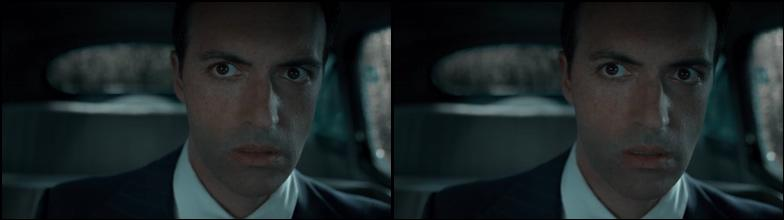

Shot description: The shot opens with a tightly framed close-up of a man's intense, focused expression. His eyes are wide and alert, suggesting a sense of tension or urgency. The dim lighting and shadows cast dramatic shadows across his face, heightening the intense atmosphere. As the shot holds steady on his gaze, it conveys a buildup of anticipation or suspense, leaving the viewer to wonder what circumstance or event has captured this man's rapt attention and what will unfold next.

Shot transcript: 


SHOT 52/94: from 268234ms to 272072ms =======



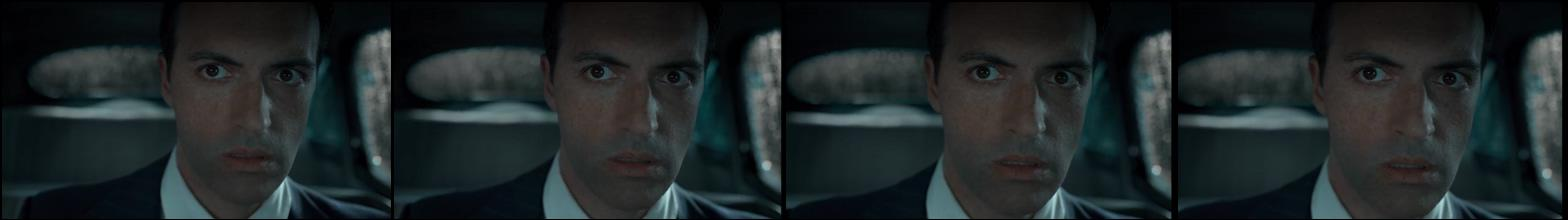

Shot description: The shot opens with a close-up of a man's face, revealing intense eyes and a tense expression. He appears to be sitting inside a vehicle, likely a car. The camera holds this tight framing as the man's gaze remains fixed and unblinking, conveying a sense of focus or determination. The consistent framing and lack of camera movement suggest a dramatic pause or moment of suspense, drawing the viewer's attention solely to the man's stern visage and building anticipation for what might unfold next.

Shot transcript: 


SHOT 53/94: from 272105ms to 294694ms =======



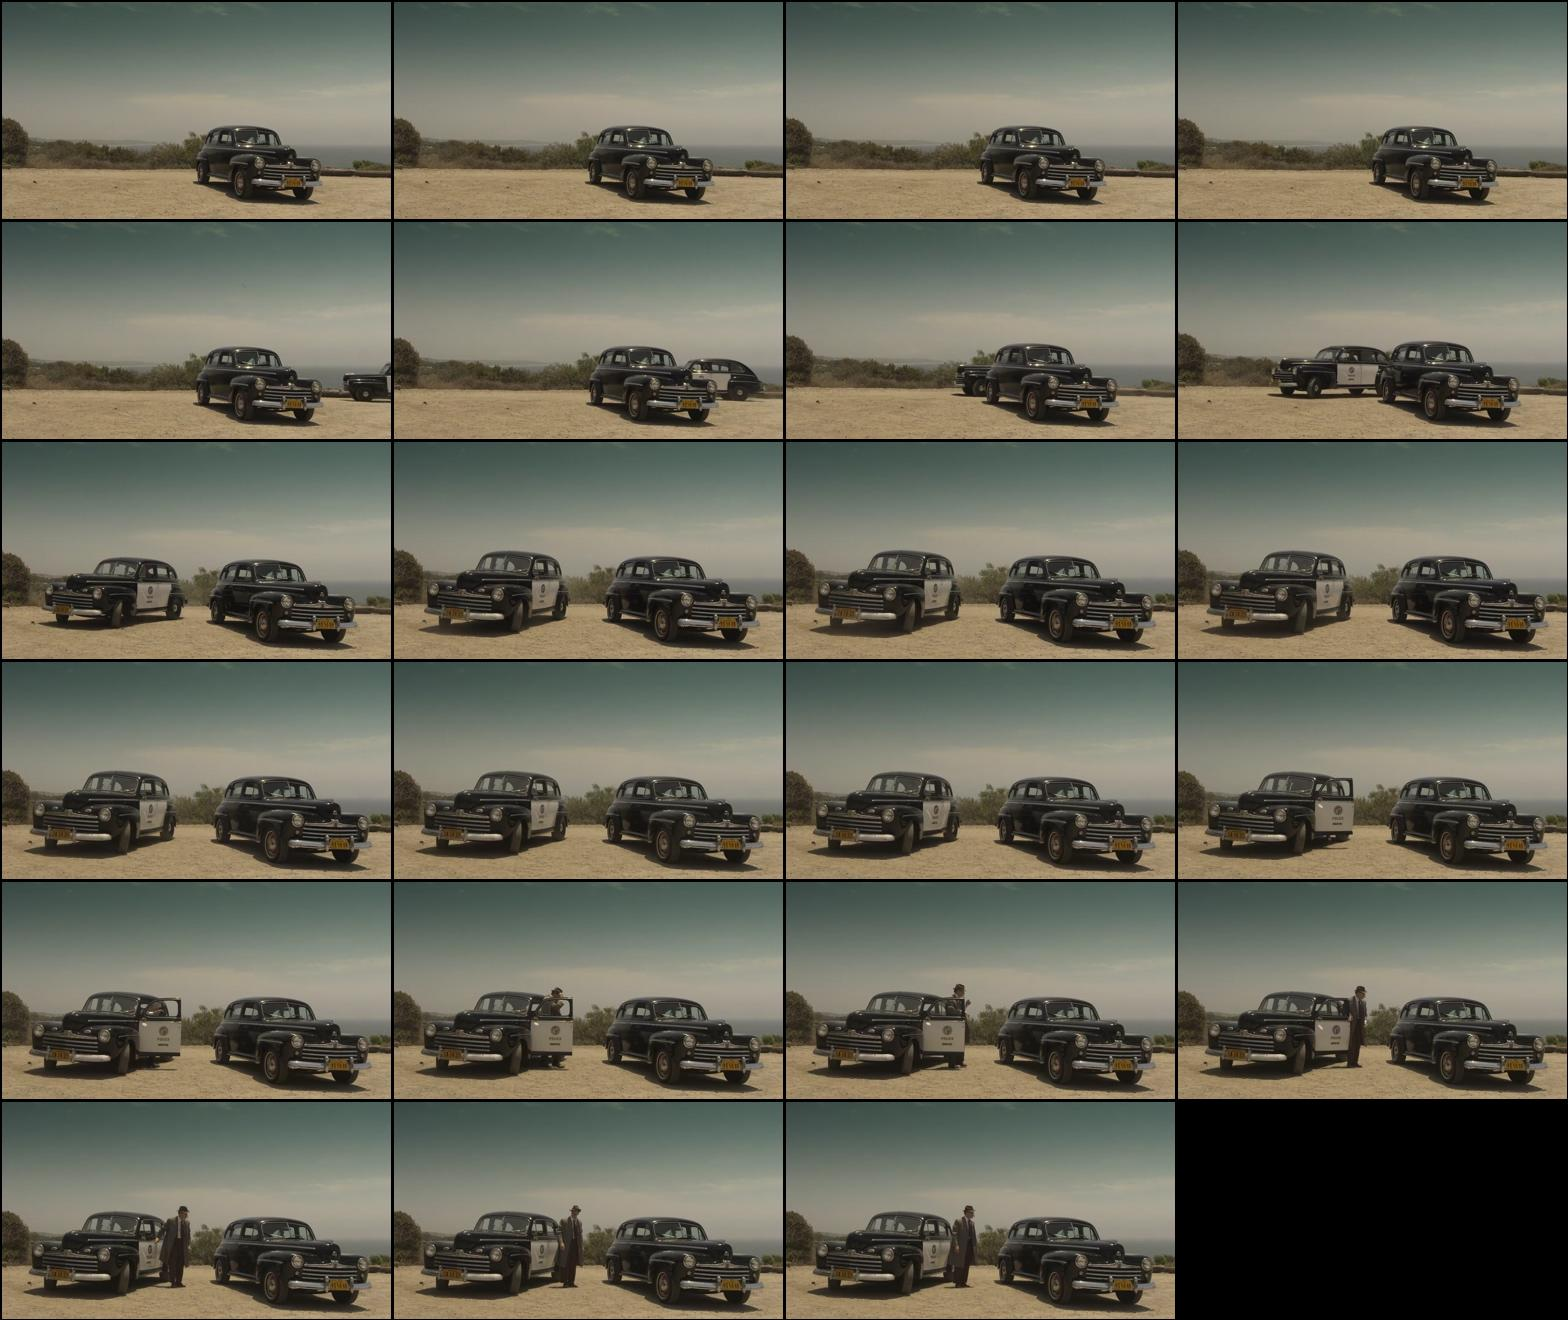

Shot description: The shot opens with a vintage American sedan driving across a desert landscape against the backdrop of a hazy, desert sky. As the car continues its steady journey across the barren terrain, a person emerges from the rear of the vehicle and begins walking alongside it. The individual, clad in casual attire, maintains a casual pace in sync with the moving car, creating a visually intriguing dynamic between the person and the automobile. This juxtaposition of the seemingly mundane act of walking alongside a car in the vast, desolate desert setting adds an air of mystery and intrigue to the scene.

Shot transcript: 


SHOT 54/94: from 294728ms to 336469ms =======



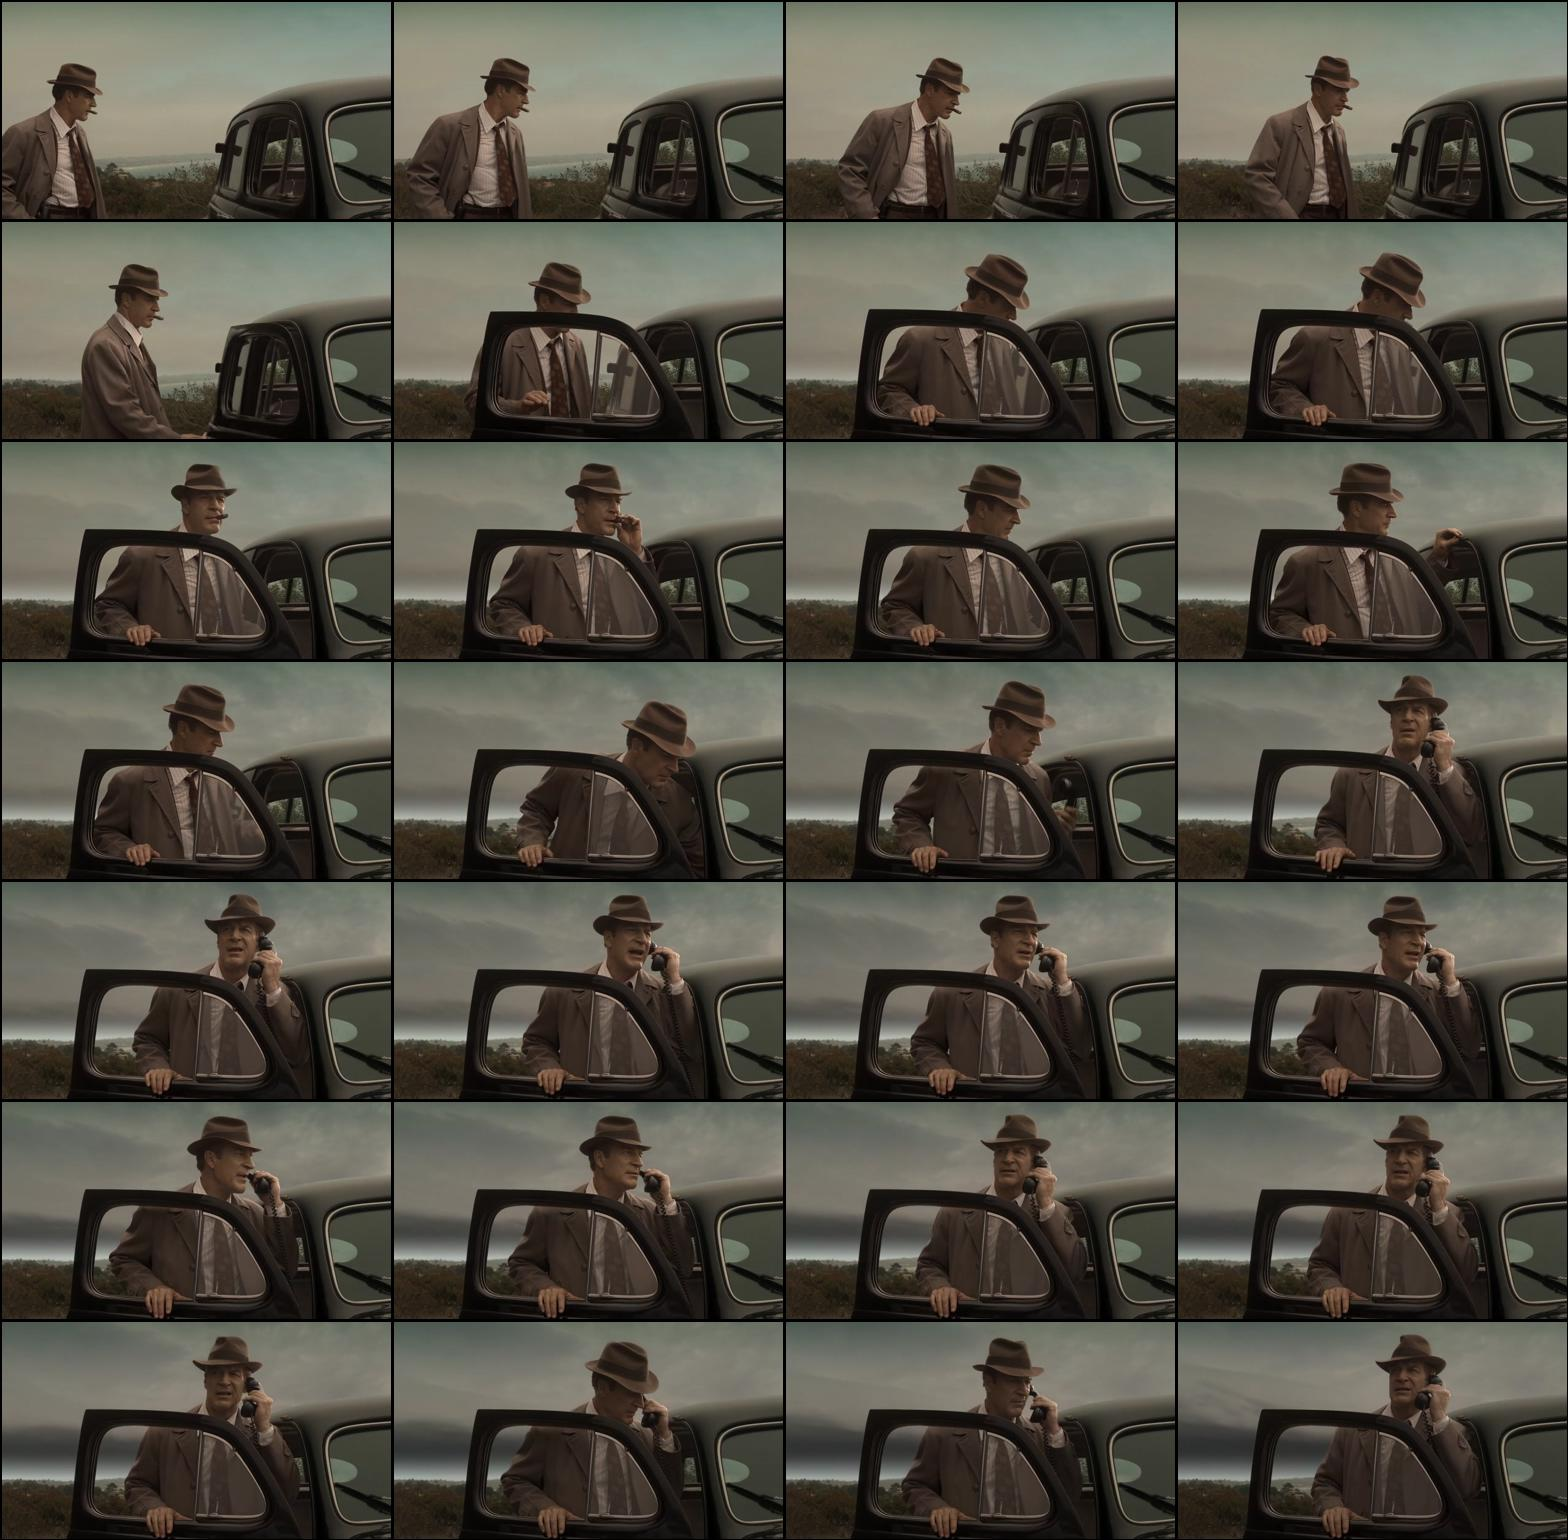

Shot description: A well-dressed man in a fedora hat and suit is seen sitting in an old-fashioned car in a desolate, rural setting. The camera gradually moves in closer as the man, with a pensive expression, looks out through the windshield across the vast, empty landscape. He then pauses, reaches into his jacket pocket, retrieves a cigarette case, and proceeds to light a cigarette, taking a long drag while continuing to gaze outward, lost in contemplation amidst the serene yet isolating environment surrounding him.

Shot transcript:  Yeah, I dispatch. This is Captain Foster.;  I'm out here at the El Matador location.;  There's no sign of Detective Sullivan now it's his car.;  Listen, I'm gonna take a look around before you send anybody out here. So hang on a minute.; 


SHOT 55/94: from 336503ms to 350116ms =======



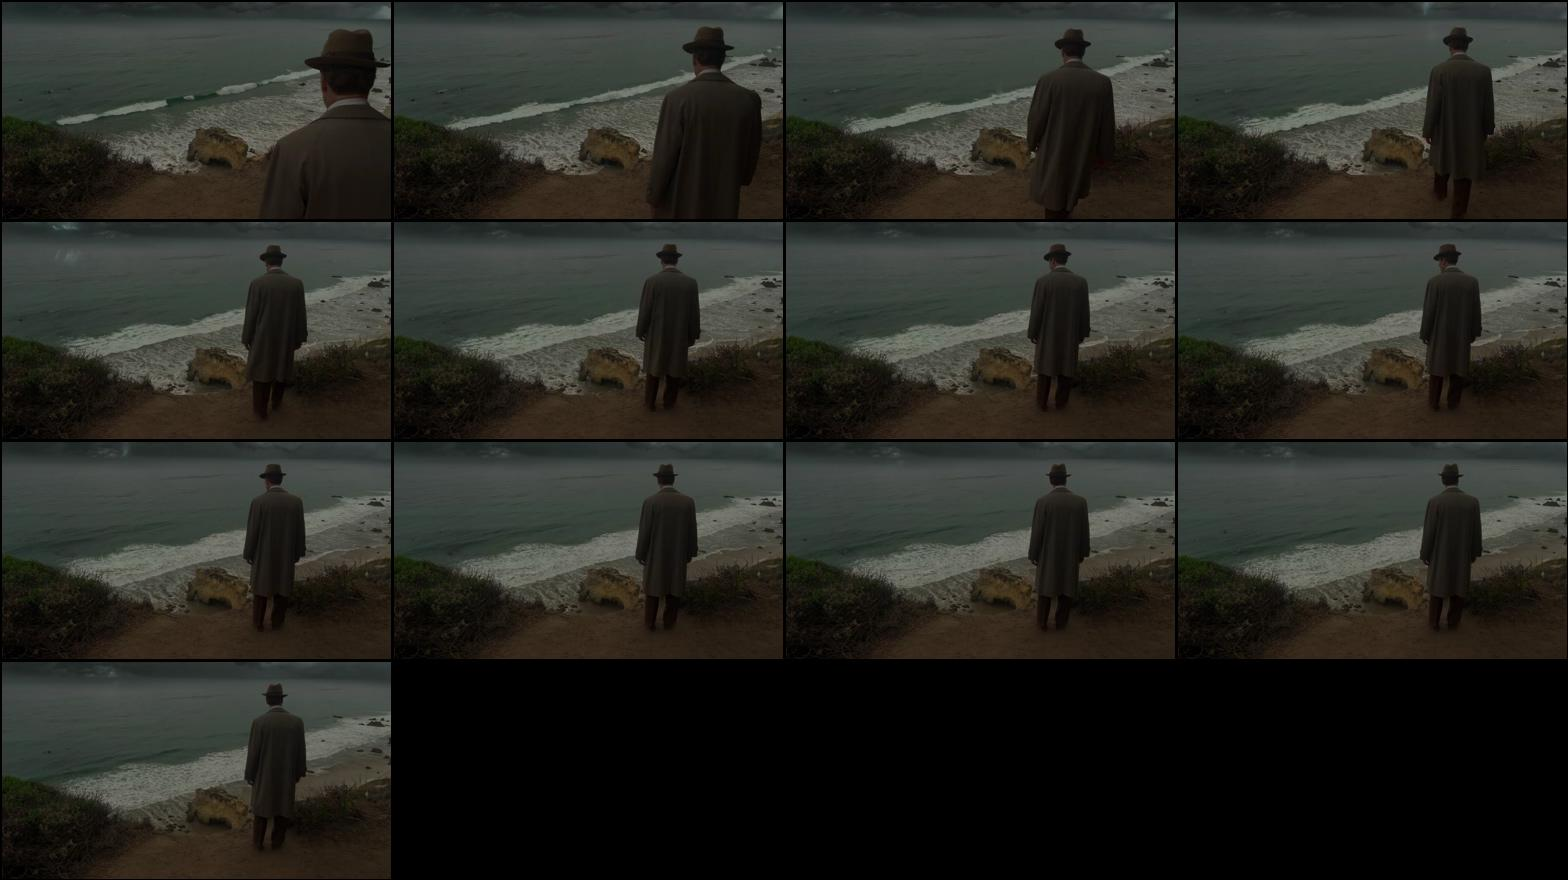

Shot description: The scene opens with a lone figure, dressed in a long coat and hat, standing on a grassy cliff overlooking a turbulent sea. The camera holds steady on this contemplative silhouette, framed against the crashing waves and grey skies, for an extended period. There is a solemn, pensive quality to the shot, with the motionless figure dwarfed by the vastness of the rugged coastal landscape. The extended duration and lack of movement suggests a weighty, melancholic tone, inviting the viewer to linger on the haunting, isolated imagery.

Shot transcript:  Captain B, come in, please, Captain Foster.;  Then please come LAPD, put your hands in the air, put your hands up now, check it; 


SHOT 56/94: from 350150ms to 357223ms =======



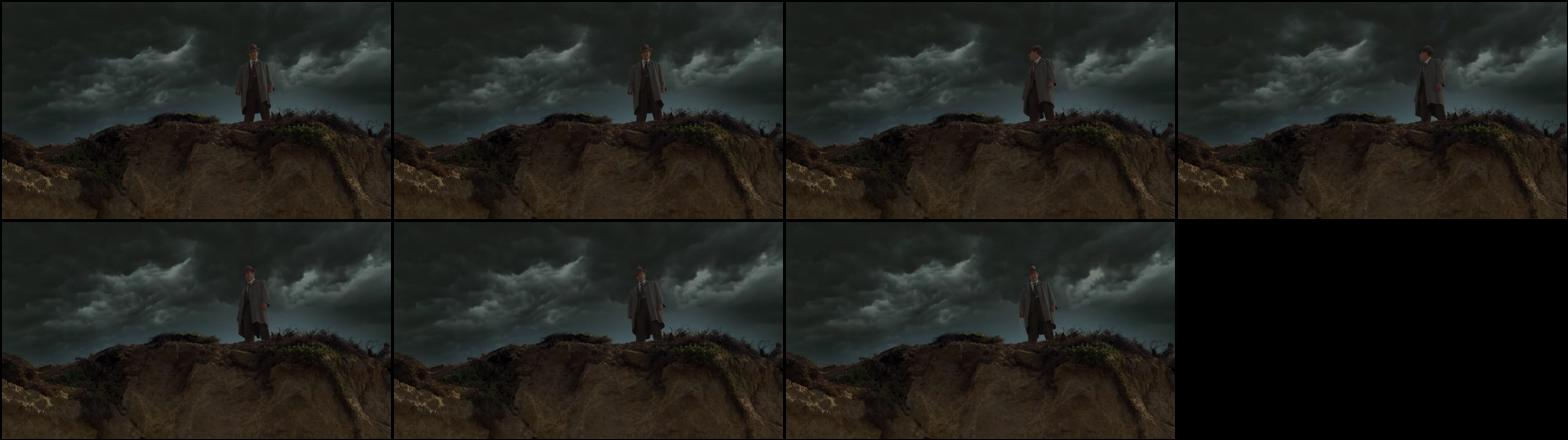

Shot description: The video shot depicts a lone figure standing atop a rocky outcrop against a backdrop of ominous storm clouds. The setting appears desolate and barren, with the figure's cloak billowing in the wind, adding a sense of isolation and melancholy to the scene. Despite the frames being static, the visual elements convey a palpable tension and anticipation, as if the figure is surveying the approaching tempest or awaiting some unknown event. The muted color palette and dramatic lighting intensify the moody, almost foreboding atmosphere, leaving the viewer to ponder the narrative significance of this solitary, enigmatic figure braving the impending storm.

Shot transcript:  Then please come LAPD, put your hands in the air, put your hands up now, check it; 


SHOT 57/94: from 357257ms to 357624ms =======



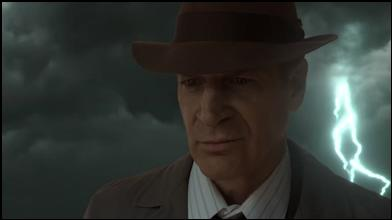

Shot description: The shot opens with an intense close-up of a weathered man wearing a fedora, illuminated by dramatic lightning flashes against a dark, stormy backdrop. His furrowed brow and steely gaze convey a sense of determination and grit. As the camera pulls back, he is revealed to be a seasoned detective or private investigator, standing alone in the pouring rain on a deserted city street lined with ominous shadows. The tension builds as he adjusts his coat collar against the biting wind and squints down the alleyway, ready to confront whatever danger or mystery lies ahead in this noir-tinged urban setting.

Shot transcript: 


SHOT 58/94: from 357657ms to 359192ms =======



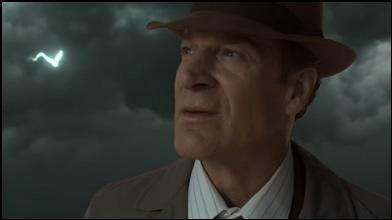

Shot description: A rugged man, wearing a brown hat and suit, is standing outdoors at night under a cloudy sky with a bird flying across. He has a somber, contemplative expression on his weathered face as he gazes ahead, seemingly lost in thought amidst the atmospheric surroundings.

Shot transcript:  Then please come LAPD, put your hands in the air, put your hands up now, check it; 


SHOT 59/94: from 359225ms to 359459ms =======



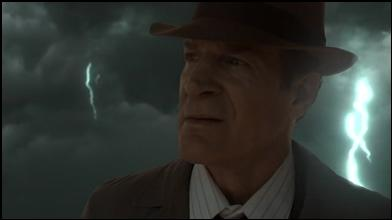

Shot description: An older man wearing a fedora hat and suit stands in a dimly lit environment, his face illuminated by a harsh light source. His gaze is intense and piercing, suggesting a sense of authority or intimidation. The scene then cuts to the man walking purposefully down a corridor lined with pipes, maintaining his determined stride. The shot transitions to a close-up of his face, his brow furrowed and his jaw set, exuding a sense of grim determination. The final frame captures him standing near a doorway, casting a menacing silhouette against the backlit frame, leaving the viewer with a sense of anticipation and tension.

Shot transcript: 


SHOT 60/94: from 359492ms to 361127ms =======



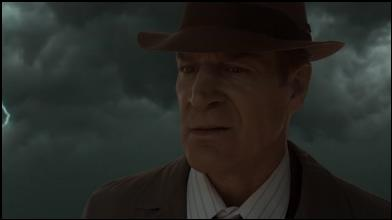

Shot description: A rugged, masculine man in a cowboy hat and suit stares directly at the camera with an intense gaze. The scene opens with a close-up of his weathered face and piercing eyes against a cloudy, gray sky backdrop. As the shot slowly pulls back, we see the man standing alone in a vast, open field or prairie, emphasizing his isolation and grounded presence in this harsh, unforgiving landscape. The camera angle and man's clothing suggest a classic Western setting or theme, with the character embodying the iconic image of a strong, stoic cowboy figure.

Shot transcript:  Then please come LAPD, put your hands in the air, put your hands up now, check it; 


SHOT 61/94: from 361161ms to 363897ms =======



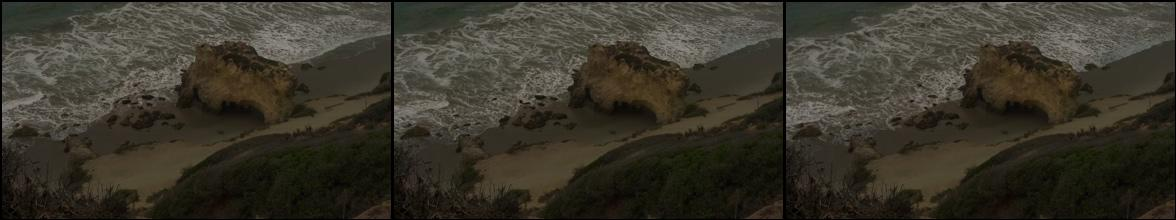

Shot description: The video shot opens with an expansive view of a barren, rocky landscape enveloped in shades of gray and brown. A lone, massive rock formation dominates the frame, its craggy silhouette cutting an imposing figure against the desolate backdrop. As the shot holds steady, the scene remains frozen in time, evoking a sense of isolation and timelessness within this seemingly untouched geological marvel.

Shot transcript:  Then please come LAPD, put your hands in the air, put your hands up now, check it; 


SHOT 62/94: from 363930ms to 369669ms =======



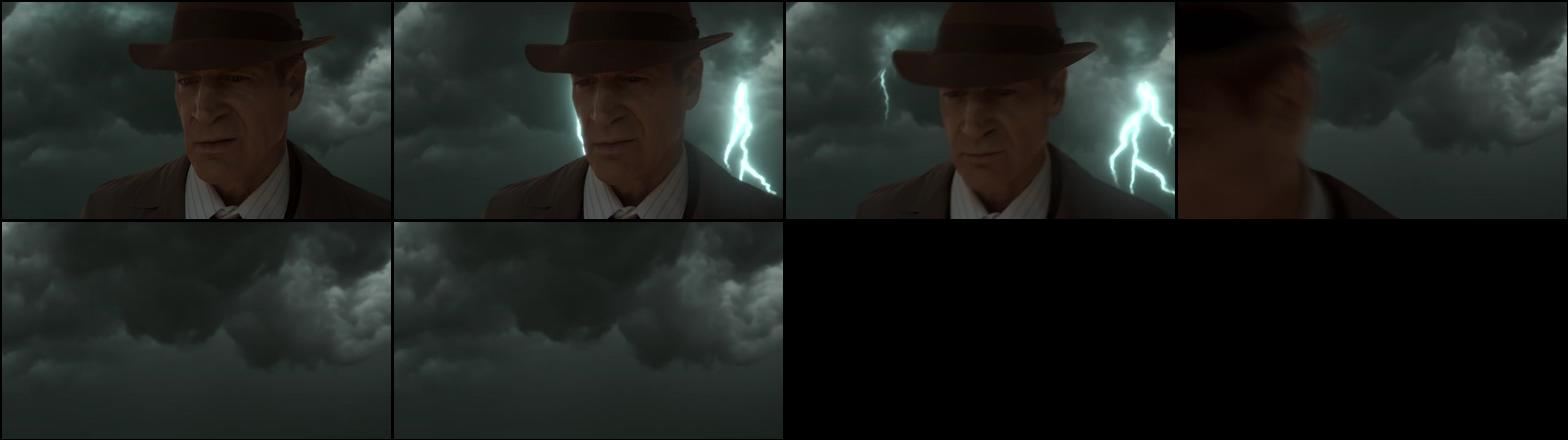

Shot description: The shot opens with a close-up of a man in a suit and hat, his stern face illuminated by flashes of lightning against a stormy sky. As the lightning intensifies, briefly revealing more details of his weathered features, the shot holds steady on his unflinching gaze. The dramatic lighting and his stoic demeanor suggest a foreboding atmosphere, building tension and mystery around this enigmatic character braving the turbulent elements. The shot ends on a blackout, leaving the viewer to ponder the significance of this haunting visual moment.

Shot transcript:  Then please come LAPD, put your hands in the air, put your hands up now, check it; 


SHOT 63/94: from 369703ms to 373840ms =======



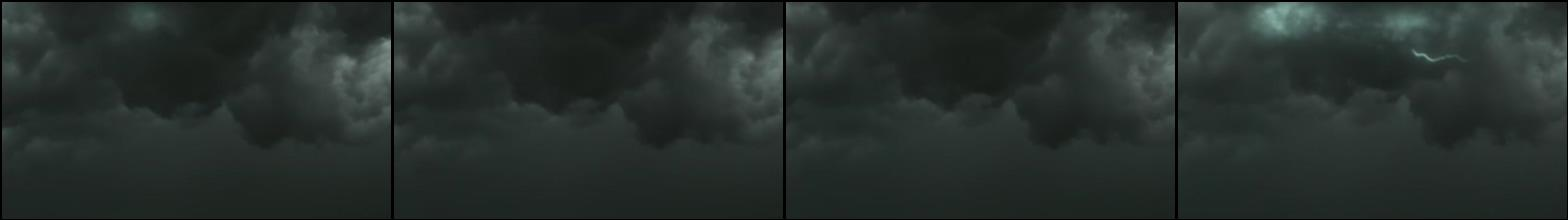

Shot description: The shot opens with ominous, dark storm clouds filling the sky. The clouds appear dense and turbulent, suggesting an impending severe weather event. The camera angle remains fixed throughout the shot, focused squarely on the imposing cloud formation overhead. The gloomy, monochromatic color palette and lack of movement in the frame create a tense, foreboding atmosphere, building a sense of anticipation for what might unfold next within this unsettled weather system.

Shot transcript:  Then please come LAPD, put your hands in the air, put your hands up now, check it; 


SHOT 64/94: from 373907ms to 395695ms =======



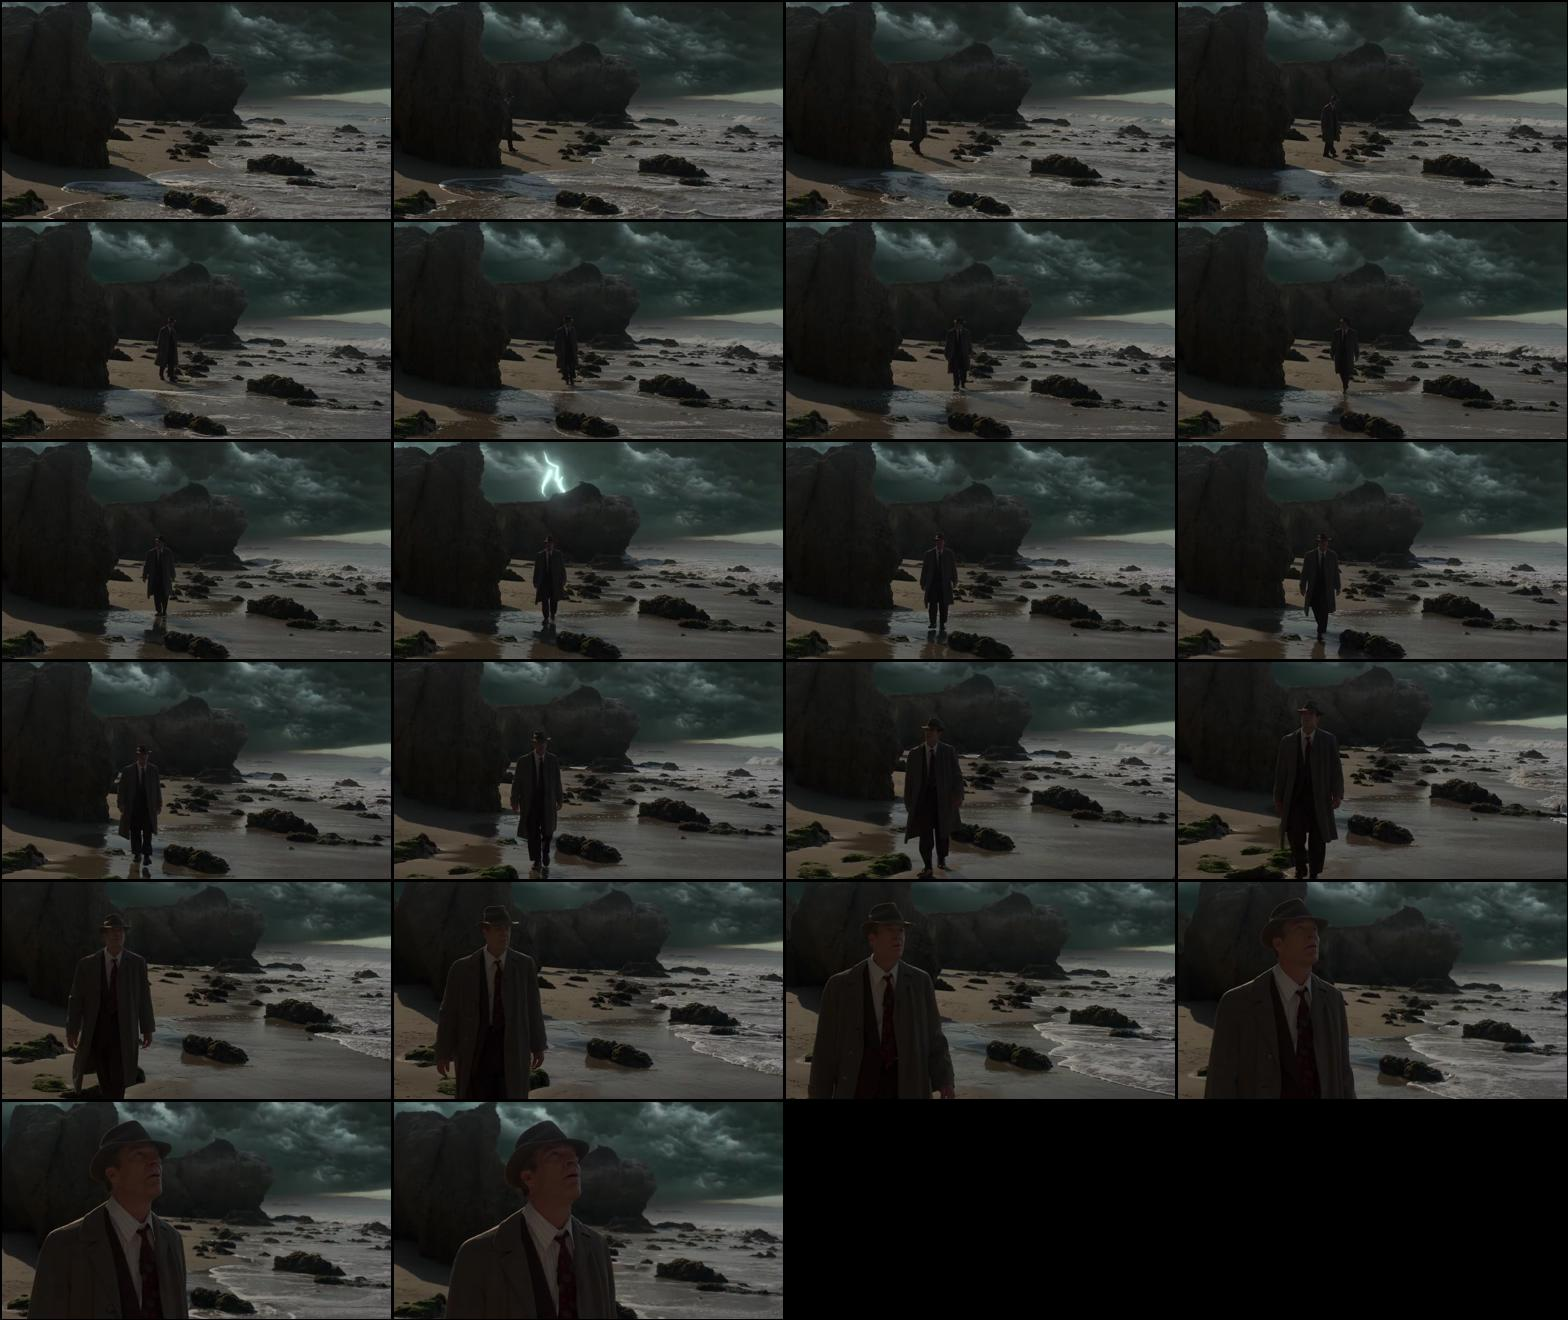

Shot description: The shot opens with a solitary figure walking along a rocky beach under an ominous, cloudy sky. As the camera pans, it reveals a tall, looming rock formation jutting out of the sand. The person, dressed in a suit and tie, continues walking towards the camera, their expression somber and determined. The scene has a sense of isolation and foreboding, with the crashing waves and grey tones adding to the moody atmosphere. The shot concludes with a close-up of the person's face, their features partially obscured by shadows, leaving an air of mystery and intrigue.

Shot transcript:  Then please come LAPD, put your hands in the air, put your hands up now, check it; 


SHOT 65/94: from 395729ms to 401334ms =======



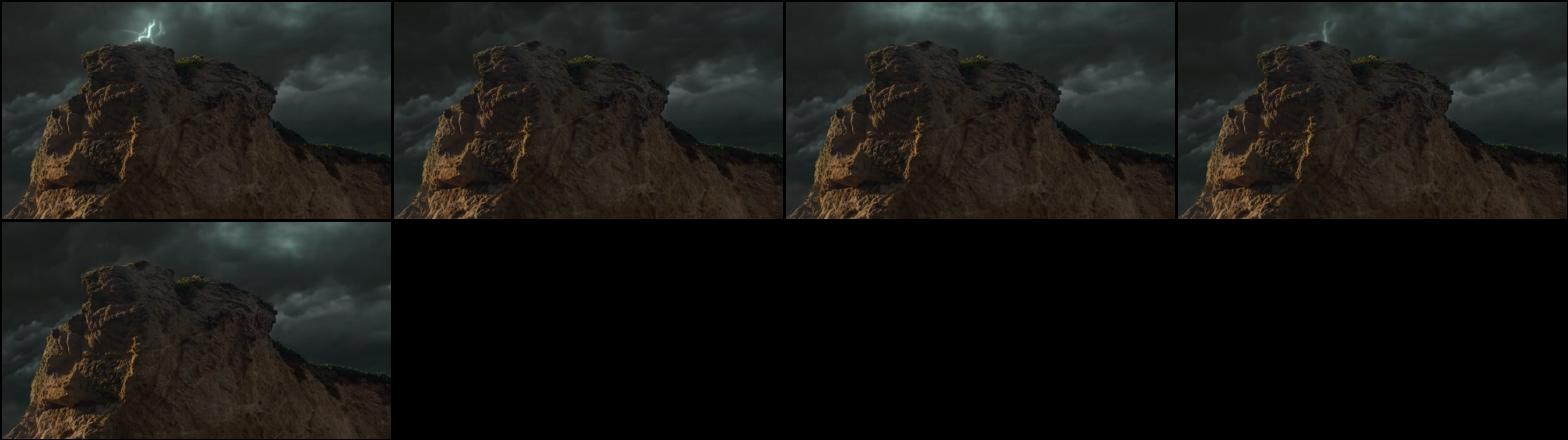

Shot description: The shot opens with a dramatic view of a rugged, towering rock formation against a stormy sky. Dark clouds loom ominously, illuminated by flashes of lightning. The camera holds this establishing shot for a few moments, letting the viewer take in the imposing, almost ominous natural scenery. Suddenly, the screen cuts to black, leaving an air of tension and mystery hanging in the air.

Shot transcript:  Then please come LAPD, put your hands in the air, put your hands up now, check it; 


SHOT 66/94: from 401368ms to 409576ms =======



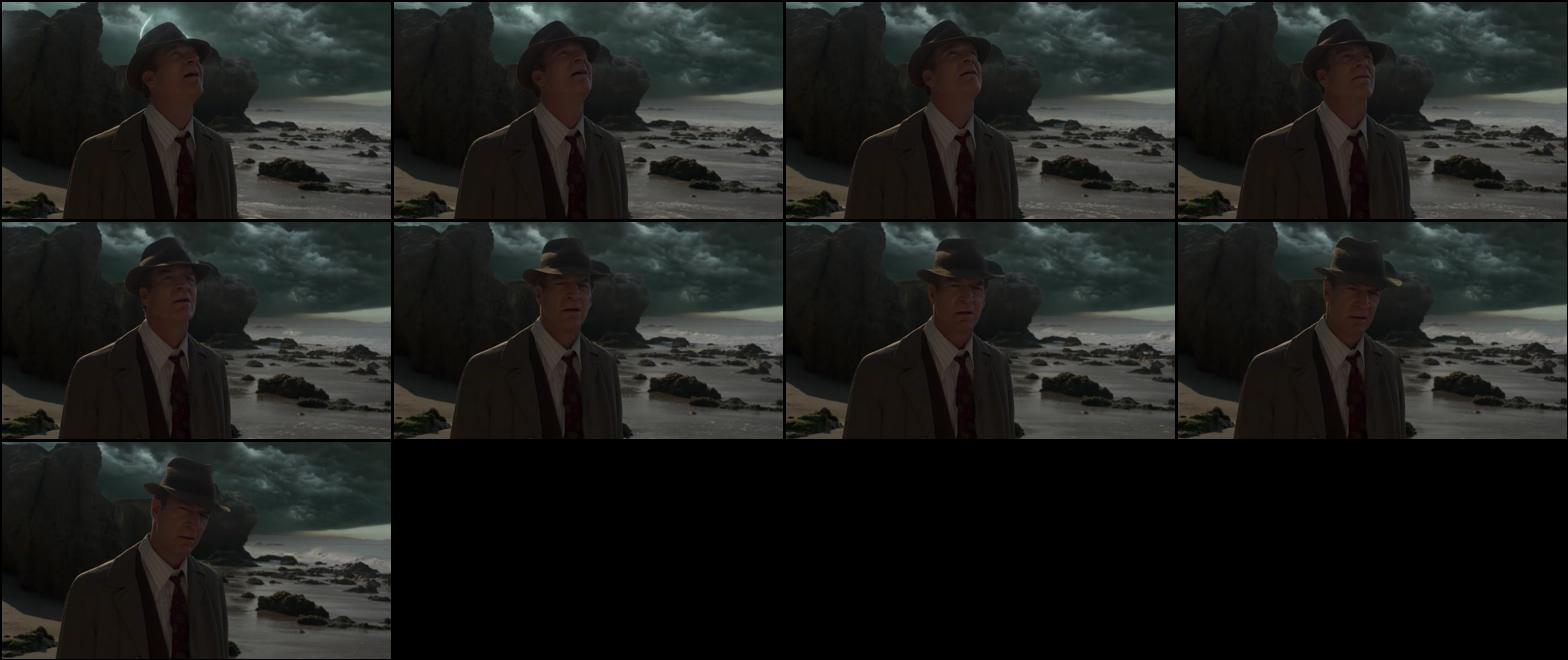

Shot description: The shot opens with a man in a suit and hat standing alone on a rocky beach, facing the turbulent sea under an ominous sky. The camera holds a steady close-up on his pensive expression as the wind whips his hair and clothing. The waves crash against the rocks in the background, creating a sense of isolation and intensity. Throughout the shot, the man's gaze remains fixed on the churning waters before him, his stoic demeanor suggesting an inner conflict or contemplation of something weighty. The dramatic lighting and sound of the crashing waves heighten the atmospheric tension of this somber, introspective moment.

Shot transcript:  Then please come LAPD, put your hands in the air, put your hands up now, check it; 


SHOT 67/94: from 409609ms to 415248ms =======



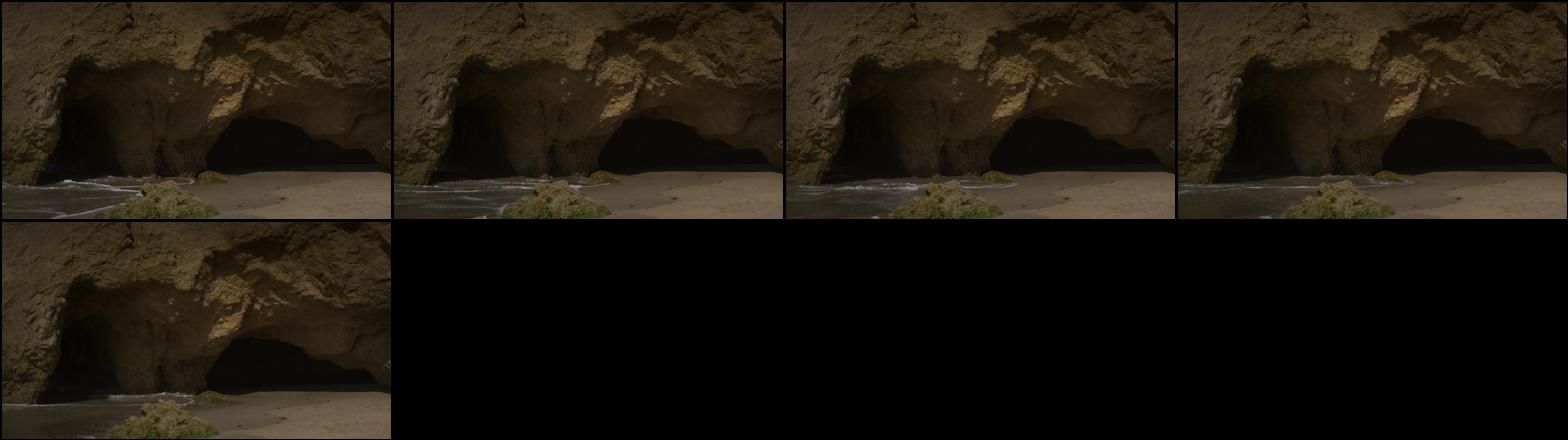

Shot description: The shot opens with a static view of a rocky cavern or grotto, its walls formed by craggy stone formations. A small sandy area is visible in the foreground, leading towards the mouth of the cave in the distance. The framing remains fixed throughout the sequence, suggesting either a locked-off camera or a series of still frames presented consecutively. The dimly lit scene has an ominous, foreboding atmosphere, leaving the viewer to wonder what unseen presence or narrative may unfold within this enigmatic subterranean setting.

Shot transcript:  Then please come LAPD, put your hands in the air, put your hands up now, check it; 


SHOT 68/94: from 415281ms to 437871ms =======



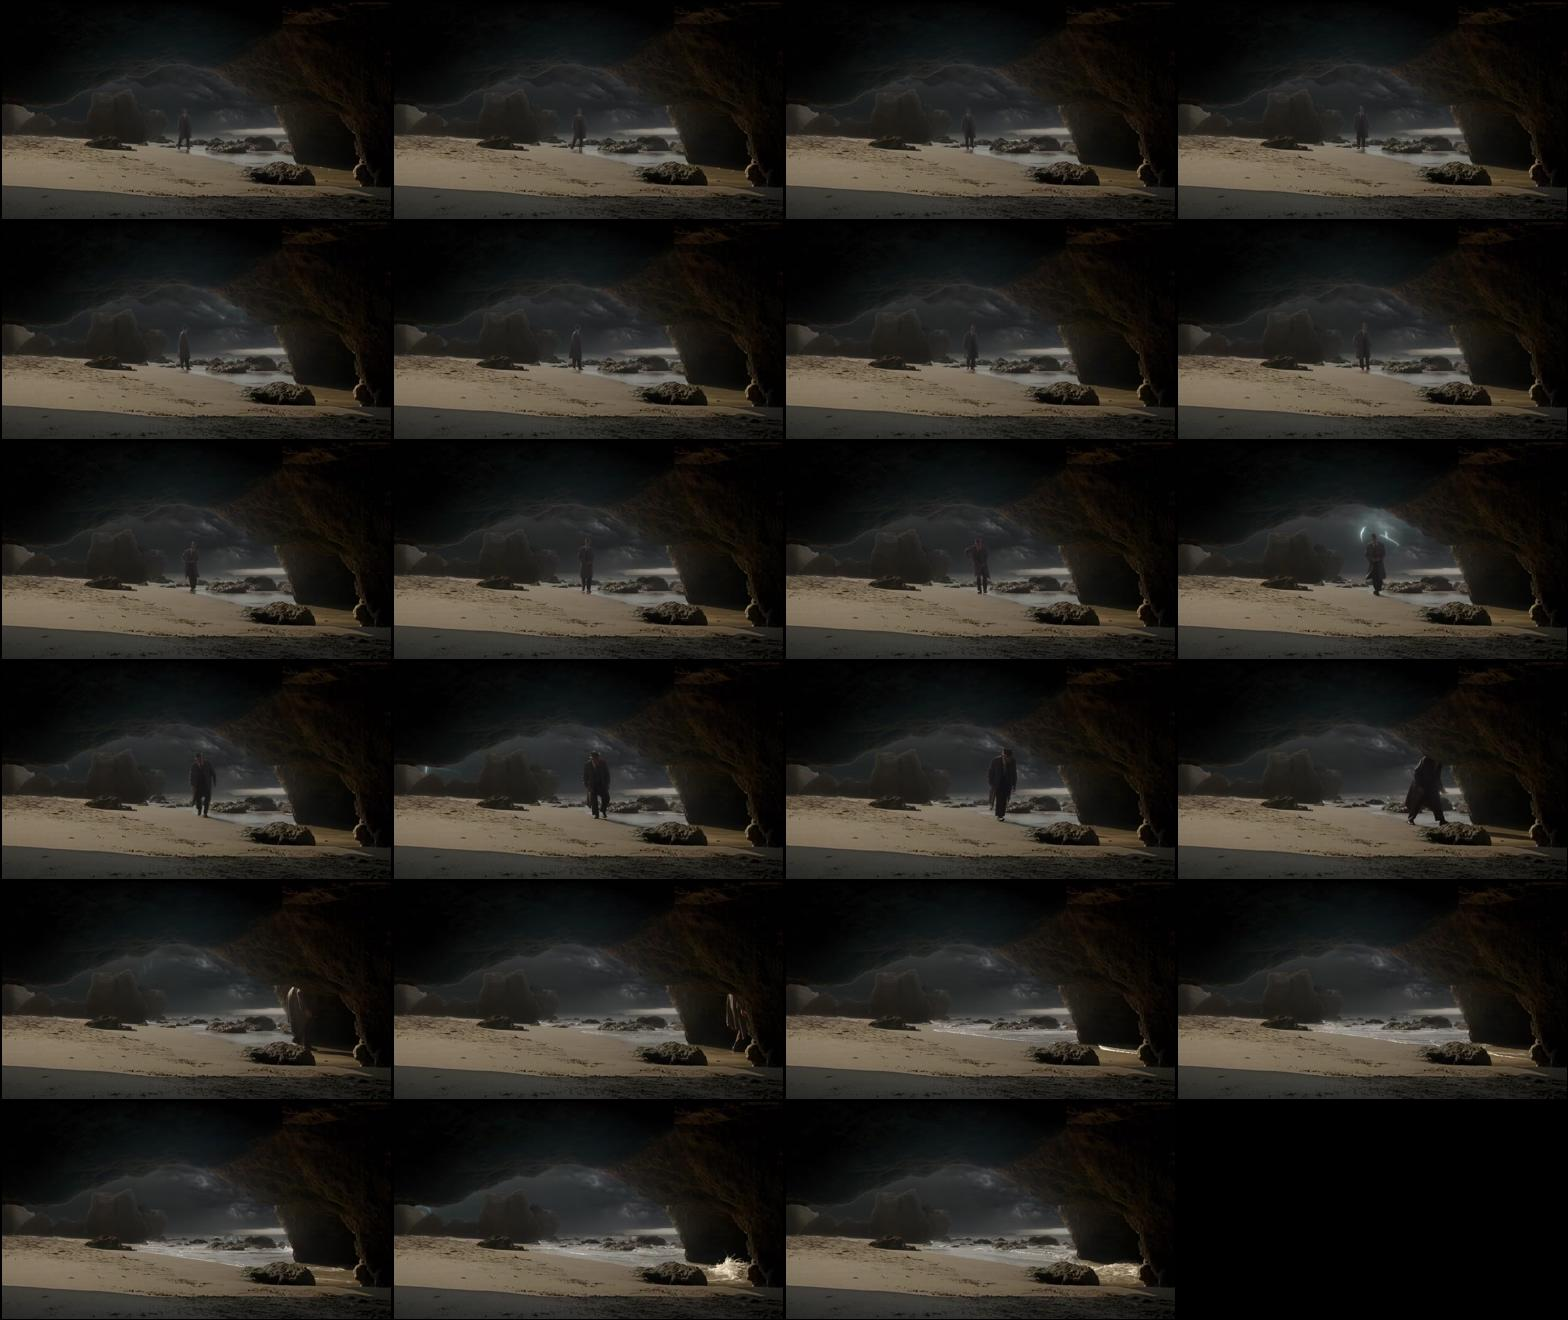

Shot description: The scene opens on a desolate sandy landscape under an ominous sky. A solitary figure is walking across the barren expanse. As the figure trudges forward, the dusty winds begin to swirl around them, obscuring their form. Suddenly, the winds intensify, enveloping the figure in a thick vortex of sand and debris. The sand storm rages violently, completely engulfing the person until they disappear from sight, consumed by the turbulent forces of nature in this inhospitable environment.

Shot transcript:  Then please come LAPD, put your hands in the air, put your hands up now, check it; 


SHOT 69/94: from 437904ms to 448248ms =======



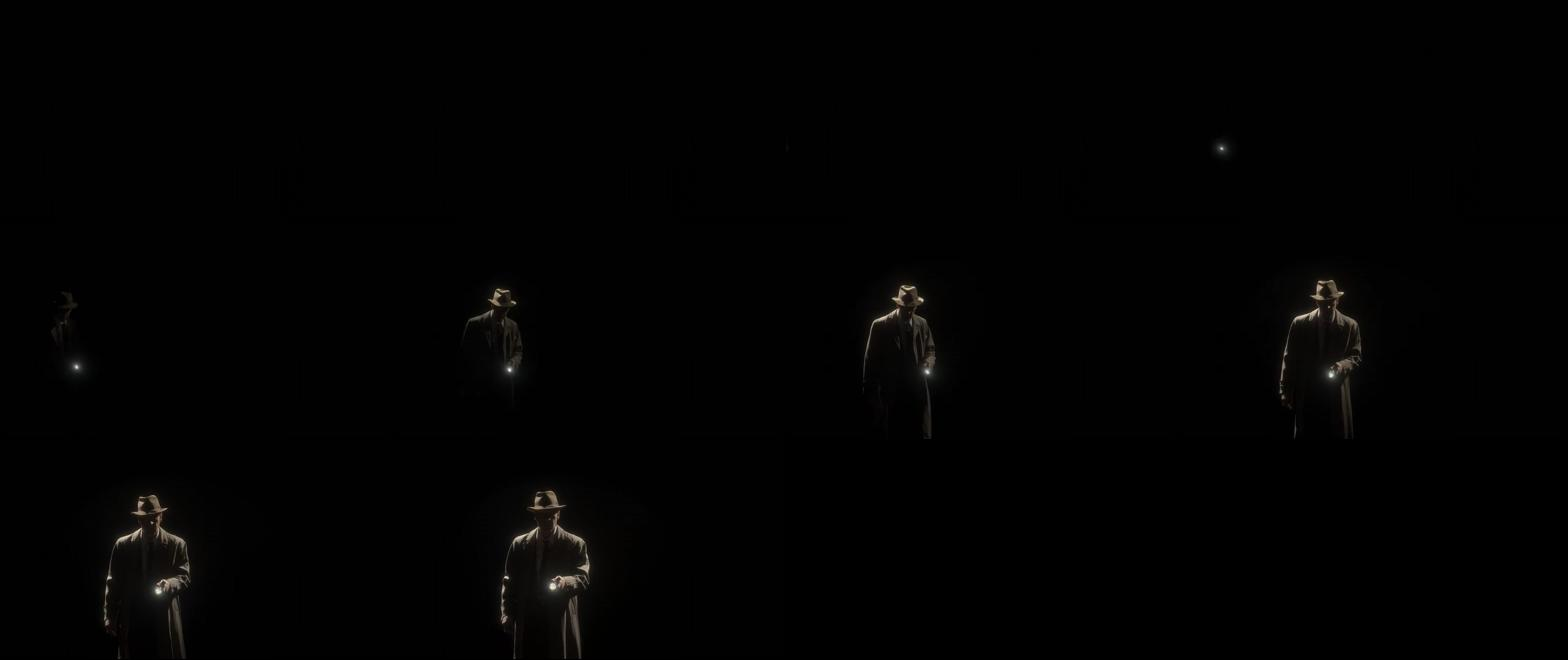

Shot description: The shot opens with a silhouetted figure standing alone in complete darkness, illuminated by a single spotlight. As the shot progresses, two more identical silhouetted figures appear beside the first one, also illuminated by spotlights. The three figures stand motionless in a line, their features obscured by the stark lighting against the black backdrop, creating an enigmatic and atmospheric scene that leaves the viewer curious about the identities and intentions of these mysterious figures.

Shot transcript:  Then please come LAPD, put your hands in the air, put your hands up now, check it; 


SHOT 70/94: from 448281ms to 450850ms =======



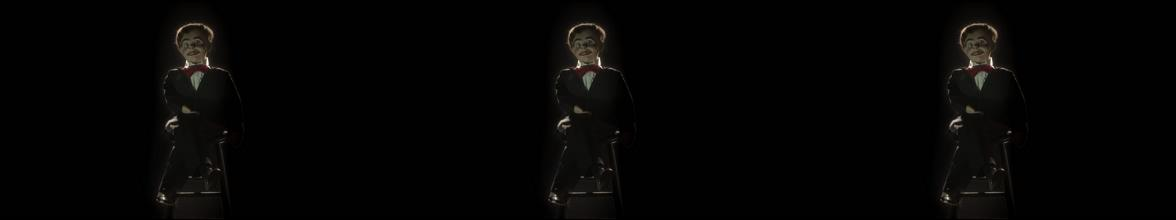

Shot description: In this shot, a sharply dressed individual wearing a tuxedo stands against a stark black backdrop. Their stance is poised and confident, suggesting they may be about to deliver a performance or address an audience. The three identical frames create a stylized, dramatic effect, drawing focus to the central figure's presence and building anticipation for their next movement or action.

Shot transcript:  Then please come LAPD, put your hands in the air, put your hands up now, check it; 


SHOT 71/94: from 450884ms to 459492ms =======



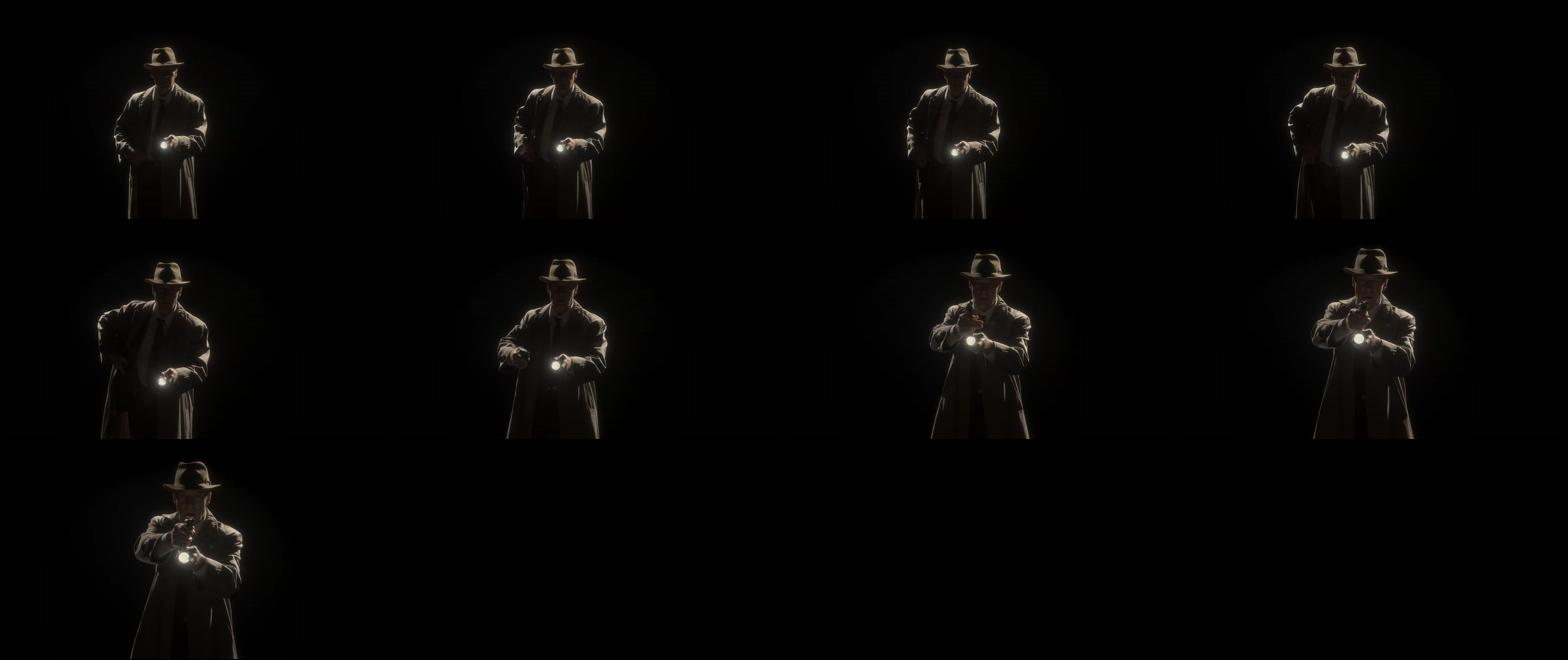

Shot description: The shot depicts a shadowy, mysterious figure dressed in a long coat and hat, standing against a pitch-black background. The figure initially stands motionless, arms crossed in a defensive stance. Gradually, the figure's arms unfold, revealing a revolver gripped tightly in one hand. The figure then raises the gun, aiming it forward in a threatening manner, suggesting a tense or confrontational situation. The stark lighting and dramatic framing create an ominous, film noir-esque atmosphere filled with tension and intrigue.

Shot transcript:  Then please come LAPD, put your hands in the air, put your hands up now, check it; 


SHOT 72/94: from 459526ms to 461428ms =======



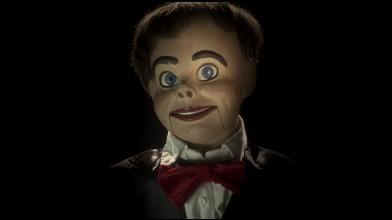

Shot description: The shot opens with an eerie, life-sized ventriloquist's dummy staring directly into the camera, its painted features frozen in a permanent, unsettling grin. The dummy wears an antiquated burgundy jacket and bow tie, lending an air of macabre sophistication. As the shot progresses, the camera slowly pushes in toward the grotesque, unblinking face, building a sense of tension and unease through the unnatural, unmoving visage. The tight framing and lack of any background context heightens the ominous, oppressive atmosphere surrounding this haunting, inanimate figure.

Shot transcript:  Then please come LAPD, put your hands in the air, put your hands up now, check it; 


SHOT 73/94: from 461461ms to 467200ms =======



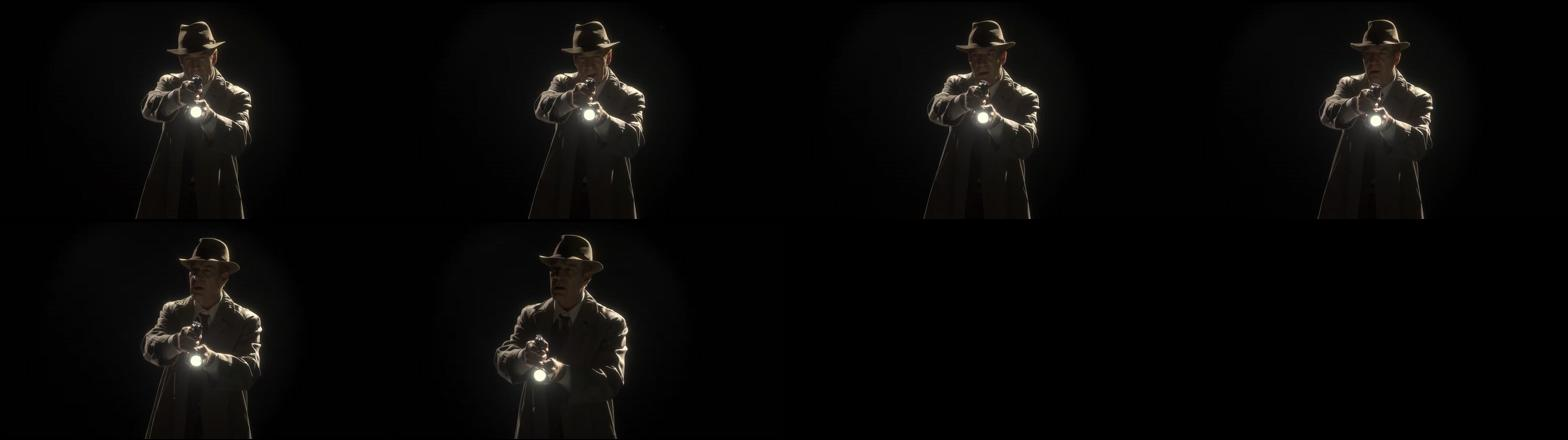

Shot description: The video shot opens with a noir-esque scene, featuring a mysterious figure dressed in a trench coat and a fedora hat against a pitch-black background. The person is illuminated by a bright spotlight, casting dramatic shadows on their face. They hold up a flashlight, shining it directly at the camera, creating a sense of tension and intrigue. The figure remains still and stoic throughout the shot, maintaining an air of mystery and suspense.

Shot transcript:  Then please come LAPD, put your hands in the air, put your hands up now, check it; 


SHOT 74/94: from 467233ms to 469669ms =======



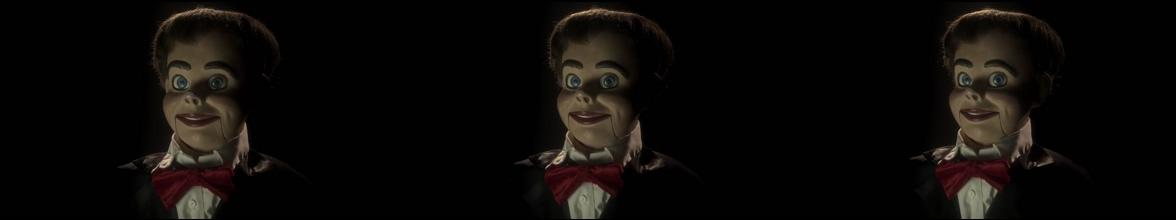

Shot description: The shot opens with a close-up of an unsettling ventriloquist dummy's face, with its wide unblinking eyes and eerie grin. The dummy is dressed in a tuxedo and red bowtie, giving it an almost theatrical appearance. As the frames progress, the camera remains locked on the dummy's face, unmoving, heightening the sense of unease and tension. The stark black background isolates the subject, drawing full attention to its haunting and lifeless expression that seems to follow the viewer.

Shot transcript:  Then please come LAPD, put your hands in the air, put your hands up now, check it; 


SHOT 75/94: from 469703ms to 476976ms =======



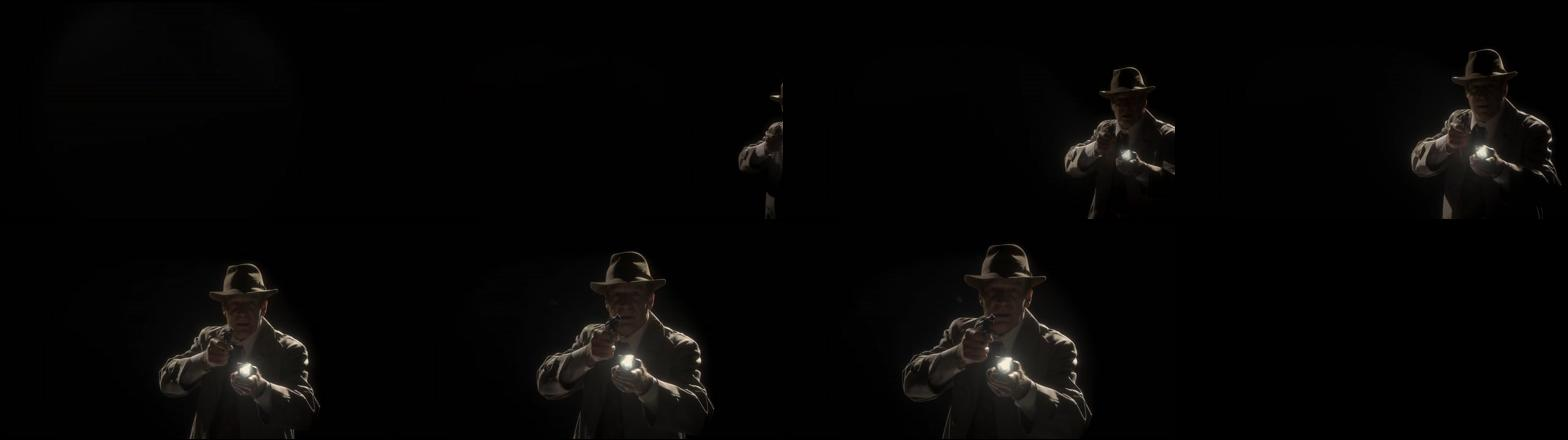

Shot description: The shot opens with a shadowy silhouette of a figure in a fedora hat, illuminated from below, resembling a noir detective aesthetic. As the shot progresses, the shadowy figure multiplies into three identical silhouettes, all maintaining the same mysterious stance with hands in pockets. The scene has a cinematic quality, evoking a sense of tension and intrigue through the use of dramatic lighting and the enigmatic, repeated forms, reminiscent of a stylized crime thriller or detective movie sequence.

Shot transcript:  Then please come LAPD, put your hands in the air, put your hands up now, check it; 


SHOT 76/94: from 477010ms to 482015ms =======



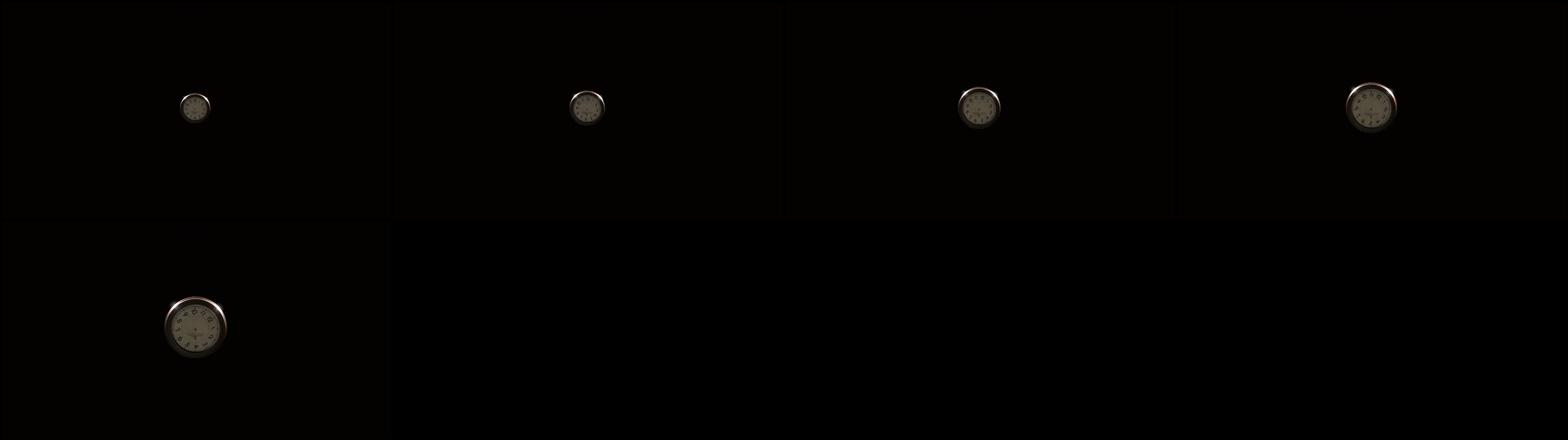

Shot description: The video shot shows a series of images depicting the different phases of a lunar eclipse. The moon begins as a faint, pale disk against the black night sky. In subsequent frames, a shadow gradually encroaches upon the lunar surface, slowly engulfing it until the moon transforms into a reddish-brown orb, completely immersed in the Earth's shadow during the total eclipse phase. The eclipse then reverses, with the moon regaining its brilliant white illumination as it emerges from the shadows and resumes its original appearance against the darkness.

Shot transcript:  Then please come LAPD, put your hands in the air, put your hands up now, check it; 


SHOT 77/94: from 482048ms to 496563ms =======



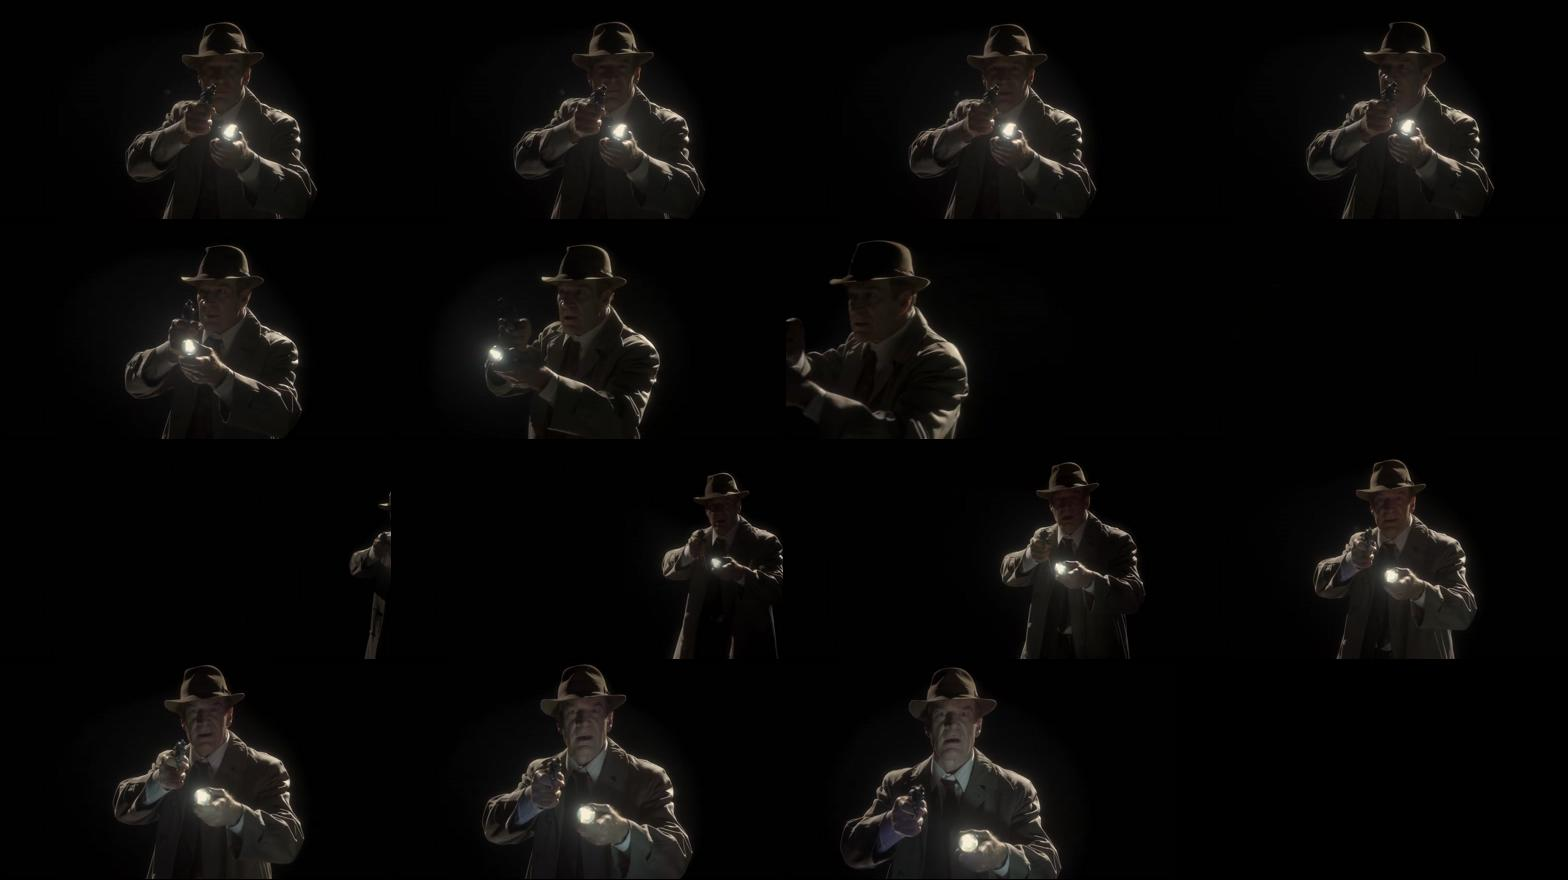

Shot description: The video shot depicts a man in a dark suit and fedora hat, standing against a black background, holding a flashlight. The man is captured in various stages of motion, suggesting he is moving the flashlight beam across his body, creating dramatic lighting effects on his face and torso. The sequence of frames gives the impression of a continuous, fluid movement, almost like a slow-motion or stop-motion effect. The stark lighting and dark background create a moody, cinematic atmosphere, potentially representing a film noir or detective-themed scene.

Shot transcript:  Then please come LAPD, put your hands in the air, put your hands up now, check it; 


SHOT 78/94: from 496596ms to 504104ms =======



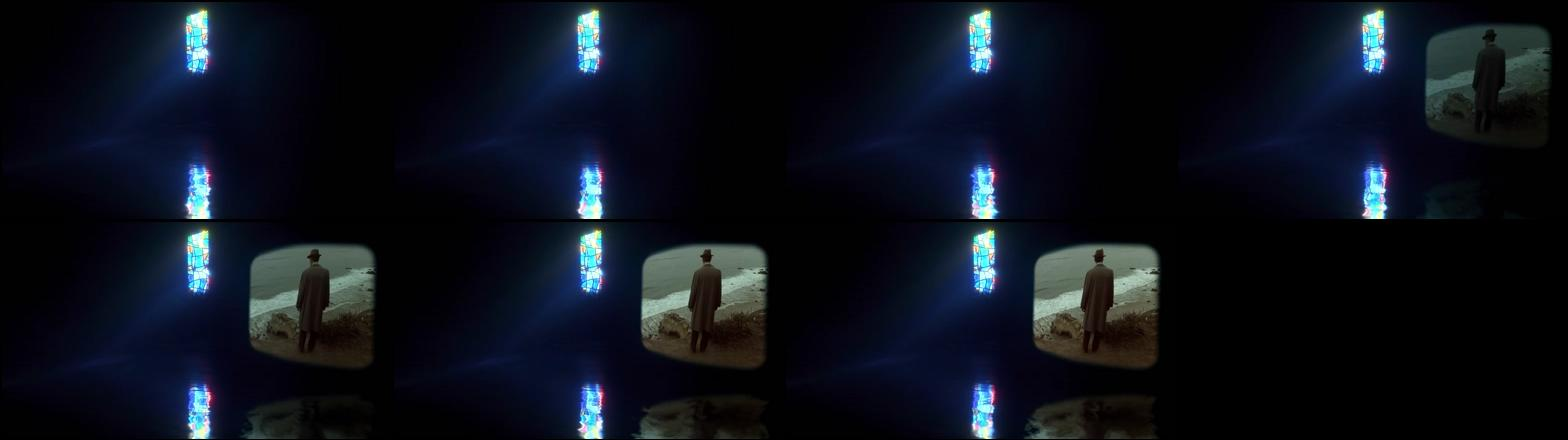

Shot description: In a stark, ethereal setting, a solitary figure dressed in a long robe stands motionless against a desolate landscape. The scene is illuminated by a series of vertical, glowing blue lights, casting an otherworldly glow. As the shot progresses, the figure remains unmoving, a silent observer amidst the haunting luminescence. The juxtaposition of the stoic human form and the surreal, artificial lighting creates a sense of intrigue and mystery, inviting the viewer to ponder the deeper symbolism or narrative underlying this enigmatic tableau.

Shot transcript:  Then please come LAPD, put your hands in the air, put your hands up now, check it; 


SHOT 79/94: from 504137ms to 511578ms =======



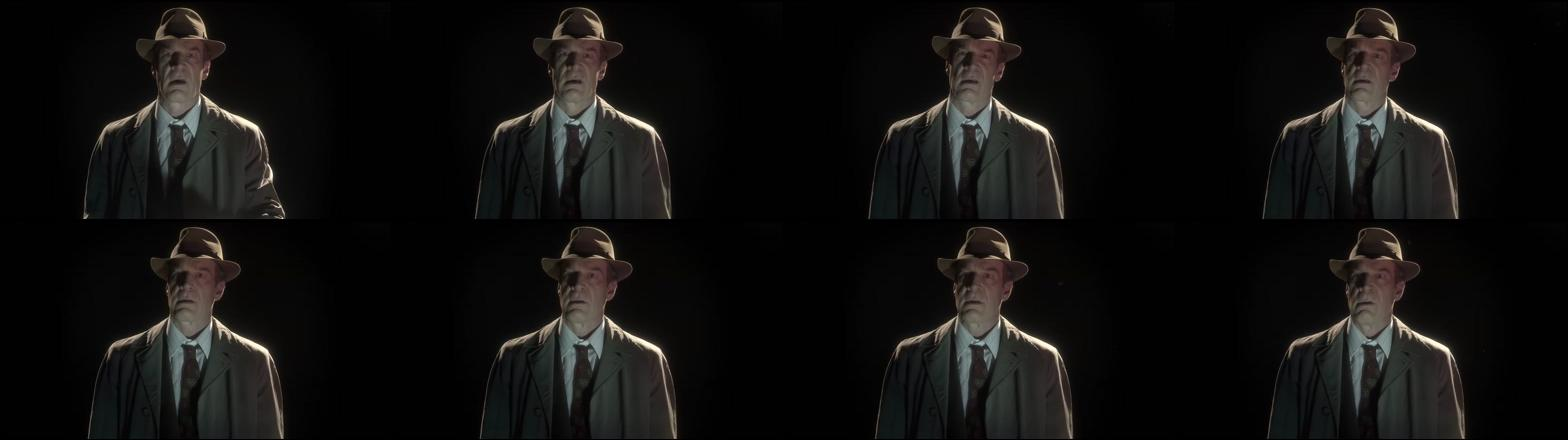

Shot description: This sequence presents a close-up shot of an elderly man's face, illuminated against a black background. He is dressed formally in a suit, hat, and tie, giving him a stern and serious appearance. The camera angle remains fixed, capturing subtle movements as the man's facial expression shifts slightly from frame to frame, perhaps conveying a range of emotions or thought processes without any dialogue or audible cues. The stark lighting and minimalist backdrop place the sole focus on the man's pensive, weathered face, creating an intimate and contemplative atmosphere within this brief cinematic moment.

Shot transcript:  Then please come LAPD, put your hands in the air, put your hands up now, check it; 


SHOT 80/94: from 511611ms to 519152ms =======



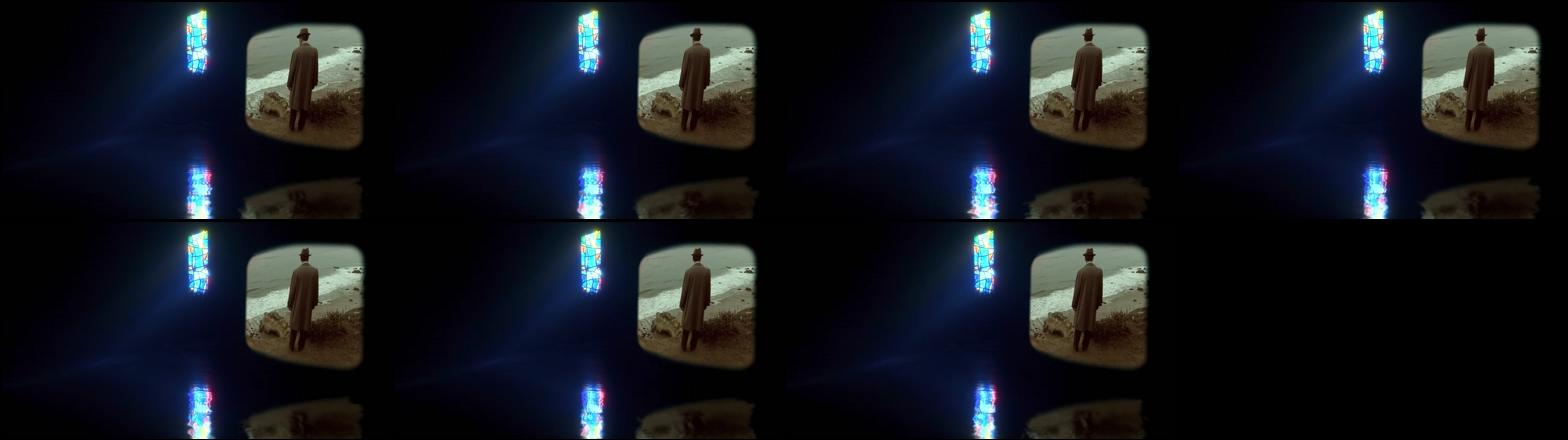

Shot description: The video shot appears to depict a surreal and dreamlike scene. It shows a figure dressed in a brown coat standing alone in an arid, desert-like landscape under an overcast sky. The figure's stance is pensive, with their back turned towards the camera. Surrounding this central image are multiple smaller, distorted copies of the same frame, creating a kaleidoscopic effect. The stark contrast between the muted tones of the landscape and the vibrant, glowing blue lights that border each frame lends an otherworldly and haunting quality to the scene. The repetition of the frames suggests a sense of entrapment or being trapped in a loop, perhaps symbolizing the cyclical nature of life or the weight of existential contemplation.

Shot transcript:  Then please come LAPD, put your hands in the air, put your hands up now, check it; 


SHOT 81/94: from 519185ms to 530930ms =======



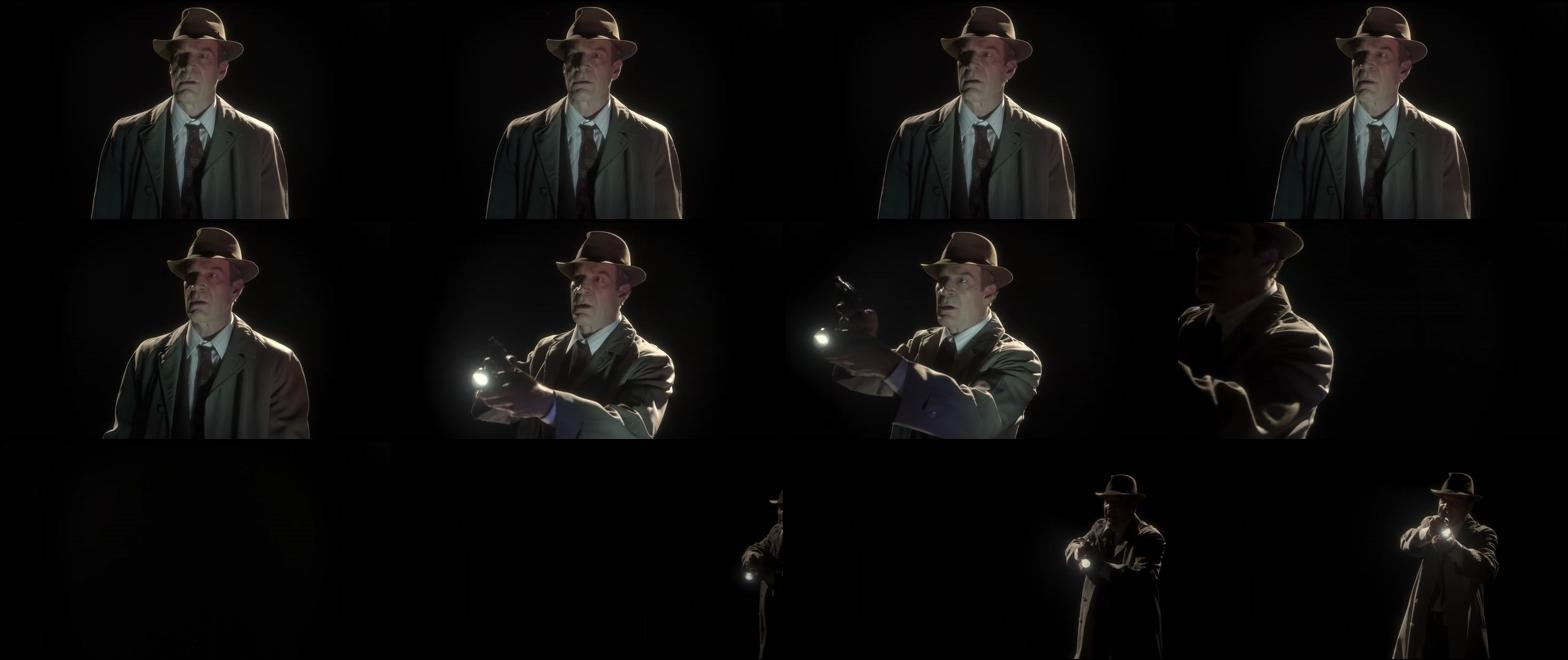

Shot description: The shot opens with an elderly man in a suit and hat standing still against a black background. As the frames progress, bright lights illuminate his body, casting dramatic shadows. He slowly raises his arms, revealing a revolver gripped in one hand. The man assumes a shooting stance, both hands grasping the gun, which he points forward intently. The tense scene suggests he is prepared to use the weapon, though his motives remain ambiguous in this frozen moment of the action.

Shot transcript:  Then please come LAPD, put your hands in the air, put your hands up now, check it; 


SHOT 82/94: from 530964ms to 532332ms =======



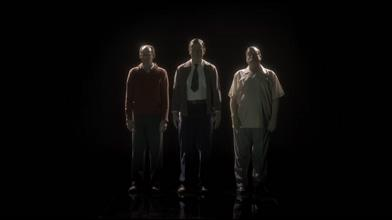

Shot description: The shot opens with three men standing together in a dramatic, shadowy lighting setup against a black background. They're positioned facing the camera, adopting serious expressions. The camera slowly pushes in closer on their solemn faces, intensifying the tense mood. As the shot continues, the lighting remains moody and atmospheric, obscuring specific details about their appearances but highlighting the weight and unease radiating from their figures. The slow push-in builds an ominous, foreboding tone, leaving an impactful visual of these three mysterious, imposing men united under the harsh lighting.

Shot transcript:  Then please come LAPD, put your hands in the air, put your hands up now, check it; 


SHOT 83/94: from 532365ms to 535335ms =======



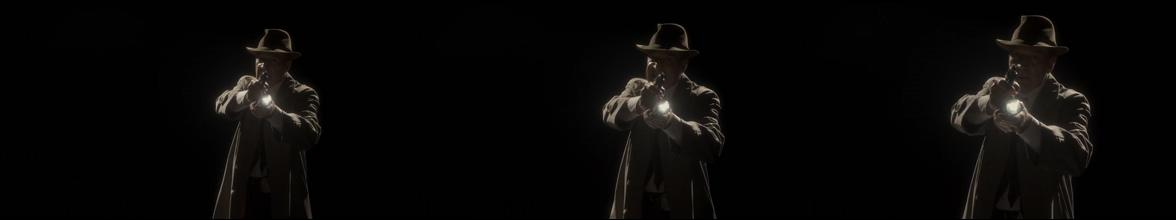

Shot description: A mysterious figure in a long coat and fedora stands motionless against a pitch-black background, their face obscured by shadows. The tension builds as the camera lingers on this enigmatic silhouette, leaving the viewer to wonder about the person's identity and intent. The austere composition and lack of context create an air of intrigue and suspense, drawing the audience into the narrative through clever visual storytelling.

Shot transcript:  Then please come LAPD, put your hands in the air, put your hands up now, check it; 


SHOT 84/94: from 535368ms to 538638ms =======



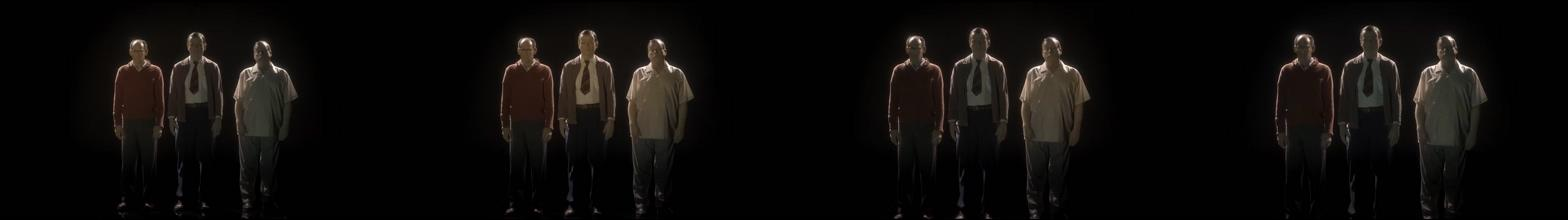

Shot description: The video shot opens with three silhouetted figures standing side by side against a pitch-black background. They appear to be middle-aged or elderly men dressed casually, with the central figure slightly shorter than the others. As the shot progresses, the figures remain motionless, their dark silhouettes creating an eerie and mysterious atmosphere. The lack of contextual details or background elements heightens the sense of intrigue and invites the viewer to ponder the identities and intentions of these enigmatic individuals.

Shot transcript:  Then please come LAPD, put your hands in the air, put your hands up now, check it; 


SHOT 85/94: from 538672ms to 548948ms =======



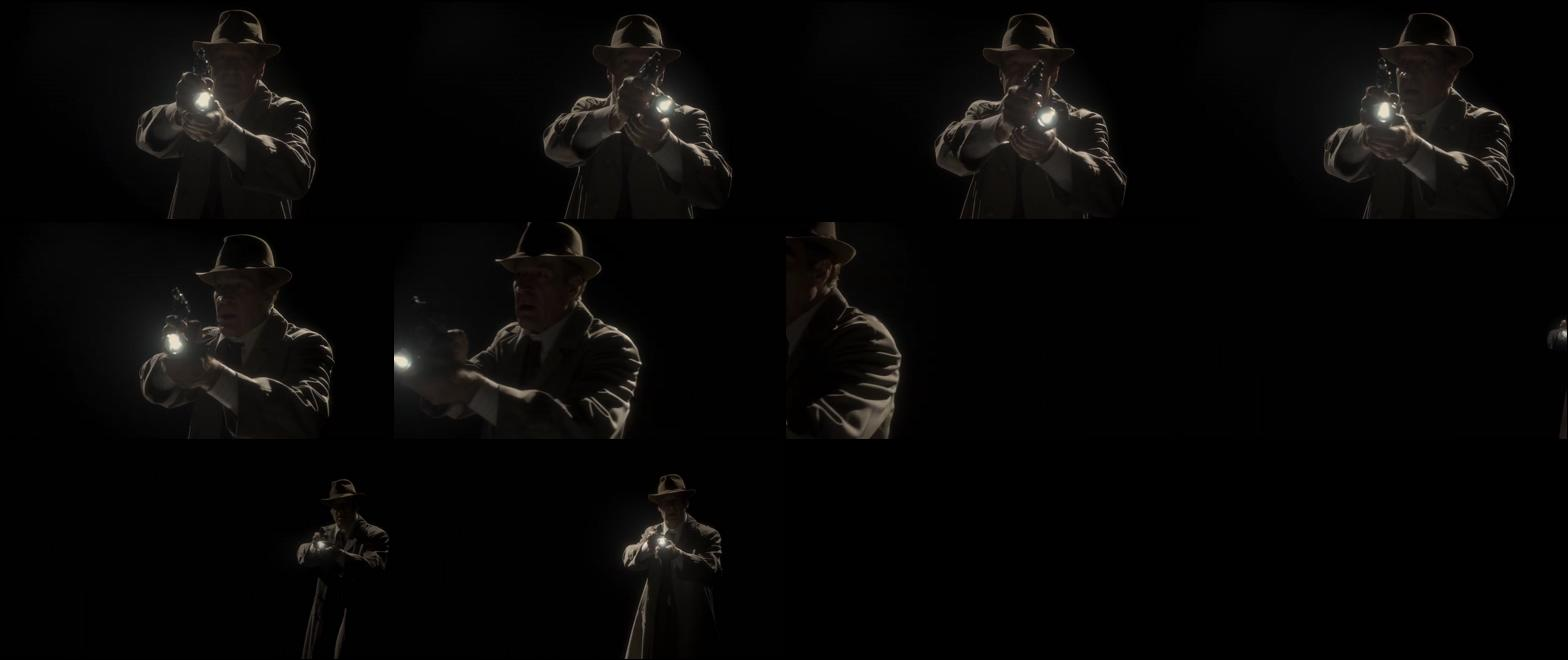

Shot description: A shadowy figure wearing a fedora hat moves through the darkness, illuminated only by the beam of a flashlight gripped in their hand. The light dances across their face in a dramatic chiaroscuro effect, obscuring their identity but hinting at a mysterious, noir-esque atmosphere. As the figure prowls forward, the light sweeps from side to side, creating a sense of cautious exploration or a covert investigation unfolding in the inky blackness. The sequence of frames captures the figure's deliberate, almost predatory movements, building tension and intrigue with each step into the unknown.

Shot transcript:  Then please come LAPD, put your hands in the air, put your hands up now, check it; 


SHOT 86/94: from 548982ms to 553453ms =======



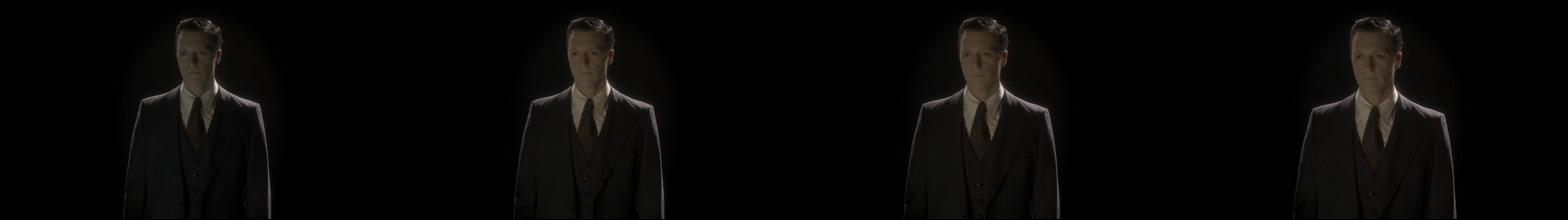

Shot description: The video shot opens with a man dressed in a formal black suit and tie standing motionless against a plain black background. His gaze is fixed and unwavering, creating an intense and somber atmosphere. The shot remains static, with the man's stoic expression and unmoving stance persisting throughout the entire duration, suggesting a moment of contemplation, solemnity or perhaps a dramatic pause before a significant event unfolds.

Shot transcript:  Then please come LAPD, put your hands in the air, put your hands up now, check it; 


SHOT 87/94: from 553486ms to 563296ms =======



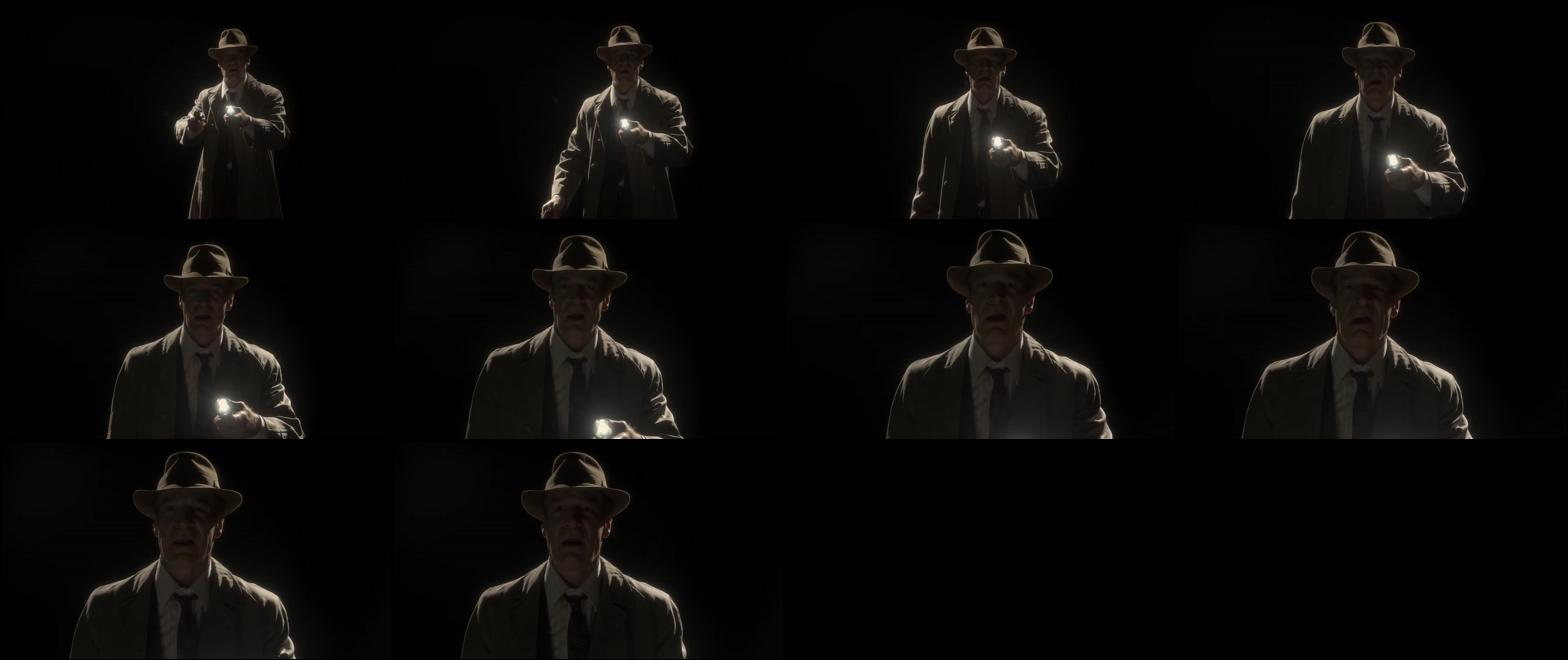

Shot description: The video shot depicts a shadowy figure wearing a hat and suit, illuminated by a spotlight against a black background. The figure appears to be moving or gesturing slightly with their hands and arms in a repetitive motion, creating a subtle animation effect across the frame sequence. The monochromatic lighting and lack of background details give the scene a mysterious, noir-esque aesthetic, potentially alluding to themes of secrecy, intrigue or investigation.

Shot transcript: 


SHOT 88/94: from 563329ms to 567400ms =======



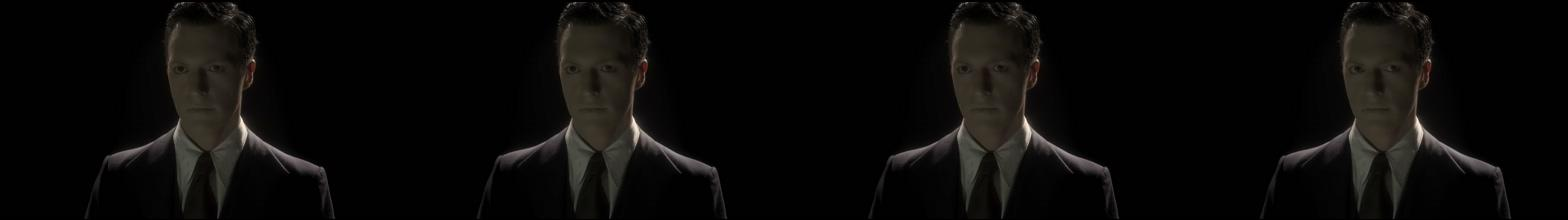

Shot description: In this shot, a man wearing a suit and tie is shown against a completely black background. His expression is stoic and unmoving as he stares directly into the camera, creating an intense and somber mood. The tight framing and lack of any other visual elements draw full attention to the subject, suggesting an emphasis on his presence or potential importance within a larger narrative context.

Shot transcript: 


SHOT 89/94: from 567434ms to 570670ms =======



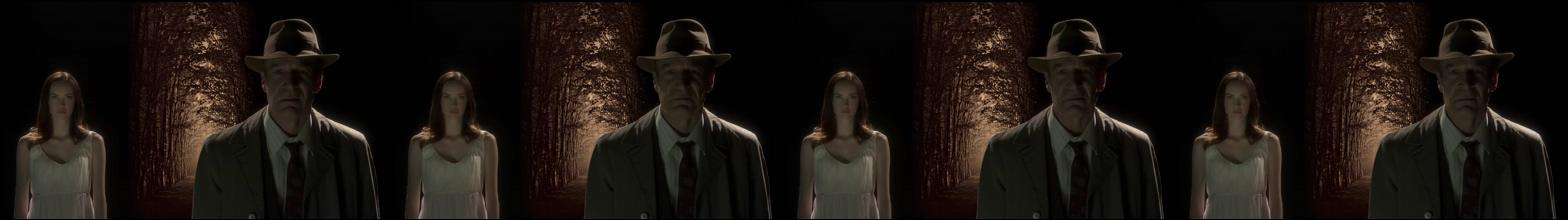

Shot description: In a dimly lit, mysterious setting, a man wearing a hat and suit stands beside a woman in a light-colored dress. The two figures remain motionless, their expressions inscrutable, creating an air of tension and intrigue. The shadowy background adds to the enigmatic atmosphere, leaving the viewer to speculate about the nature of their relationship and the events unfolding in this enigmatic scene.

Shot transcript: 


SHOT 90/94: from 570704ms to 578645ms =======



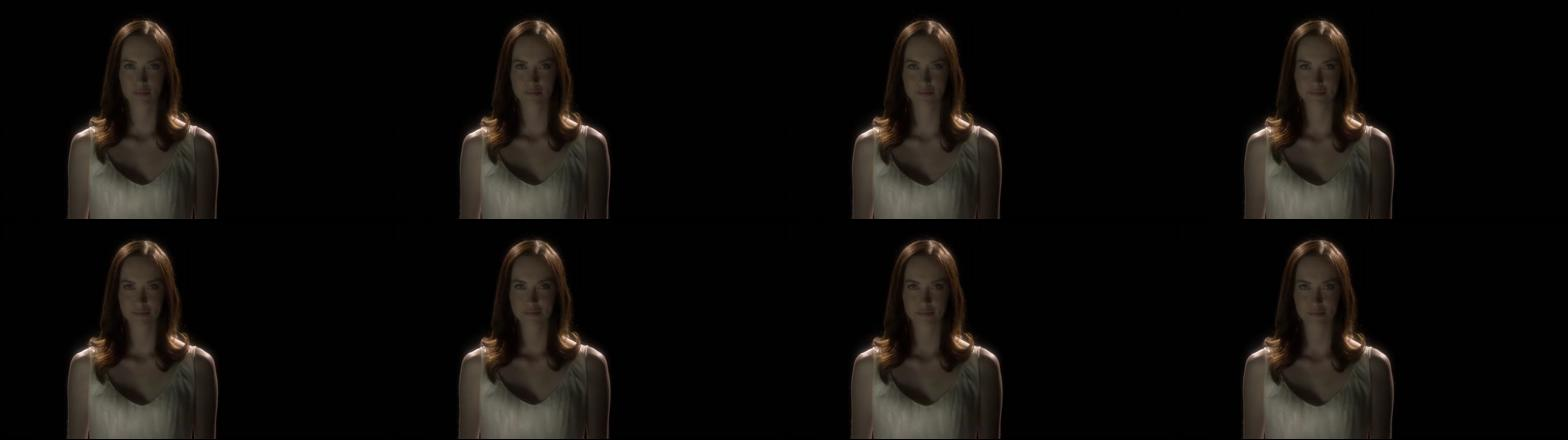

Shot description: In this video shot, a young woman with shoulder-length brown hair is depicted standing still against a black background. She is wearing a plain white top and has a serious, contemplative expression on her face. The sequence of frames appears to be a static shot, with the woman remaining motionless and the camera angle remaining fixed throughout the duration of the shot, creating a sense of stillness and focus on the subject's pensive demeanor.

Shot transcript: 


SHOT 91/94: from 578678ms to 708908ms =======



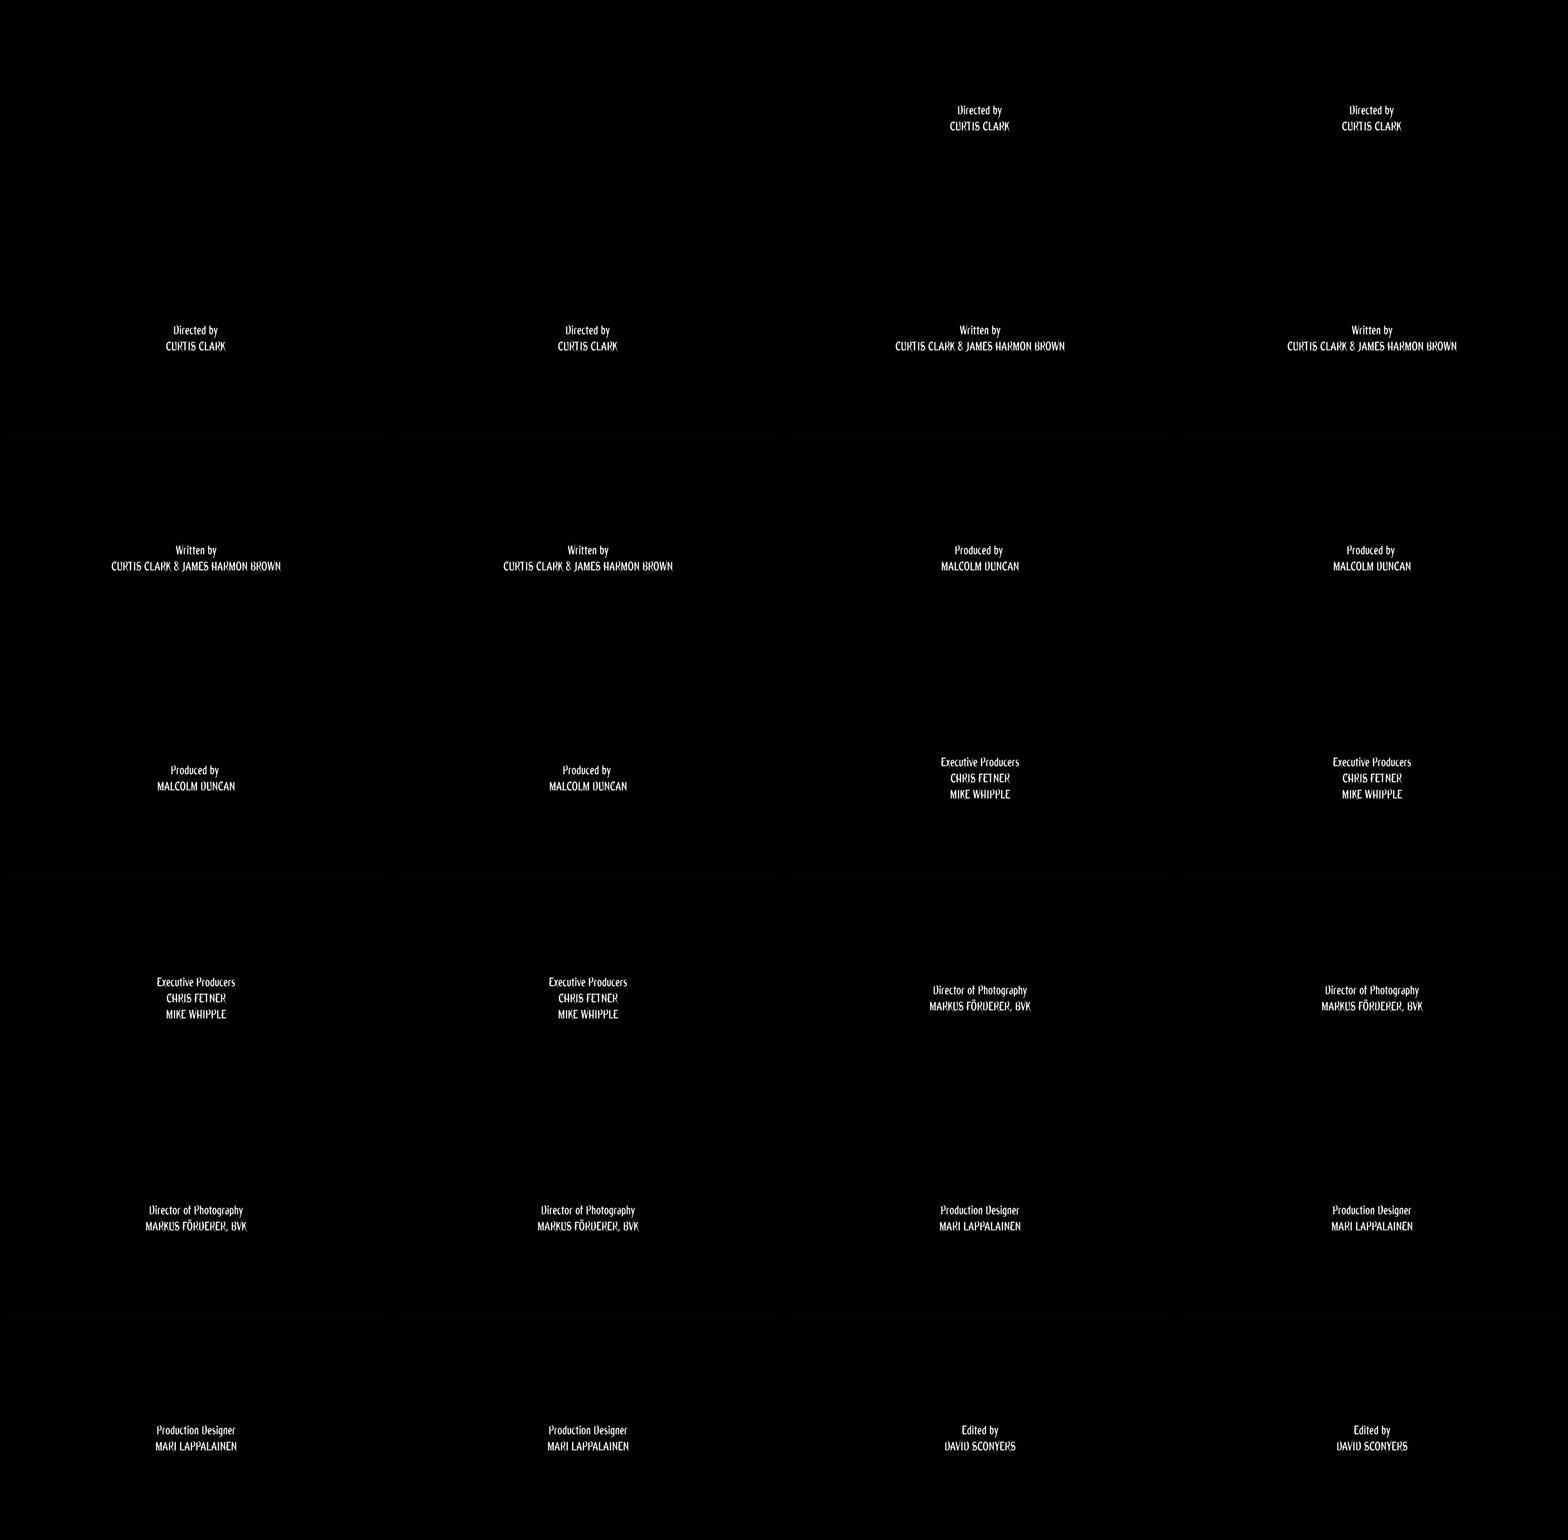

Shot description: The sequence opens with blank screens displaying the production credits for a film or video project. The credits reveal the names of the director (Curtis Clark), writers (Curtis Clark and James Shannon Brown), producer (Malcolm Duncan), executive producers (Chris Ettrick and Mike Whipple), director of photography (Morris Yungquist, 8x), production designer (Mimi Lippialaner), and editor (David Schomer). The minimalist design and black background create a sense of anticipation for the actual content to follow these opening titles.

Shot transcript: 


SHOT 92/94: from 708942ms to 711911ms =======



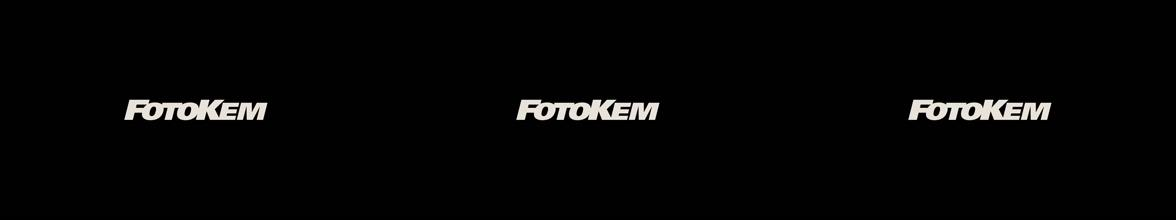

Shot description: The shot opens with a close-up of the Fotokem logo against a black background. As the shot progresses, the camera slowly zooms out, revealing more of the Fotokem logo, maintaining its centered composition within the frame. The shot appears to be an establishing shot or transition, likely used to introduce a film or video project associated with the Fotokem brand or company.

Shot transcript: 


SHOT 93/94: from 711945ms to 717717ms =======



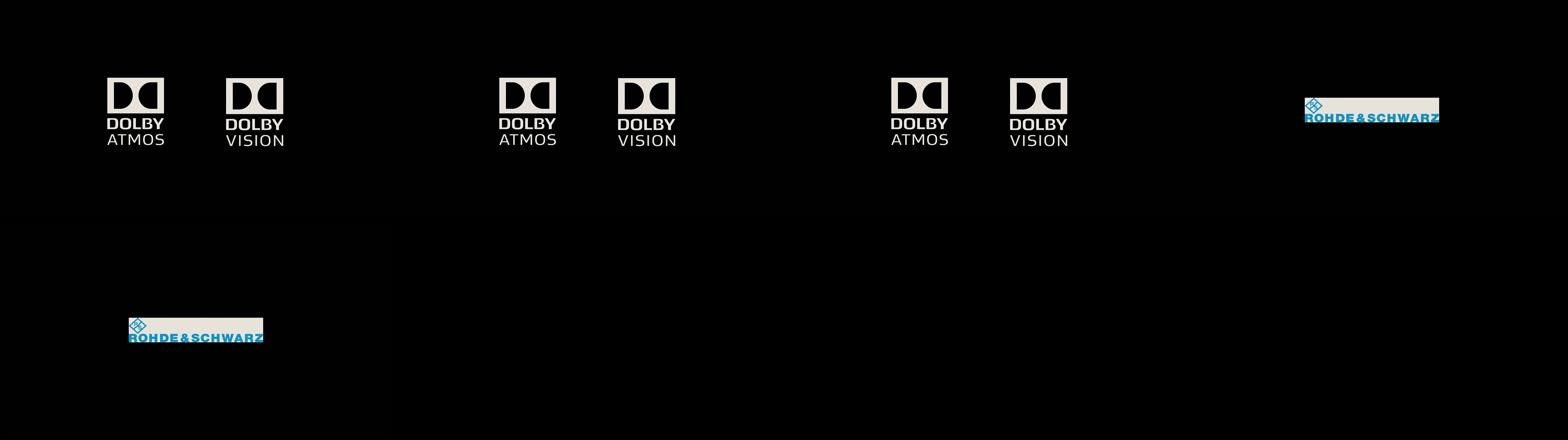

Shot description: The shot begins with the Dolby Atmos and Dolby Vision logos appearing on a black background, followed by the Sohra & Schwarz logo fading in below. This sequence likely represents the opening title cards or production company logos shown before the main content, setting the stage for an audio-visual experience enhanced by Dolby technologies. The static framing and gradual fading of the logos create a simple yet impactful introduction, building anticipation for what's to come.

Shot transcript: 


SHOT 94/94: from 717851ms to 718885ms =======



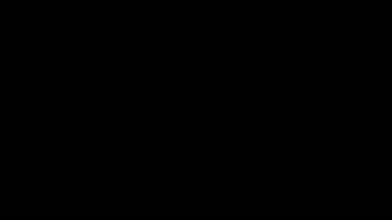

Shot description: The video shot opens with a close-up view of a person's hand picking up a metallic key from a wooden surface. The camera then pulls back to reveal a rustic wooden table with various items scattered on it, including a mug and some papers. The view shifts to capture a person, whose face is not shown, sitting at the table and sorting through the papers. They pause, deep in thought, before standing up and walking towards a door in the background. As they approach the door, the shot zooms in on their hand inserting the key into the lock and turning it. The door creaks open, and the person exits the room, leaving the viewer to wonder where they are headed next.

Shot transcript: 



In [37]:
for counter, shot in enumerate(video_shots, start=1):
    
    print(f'\nSHOT {counter}/{len(video_shots)}: from {shot["start_ms"] }ms to {shot["end_ms"] }ms =======\n')
    display(DisplayImage(f"{shot['composite_images'][0]['file']}"))
    print(f'Shot description: {shot["shot_description"]}\n')
    print(f'Shot transcript: {shot["shot_transcript"]}\n')

Now as we have a description and transcript for each shot, let's store them in [Amazon OpenSearch Serverless](https://aws.amazon.com/opensearch-service/features/serverless/) vector database for semantic search capabilities.

Firstly, we will create an OpenSearch index.

In [38]:
region = sagemaker_resources["region"]
aoss_host = session["AOSSCollectionEndpoint"]
aoss_index = "video-summarization-index"
text_embedding_model = "amazon.titan-embed-text-v2:0"
text_embedding_dimension = 1024

In [39]:
def create_opensearch_index(host, region, index, len_embedding):
    """
    Create an OpenSearch Serverless index with vector search capabilities
    Args:
        host - OpenSearch domain endpoint URL
        region - AWS region where the OpenSearch domain is hosted
        index - Name of the index to create
        len_embedding - Dimension size of the vector embeddings
    Returns:
        client - Configured OpenSearch client object
    """
    host = host.split("://")[1] if "://" in host else host
    credentials = boto3.Session().get_credentials()
    auth = AWSV4SignerAuth(credentials, region, "aoss")

    client = OpenSearch(
        hosts=[{"host": host, "port": 443}],
        http_auth=auth,
        use_ssl=True,
        verify_certs=True,
        connection_class=RequestsHttpConnection,
        pool_maxsize=20,
    )

    exist = client.indices.exists(index)
    if not exist:
        print("Creating index")
        index_body = {
            "mappings": {
                "properties": {
                    "video_name": {"type": "text"},
                    "shot_id": {"type": "text"},
                    "shot_startTime": {"type": "text"},
                    "shot_endTime": {"type": "text"},
                    "shot_description": {"type": "text"},
                    "shot_transcript": {"type": "text"},
                    "shot_desc_vector": {
                        "type": "knn_vector",
                        "dimension": len_embedding,
                        "method": {
                            "engine": "nmslib",
                            "space_type": "cosinesimil",
                            "name": "hnsw",
                            "parameters": {"ef_construction": 512, "m": 16},
                        },
                    },
                    "shot_transcript_vector": {
                        "type": "knn_vector",
                        "dimension": len_embedding,
                        "method": {
                            "engine": "nmslib",
                            "space_type": "cosinesimil",
                            "name": "hnsw",
                            "parameters": {"ef_construction": 512, "m": 16},
                        },
                    }
                }
            },
            "settings": {
                "index": {
                    "number_of_shards": 2,
                    "knn.algo_param": {"ef_search": 512},
                    "knn": True,
                }
            },
        }

        response = client.indices.create(index, body=index_body)

    print("Completed!")
    return client

In [40]:
aoss_client = create_opensearch_index(aoss_host, region, aoss_index, text_embedding_dimension)

Creating index
Completed!


Using text embedding model in Amazon Bedrock, we generate text embeddings for shot descriptions and transcripts before inserting these data into OpenSearch index.

In [41]:
def get_text_embedding(text_embedding_model, text):
    """
    Generate vector embeddings for text using Amazon Bedrock's embedding model
    Args:
        text_embedding_model - Model id of the Bedrock embedding model
        text - Input text to generate embeddings
        
    Returns:
        embedding - Result text's vector embedding
    """
    if not text.strip():
        text = "No transcript"
    body = json.dumps({"inputText": text, "dimensions": 1024, "normalize": True})
    response = bedrock_client.invoke_model(
        body=body, modelId=text_embedding_model, accept=accept, contentType=content_type
    )
    response_body = json.loads(response["body"].read())
    return response_body.get("embedding")
        
print(f"Insert embeddings to AOSS index ...")
for counter, shot in enumerate(video_shots, start=1):
    shot_desc_embedding = get_text_embedding(text_embedding_model, shot["shot_description"])
    shot_transcript_embedding = get_text_embedding(text_embedding_model, shot["shot_transcript"])
    embedding_request_body = json.dumps(
        {
            "video_name": video["path"],
            "shot_id": shot["id"],
            "shot_startTime": shot["start_ms"],
            "shot_endTime": shot["end_ms"],
            "shot_description": shot["shot_description"],
            "shot_transcript": shot["shot_transcript"],
            "shot_desc_vector": shot_desc_embedding,
            "shot_transcript_vector": shot_transcript_embedding
        }
    )

    response = aoss_client.index(
        index=aoss_index,
        body=embedding_request_body,
        params={"timeout": 60},
    )

print("Completed!")

Insert embeddings to AOSS index ...
Completed!


For each sentence in the video summary, we will search for relevant shots in the vector database using shots' description embeddings and shots' transcription embeddings. The search process assigns different weights to these embeddings to balance the importance of visual and audio information: **75% (or a 3.0 boost) for shot contextual description** that emphasizes the importance of visual content in finding relevant shots and **25% (or a 1.0 boost) for shot transcript** that allows the audio content to contribute to the search results, but with less influence than the visual descriptions.

The total duration of the selected shots will also need to match with the speech duration for each sentence.

But we will first make sure the inserted data in OpenSearch is ready to be searched.

In [42]:
print("Waiting for the recent inserted data to be searchable in OpenSearch...")

while True:
    try:
        result = aoss_client.search(index=aoss_index, body={"query": {"match_all": {}}})
        if result['hits']['total']['value'] == len(video_shots):
            print("\nData is now available for search!")
            break
        else:
            print(".", end="", flush=True)
            time.sleep(5)
    except Exception as e:
        print(".", end="", flush=True)
        time.sleep(5)

Waiting for the recent inserted data to be searchable in OpenSearch...
......
Data is now available for search!


In [43]:
def search_by_text(aoss_index, client, user_query):
    """
    Search for relevant video shots using semantic similarity with user's text query
    Args:
        aoss_index - Name of the OpenSearch index
        client - Configured OpenSearch client object
        user_query - Text query from the user
        
    Returns:
        response - List of dictionaries containing matching shots, where each dictionary includes:
                  - shot_id: unique identifier for the shot
                  - shot_startTime: start time of the shot
                  - shot_endTime: end time of the shot
                  - shot_description: visual description of the shot
                  - shot_transcript: transcript text from the shot
                  - score: similarity score of the match
    """
    text_embedding = get_text_embedding(text_embedding_model, user_query)

    aoss_query = {
        "size": 100,
        "query": {
            "bool": {
                "should": [
                    {
                        "script_score": {
                            "query": {"match_all": {}},
                            "script": {
                                "lang": "knn",
                                "source": "knn_score",
                                "params": {
                                    "field": "shot_desc_vector",
                                    "query_value": text_embedding,
                                    "space_type": "cosinesimil",
                                },
                            },
                            "boost": 3.0
                        }
                    },
                    {
                        "script_score": {
                            "query": {"match_all": {}},
                            "script": {
                                "lang": "knn",
                                "source": "knn_score",
                                "params": {
                                    "field": "shot_transcript_vector",
                                    "query_value": text_embedding,
                                    "space_type": "cosinesimil",
                                },
                            },
                            "boost": 1.0
                        }
                    }
                ],
                "minimum_should_match": 1
            }
        },
        "_source": [
            "shot_id",
            "shot_startTime",
            "shot_endTime",
            "shot_description",
            "shot_transcript",
        ],
    }

    response = client.search(body=aoss_query, index=aoss_index)
    hits = response["hits"]["hits"]
    response = []
    for hit in hits:
        if hit["_score"] >= 0:  # Set score threshold
            response.append(
                {
                    "shot_id": hit["_source"]["shot_id"],
                    "shot_startTime": hit["_source"]["shot_startTime"],
                    "shot_endTime": hit["_source"]["shot_endTime"],
                    "shot_description": hit["_source"]["shot_description"],
                    "shot_transcript": hit["_source"]["shot_transcript"],
                    "score": hit["_score"],
                }
            )

    return response

In [44]:
def find_shots(timecodes, sentence, duration):
    """
    Find and select video shots that match a summarized sentence, considering timing constraints
    Args:
        timecodes - List to store selected shot timecodes [[start_time, end_time], ...]
        sentence - Text to search for matching video shots
        duration - Required duration for the shots
    """
    relevant_shots = search_by_text(aoss_index, aoss_client, sentence)
    if duration is None: # intro
        timecodes.append([relevant_shots[0]["shot_startTime"], relevant_shots[0]["shot_endTime"]])
        shot_ids.add(relevant_shots[0]["shot_id"])
        intro_time = relevant_shots[0]["shot_endTime"] - relevant_shots[0]["shot_startTime"]
    else:
        i = 0
        while i < len(relevant_shots) and duration > 0:
            if relevant_shots[i]["shot_id"] in shot_ids:
                i += 1
                continue
            shot_duration = relevant_shots[i]["shot_endTime"] - relevant_shots[i]["shot_startTime"]
            # timecodes.append([relevant_shots[i]["shot_startTime"], relevant_shots[i]["shot_startTime"] + min(shot_duration, duration)])
            timecodes.append([relevant_shots[i]["shot_endTime"] - min(shot_duration, duration), relevant_shots[i]["shot_endTime"]])
            shot_ids.add(relevant_shots[i]["shot_id"])
            duration -= shot_duration
            i += 1
            

In [45]:
shot_ids = set()
timecodes = []

find_shots(timecodes, "Meridian", None) # Intro
for i in range(len(summarized_sentences)):
    find_shots(timecodes, summarized_sentences[i], speech_durations[i])

# creditTime = timecodes[-1][1] + 1000
# timecodes.append([timecodes[-1][1], creditTime])
timecodes_text = ""
for timecode in timecodes:
    timecodes_text += (
        ms_to_timecode(timecode[0], True)
        + ","
        + ms_to_timecode(timecode[1], True)
        + "\n"
    )
intro_time = timecodes[0][1] - timecodes[0][0]
to_json = lambda s: [
    {"StartTimecode": t1, "EndTimecode": t2}
    for t1, t2 in (line.split(",") for line in s.split("\n") if line.strip())
]
timecodes = to_json(timecodes_text)

The result is a list of timecodes that defines our final video segments.
    
Here are the generated timecodes that will be used for AWS Elemental MediaConvert input clipping:

In [46]:
timecodes

[{'StartTimecode': '00:00:23;01', 'EndTimecode': '00:00:29;19'},
 {'StartTimecode': '00:06:30;11', 'EndTimecode': '00:06:35;08'},
 {'StartTimecode': '00:00:41;01', 'EndTimecode': '00:00:45;03'},
 {'StartTimecode': '00:01:02;23', 'EndTimecode': '00:01:11;27'},
 {'StartTimecode': '00:04:03;10', 'EndTimecode': '00:04:13;06'},
 {'StartTimecode': '00:05:31;27', 'EndTimecode': '00:05:36;03'}]

Now that we have our timecodes, we can follow the same steps as in the previous section to:
1. Create input clips using AWS Elemental MediaConvert
2. Insert audio narration and subtitle to create a final short-form video

In [47]:
escaped_summarized_text = (
        summarized_text.replace("&", "&amp;")
        .replace('"', "&quot;")
        .replace("'", "&apos;")
        .replace("<", "&lt;")
        .replace(">", "&gt;")
    )
ssml = "<speak>\n"
break_time = intro_time

while break_time > 10000:  # maximum break time in Polly is 10s
    ssml += '<break time = "' + str(break_time) + 'ms"/>'
    break_time -= 10000
ssml += '<break time = "' + str(break_time) + 'ms"/>'
ssml += escaped_summarized_text
ssml += "</speak>"

response = polly_client.synthesize_speech(
    Engine="neural",
    OutputFormat="mp3",
    Text=ssml,
    TextType="ssml",
    VoiceId=voice_id,
)

if "AudioStream" in response:
    with response["AudioStream"] as stream:
        audio_narration = stream.read()

In [48]:
s3_client.put_object(
    Body=audio_narration, Bucket=s3_bucket, Key=audio_narration_filename, ContentType="audio/mpeg"
)

{'ResponseMetadata': {'RequestId': '2R5Q6CYVX2EY0XJA',
  'HostId': 'a7cjtOot9q3QAs9naNt789JGFjkds6dDJIw7KUTOPC8NuKWPIWLIM9A7QCUuXR2UbGTh+qb+JPk=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'a7cjtOot9q3QAs9naNt789JGFjkds6dDJIw7KUTOPC8NuKWPIWLIM9A7QCUuXR2UbGTh+qb+JPk=',
   'x-amz-request-id': '2R5Q6CYVX2EY0XJA',
   'date': 'Tue, 26 Nov 2024 02:17:10 GMT',
   'x-amz-server-side-encryption': 'AES256',
   'etag': '"1d696627970a5eb1e8fcbd8beae5289e"',
   'content-length': '0',
   'server': 'AmazonS3'},
  'RetryAttempts': 0},
 'ETag': '"1d696627970a5eb1e8fcbd8beae5289e"',
 'ServerSideEncryption': 'AES256'}

In [49]:
video_summary_subtitle = ""
start = intro_time
for i in range(len(summarized_sentences)):
    end = start + speech_durations[i]
    video_summary_subtitle += f"{i+1}\n"
    video_summary_subtitle += f"{milliseconds_to_subtitleTimeFormat(start)} --> {milliseconds_to_subtitleTimeFormat(end)}\n"
    sentence_lines = split_long_lines(summarized_sentences[i], 90)
    for line in sentence_lines:
        video_summary_subtitle += f"{line}\n"
    video_summary_subtitle += "\n"
    start = end
s3_client.put_object(
    Body=video_summary_subtitle, Bucket=s3_bucket, Key=subtitle_filename
)

{'ResponseMetadata': {'RequestId': '3Y91VTK3TQ5QZEGQ',
  'HostId': '/WOb1szVByEYw0MpCw0WW/lG6DziyBYgoEXpcJDHnaOKa00oGp+fSdceml17WBq3YdU4tgEDu3s=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': '/WOb1szVByEYw0MpCw0WW/lG6DziyBYgoEXpcJDHnaOKa00oGp+fSdceml17WBq3YdU4tgEDu3s=',
   'x-amz-request-id': '3Y91VTK3TQ5QZEGQ',
   'date': 'Tue, 26 Nov 2024 02:17:11 GMT',
   'x-amz-server-side-encryption': 'AES256',
   'etag': '"09d004a0e215959c15e7a26248633f08"',
   'content-length': '0',
   'server': 'AmazonS3'},
  'RetryAttempts': 0},
 'ETag': '"09d004a0e215959c15e7a26248633f08"',
 'ServerSideEncryption': 'AES256'}

In [50]:
def process_single_clip(media_convert, iam_role, input_video_path, output_video_path, timecode, clip_index):
    """
    Create a MediaConvert job to process a single video clip (due to multiple input clipping need be processed in chronological order)
    Args:
        media_convert - MediaConvert client
        iam_role - IAM role ARN for MediaConvert
        input_video_path - S3 path for input video
        output_video_path - S3 path for output video
        timecode - Dictionary containing start and end timecodes for the clip
        clip_index - Index number for the clip
        
    Returns:
        - job_id: MediaConvert job Id
        - clip_output: S3 path of the output clip
    """
    clip_output = f"{output_video_path}{video['output_dir']}_{clip_index}"
    
    response = media_convert.create_job(
        Queue="Default",
        UserMetadata={},
        Role=iam_role,
        Settings={
            "TimecodeConfig": {"Source": "ZEROBASED"},
            "OutputGroups": [
                {
                    "Name": "File Group",
                    "Outputs": [
                        {
                            "ContainerSettings": {
                                "Container": "MP4",
                                "Mp4Settings": {},
                            },
                            "VideoDescription": {
                                "CodecSettings": {
                                    "Codec": "H_264",
                                    "H264Settings": {
                                        "MaxBitrate": 40000000,
                                        "RateControlMode": "QVBR",
                                        "SceneChangeDetect": "TRANSITION_DETECTION",
                                    },
                                }
                            }
                        }
                    ],
                    "OutputGroupSettings": {
                        "Type": "FILE_GROUP_SETTINGS",
                        "FileGroupSettings": {"Destination": clip_output},
                    },
                }
            ],
            "Inputs": [
                {
                    "VideoSelector": {},
                    "TimecodeSource": "ZEROBASED",
                    "FileInput": video["url"],
                    "InputClippings": [timecode],
                }
            ],
        },
        AccelerationSettings={"Mode": "DISABLED"},
        StatusUpdateInterval="SECONDS_60",
        Priority=0,
    )
    
    return response["Job"]["Id"], clip_output

def wait_for_job(media_convert, job_id):
    """
    Wait for a MediaConvert job to complete
    Args:
        media_convert - MediaConvert client
        job_id - MediaConvert job Id
        
    Returns:
        bool - True if job completed successfully, False if error occurred
    """
    job_complete = False
    while not job_complete:
        job_response = media_convert.get_job(Id=job_id)
        job_status = job_response['Job']['Status']
        print(f"MediaConvert job status: {job_status}")
        
        if job_status in ['COMPLETE', 'ERROR']:
            return job_status == 'COMPLETE'
        time.sleep(10)

In [51]:
clip_paths = []
    
for i, timecode in enumerate(timecodes):
    print(f"Processing clip {i+1}/{len(timecodes)}")
    print(timecode)
    
    job_id, clip_output = process_single_clip(
        media_convert, 
        iam_role, 
        input_video_path, 
        output_video_path, 
        timecode, 
        i
    )

    if wait_for_job(media_convert, job_id):
        clip_paths.append(clip_output)
    else:
        print(f"Failed to process clip {i+1}")
        continue

Processing clip 1/6
{'StartTimecode': '00:00:23;01', 'EndTimecode': '00:00:29;19'}
MediaConvert job status: SUBMITTED
MediaConvert job status: PROGRESSING
MediaConvert job status: COMPLETE
Processing clip 2/6
{'StartTimecode': '00:06:30;11', 'EndTimecode': '00:06:35;08'}
MediaConvert job status: SUBMITTED
MediaConvert job status: PROGRESSING
MediaConvert job status: COMPLETE
Processing clip 3/6
{'StartTimecode': '00:00:41;01', 'EndTimecode': '00:00:45;03'}
MediaConvert job status: SUBMITTED
MediaConvert job status: PROGRESSING
MediaConvert job status: COMPLETE
Processing clip 4/6
{'StartTimecode': '00:01:02;23', 'EndTimecode': '00:01:11;27'}
MediaConvert job status: SUBMITTED
MediaConvert job status: PROGRESSING
MediaConvert job status: COMPLETE
Processing clip 5/6
{'StartTimecode': '00:04:03;10', 'EndTimecode': '00:04:13;06'}
MediaConvert job status: SUBMITTED
MediaConvert job status: PROGRESSING
MediaConvert job status: COMPLETE
Processing clip 6/6
{'StartTimecode': '00:05:31;27', 'E

In [52]:
def merge_clips(media_convert, iam_role, clip_paths, output_video_path):
    """
    Merge multiple video clips into a single video
    Args:
        media_convert - MediaConvert client
        iam_role - IAM role ARN for MediaConvert
        clip_paths - List of S3 paths of video clips to merge
        output_video_path - S3 path for video output
        
    Returns:
        - job_id: MediaConvert job Id
        - merged_output: S3 path of the video output
    """
    inputs = []
    
    for clip_path in clip_paths:
        inputs.append({
            "VideoSelector": {},
            "TimecodeSource": "ZEROBASED",
            "FileInput": clip_path + ".mp4",
        })

    merged_output = f"{output_video_path}{video['output_dir']}"
    
    response = media_convert.create_job(
        Queue="Default",
        UserMetadata={},
        Role=iam_role,
        Settings={
            "TimecodeConfig": {"Source": "ZEROBASED"},
            "OutputGroups": [
                {
                    "Name": "File Group",
                    "Outputs": [
                        {
                            "ContainerSettings": {
                                "Container": "MP4",
                                "Mp4Settings": {},
                            },
                            "VideoDescription": {
                                "CodecSettings": {
                                    "Codec": "H_264",
                                    "H264Settings": {
                                        "MaxBitrate": 40000000,
                                        "RateControlMode": "QVBR",
                                        "SceneChangeDetect": "TRANSITION_DETECTION",
                                    },
                                }
                            }
                        }
                    ],
                    "OutputGroupSettings": {
                        "Type": "FILE_GROUP_SETTINGS",
                        "FileGroupSettings": {"Destination": merged_output},
                    },
                }
            ],
            "Inputs": inputs,
        },
        AccelerationSettings={"Mode": "DISABLED"},
        StatusUpdateInterval="SECONDS_60",
        Priority=0,
    )
    
    return response["Job"]["Id"], merged_output

def add_audio_subtitles(media_convert, iam_role, input_video_path, audio_file_path, subtitle_file_path, final_output_path):
    """
    Add audio narration and subtitle into the video
    Args:
        media_convert - MediaConvert client
        iam_role - IAM role ARN for MediaConvert
        input_video_path - S3 path for input video
        audio_file_path - S3 path for audio narration file
        subtitle_file_path - S3 path for SRT subtitle file
        final_output_path - S3 path for video output
        
    Returns:
        job_id: MediaConvert job Id
    """
    
    response = media_convert.create_job(
        Queue="Default",
        UserMetadata={},
        Role=iam_role,
        Settings={
            "TimecodeConfig": {"Source": "ZEROBASED"},
            "OutputGroups": [
                {
                    "Name": "File Group",
                    "Outputs": [
                        {
                            "ContainerSettings": {
                                "Container": "MP4",
                                "Mp4Settings": {},
                            },
                            "VideoDescription": {
                                "CodecSettings": {
                                    "Codec": "H_264",
                                    "H264Settings": {
                                        "MaxBitrate": 40000000,
                                        "RateControlMode": "QVBR",
                                        "SceneChangeDetect": "TRANSITION_DETECTION",
                                    },
                                }
                            },
                            "NameModifier": "_summary_v2",
                            "AudioDescriptions": [
                                {
                                    "AudioSourceName": "Audio Selector Group 1",
                                    "CodecSettings": {
                                        "Codec": "AAC",
                                        "AacSettings": {
                                            "Bitrate": 96000,
                                            "CodingMode": "CODING_MODE_2_0",
                                            "SampleRate": 48000,
                                        },
                                    },
                                }
                            ],
                            "CaptionDescriptions": [
                                {
                                    "CaptionSelectorName": "Captions Selector 1",
                                    "DestinationSettings": {
                                        "DestinationType": "BURN_IN",
                                        "BurninDestinationSettings": {
                                            "BackgroundOpacity": 100,
                                            "FontSize": 18,
                                            "FontColor": "WHITE",
                                            "ApplyFontColor": "ALL_TEXT",
                                            "BackgroundColor": "BLACK",
                                        },
                                    },
                                }
                            ],
                        }
                    ],
                    "OutputGroupSettings": {
                        "Type": "FILE_GROUP_SETTINGS",
                        "FileGroupSettings": {"Destination": final_output_path},
                    },
                }
            ],
            "Inputs": [
                {
                    "VideoSelector": {},
                    "TimecodeSource": "ZEROBASED",
                    "FileInput": input_video_path,
                    "AudioSelectors": {
                        "Audio Selector 1": {
                            "DefaultSelection": "NOT_DEFAULT",
                            "ExternalAudioFileInput": audio_file_path,
                        },
                    },
                    "AudioSelectorGroups": {
                        "Audio Selector Group 1": {
                            "AudioSelectorNames": ["Audio Selector 1"]
                        }
                    },
                    "CaptionSelectors": {
                        "Captions Selector 1": {
                            "SourceSettings": {
                                "SourceType": "SRT",
                                "FileSourceSettings": {"SourceFile": subtitle_file_path},
                            }
                        }
                    },
                }
            ],
        },
        AccelerationSettings={"Mode": "DISABLED"},
        StatusUpdateInterval="SECONDS_60",
        Priority=0,
    )
    
    return response["Job"]["Id"]

Merge all clips with audio and subtitles.

In [53]:
merge_job_id, merged_output = merge_clips(
    media_convert, 
    iam_role, 
    clip_paths, 
    output_video_path
)

if wait_for_job(media_convert, merge_job_id):
    print("Successfully merged video clips")
else:
    print("Failed to merge video clips")

final_job_id = add_audio_subtitles(
    media_convert,
    iam_role,
    merged_output + ".mp4",
    audio_file_path,
    subtitle_file_path,
    output_video_path
)

if wait_for_job(media_convert, final_job_id):
    print("Successfully created final video with audio and subtitle")
else:
    print("Failed to add audio and subtitle")

MediaConvert job status: SUBMITTED
MediaConvert job status: PROGRESSING
MediaConvert job status: COMPLETE
Successfully merged video clips
MediaConvert job status: SUBMITTED
MediaConvert job status: PROGRESSING
MediaConvert job status: COMPLETE
Successfully created final video with audio and subtitle


Here is our final video summary incorporating both visual and audio understanding. Compare it with our earlier version (based only on audio narration) to see the differences in the results.

In [54]:
video_summary_v2 = os.path.splitext(os.path.basename(video['path']))[0] + "_summary_v2.mp4"
s3_client.download_file(s3_bucket, video_summary_v2, video_summary_v2)
print("Short-form video with video and audio understanding\n")
print("=========================================\n")
display(Video(url=video_summary_v2, width=640, height=360, html_attributes="controls muted autoplay"))

Short-form video with video and audio understanding




In [55]:
print("Short-form video with audio understanding only\n")
print("=========================================\n")
display(Video(url=video_summary, width=640, height=360, html_attributes="controls muted autoplay"))

Short-form video with audio understanding only




## Clean up
Uncomment the code below and remove some of the resource we generated in this lab

In [56]:
# s3_client.delete_object(Bucket=s3_bucket, Key=audio_narration_filename)
# s3_client.delete_object(Bucket=s3_bucket, Key=video['path'])
# s3_client.delete_object(Bucket=s3_bucket, Key=subtitle_filename)
# s3_client.delete_object(Bucket=s3_bucket, Key=video_summary)
# s3_client.delete_object(Bucket=s3_bucket, Key=video_summary_v2)
# aoss_client.indices.delete(aoss_index)

# What's Next?

You can try another use case or, if you are done, continue to the [Additional Resources](09-resources.ipynb) lab.